In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.metrics import log_loss, plot_confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
import json
import matplotlib.pyplot as plt
import seaborn as sns

import eli5
from eli5.sklearn import PermutationImportance

import warnings
from warnings import simplefilter

warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)

RAND = 10
RAND_1 = 5
RAND_2 = 7
N_FOLDS = 5

Ссылка на соревнования: https://zindi.africa/competitions/ai4d-lab-tanzania-tourism-classification-challenge

**Описание**

Задача: Набор данных описывает актуальную информацию о туристических расходах, собранных Национальным бюро статистики (НБС) Танзании. Набор данных был собран, чтобы лучше понять состояние сектора туризма и предоставить инструмент, который будет обеспечить рост отрасли.
    
Цель: классифицировать диапазон расходов, который туристическая группа тратит в Танзании, чтобы автоматически помочь туристам со всего мира оценить свои расходы перед посещением Танзании.   

Оценка: показателем оценки для этой задачи является ***logloss***   

***Признаки***
 
 **id** -  Unique identifier for each tourist (Уникальный идентификатор для каждого туриста)
 
**country** -  The country a tourist coming  from (Страна, из которой приехал турист)

**age_group** -  The age group of a tourist (Возрастная группа туриста)

**travel_with** -  The relation of people a tourist travel with to Tanzania (Отношение людей, с которыми путешествуют туристы по Танзании)

**total_female** -  Total number of females (Общее количество женщин)

**total_male** -  Total number of males (Общее количество мужчин)

**purpose** -  The purpose of visiting  Tanzania (Цель посещения Танзании)

**main_activity** -  The main activity of tourism in Tanzania (Основное направление туризма в Танзании)

**infor_source** -  The source of information about tourism in Tanzania (Источник информации о туризме в Танзании)

**tour_arrangment** -  The arrangment of visiting Tanzania (Организация посещения Танзании)

**package_transport_int** -  If the tour package include international transportation service (Если турпакет включает международные перевозки)

**package_accomodation** -  If the tour package include accommodation service (Если в турпакет входит услуга проживания)

**package_food** -  If the tour package include food service (Если в турпакет включено питание)

**package_transport_tz** -  If the tour package include transport service within Tanzania (Если турпакет включает транспортное обслуживание в пределах Танзании)

**package_sightseeing** -  If the tour package include sightseeing service (Если турпакет включает экскурсионное обслуживание)

**package_guided_tour** -  If the tour package include tour guide (Если турпакет включает гида)

**package_insurance** -  if the tour package include insurance service (если турпакет включает страховку)

**night_mainland** -  Number of nights a tourist spent in Tanzania mainland (Количество ночей, проведенных туристом на материковой части Танзании)

**night_zanzibar** -  Number of nights a tourist spent in Zanzibar (Количество ночей, проведенных туристом на Занзибаре)
*Занзибар - остров 

**first_trip_tz** -  If it was a first  trip to Tanzania (Если бы это была первая поездка в Танзанию)

**cost_category** -  The range of expenditures a tourist spends in Tanzania (Диапазон расходов, которые турист тратит в Танзании)

# Import Data

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# train dataset categorical
df_train = pd.read_csv(
    'E:\Pet_project\Tourism Classification Challenge\Preprocessing_datasets\df.csv'
)
# train dataset binrized
df_train_bin = pd.read_csv(
    'E:\Pet_project\Tourism Classification Challenge\Preprocessing_datasets\data_train_bin.csv'
)
# словарь
with open('E:\Pet_project\Tourism Classification Challenge\Preprocessing_datasets\mapping.json') as file:
    mapping = json.load(file)

In [4]:
df_train.head()

,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
0,italy,4,With_Children,0.0,2.0,Visiting_Friends_and_Relatives,Beach_Tourism,Friends_relatives,Package_Tour,1,1,1,1,0,0,0,0,7,1,0
1,united_kingdom,3,With_Spouse,1.0,1.0,Leisure_and_Holidays,Wildlife_Tourism,Travel_agent_tour_operator,Package_Tour,1,1,1,1,0,0,0,0,7,1,0
2,united_states_of_america,5,With_Spouse,1.0,1.0,Leisure_and_Holidays,Wildlife_Tourism,Travel_agent_tour_operator,Package_Tour,1,1,1,1,1,1,0,6,6,1,1
3,rwanda,3,With_Spouse_and_Children,3.0,1.0,Leisure_and_Holidays,Beach_Tourism,Radio_TV_Web,Independent,0,0,0,0,0,0,0,3,0,0,4
4,united_states_of_america,4,Alone,0.0,1.0,Leisure_and_Holidays,Wildlife_Tourism,Travel_agent_tour_operator,Package_Tour,1,1,1,1,0,1,1,7,0,1,1


In [5]:
# функция для перевода типа данных столбцов
def new_type(data: pd.DataFrame, was: str, will: str) -> pd.DataFrame:
    data[data.select_dtypes(was).columns] = data[data.select_dtypes(
        was).columns].astype(will)

In [6]:
new_type(df_train, 'object', 'category')

# Modeling

Для предсказания вероятностей классов необходимо рассмотреть несколько моделей МО для выбора лучшей на основе показателя logloss.
Для каждого алгоритма сначала строю baseline, затем подбираю параметры для обучения модели.

## One-vs-rest

Вначале для baseline использую два метдоа One-Vs-One и One-vs-All

При разбивке данных необходимо недопустить разницу между train и test категориальных данных и бинариозованных

In [7]:
# функция для разбивки на train и test
def split_data(data_bin: pd.DataFrame,
               data_cat: pd.DataFrame,
               target_column: str,
               test_size: float = 0.2,
               random_state: int = 3) -> pd.DataFrame:
    '''
    функция для раздедения данных на train и test
    :param data_bin: датасет с заранее бинаризованными данными
    :param data_cat: датасет с категориальными данными
    :param target_column: целевая переменная
    '''

    X_1 = data_bin.drop([target_column], axis=1)
    y_1 = data_bin[target_column]
    X_2 = data_cat.drop([target_column], axis=1)

    # разбивка датасета с бинаризованными данными
    X_bin_train, X_bin_test, y_train, y_test = train_test_split(
        X_1, y_1, stratify=y_1, test_size=test_size, random_state=random_state)
    
    # для алгоритмов OVR и OVO
    y_bin_test = label_binarize(y_test, classes=list(set(y_1)))

    # разбивка датасета с категориальными данными данными
    # в соответствии бинаризованной разбивке
    X_train = X_2.iloc[X_bin_train.index]
    X_test = X_2.iloc[X_bin_test.index]

    # cat features for CatBoost
    cat_feat = X_2.select_dtypes('category').columns.tolist()

    return X_train, X_test, y_train, y_test, X_bin_train, X_bin_test, y_bin_test, cat_feat

In [8]:
X_train, X_test, y_train, y_test, X_bin_train, X_bin_test, y_bin_test, cat_feat = split_data(
    df_train_bin, df_train, 'cost_category')

In [9]:
# baseline
log_regression = LogisticRegression(class_weight='balanced', random_state=RAND)
ovr = OneVsRestClassifier(log_regression)
ovr.fit(X_bin_train, y_train)

y_pred = ovr.predict(X_bin_test)
y_prob = ovr.predict_proba(X_bin_test)

In [10]:
# функция для вывода основных метрик
def get_metrics(y_bin_test, y_test, y_pred, y_prob, name, type_multi):

    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    if type_multi in ('ovo', 'ovr'):
        df_metrics['ROC_AUC'] = [
            roc_auc_score(y_bin_test, y_prob, multi_class=type_multi)
        ]
    elif type_multi == None:
        df_metrics['ROC_AUC'] = [roc_auc_score(y_bin_test, y_prob)]

    else:
        return 'Error'      

    df_metrics['Precision_micro'] = [
        precision_score(y_test, y_pred, average='micro')
    ]
    df_metrics['Precision_macro'] = [
        precision_score(y_test, y_pred, average='macro')
    ]
    df_metrics['Recall_micro'] = [
        recall_score(y_test, y_pred, average='micro')
    ]
    df_metrics['Recall_macro'] = [
        recall_score(y_test, y_pred, average='macro')
    ]
    df_metrics['F1_micro'] = [f1_score(y_test, y_pred, average='micro')]
    df_metrics['F1_macro'] = [f1_score(y_test, y_pred, average='macro')]
    df_metrics['Logloss'] = [log_loss(y_test, y_prob)]

    return df_metrics

In [11]:
metrics = get_metrics(y_bin_test=y_bin_test,
                      y_test=y_test,
                      y_pred=y_pred,
                      y_prob=y_prob,
                      name='OVR_Baseline',
                      type_multi='ovr')
metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,OVR_Baseline,0.832578,0.497569,0.414953,0.497569,0.443986,0.497569,0.419231,1.282172


Можно посмотреть на confusion matrix

In [12]:
def confusion_matrix(X_train, X_test, y_train, y_test, mapping, strategy: str):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    plot_confusion_matrix(strategy,
                          X_train,
                          y_train,
                          display_labels=mapping.keys(),
                          ax=ax[0])

    plot_confusion_matrix(strategy,
                          X_test,
                          y_test,
                          display_labels=mapping.keys(),
                          ax=ax[1])

    ax[0].title.set_text(type(strategy).__name__ + ' Train')
    ax[1].title.set_text(type(strategy).__name__ + ' Test')
    plt.tight_layout()
    plt.show()

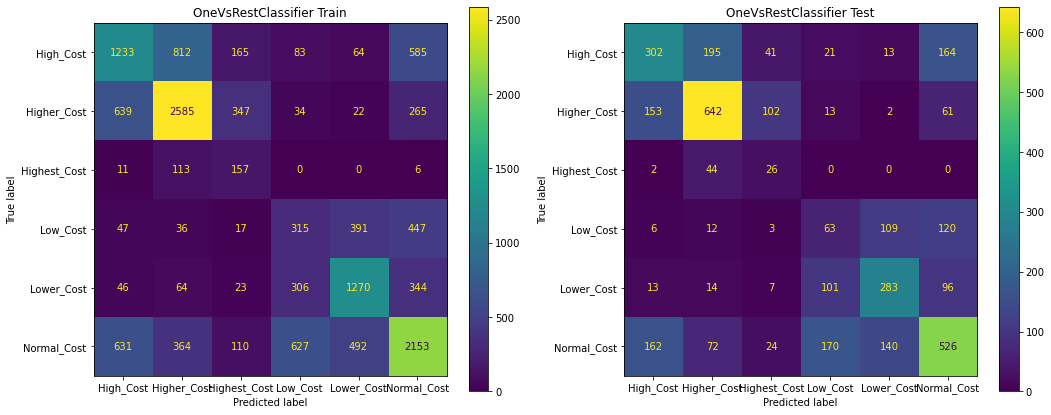

In [13]:
confusion_matrix(X_bin_train, X_bin_test, y_train, y_test, mapping, ovr)

In [14]:
# функция для проверки на переобучение по метрикам F1 micro и F1 macro
def check_overfitting(model, X_train, y_train, X_test, y_test):

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print('Проверка на переобучение :')

    print(f'F1 micro train: %.3f' %
          f1_score(y_train, y_pred_train, average='micro'))
    print(f'F1 micro test: %.3f' %
          f1_score(y_test, y_pred_test, average='micro'))
    print(
        f'Процент отличия F1 micro на test от train : %.3f' % (abs(
            f1_score(y_test, y_pred_test, average='micro') /
            f1_score(y_train, y_pred_train, average='micro') - 1) * 100), '%')

    print('-' * 100)

    print(f'F1 macro train: %.3f' %
          f1_score(y_train, y_pred_train, average='macro'))
    print(f'F1 macro test: %.3f' %
          f1_score(y_test, y_pred_test, average='macro'))

    print(
        f'Процент отличия F1 macro на test от train : %.3f' % (abs(
            f1_score(y_test, y_pred_test, average='macro') /
            f1_score(y_train, y_pred_train, average='macro') - 1) * 100), '%')

Проверка на переобучение

In [15]:
check_overfitting(ovr, X_bin_train, y_train, X_bin_test, y_test)

Проверка на переобучение :
F1 micro train: 0.521
F1 micro test: 0.498
Процент отличия F1 micro на test от train : 4.499 %
----------------------------------------------------------------------------------------------------
F1 macro train: 0.457
F1 macro test: 0.419
Процент отличия F1 macro на test от train : 8.352 %


**Вывод:** переобучения нет

## One-vs-one

Теперь использую one-vs-one

In [16]:
# baseline
ovo = OneVsOneClassifier(log_regression)
ovo.fit(X_bin_train, y_train)

y_pred = ovo.predict(X_bin_test)
y_prob = ovo.decision_function(X_bin_test)

In [17]:
metrics = metrics.append(
    get_metrics(y_bin_test = y_bin_test, y_test=y_test,
                y_pred=y_pred,
                y_prob=y_prob,
                name='OVO_Baseline',
                type_multi='ovo'))
metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,OVR_Baseline,0.832578,0.497569,0.414953,0.497569,0.443986,0.497569,0.419231,1.282172
0,OVO_Baseline,0.830750,0.471367,0.430936,0.471367,0.490017,0.471367,0.426778,1.876762


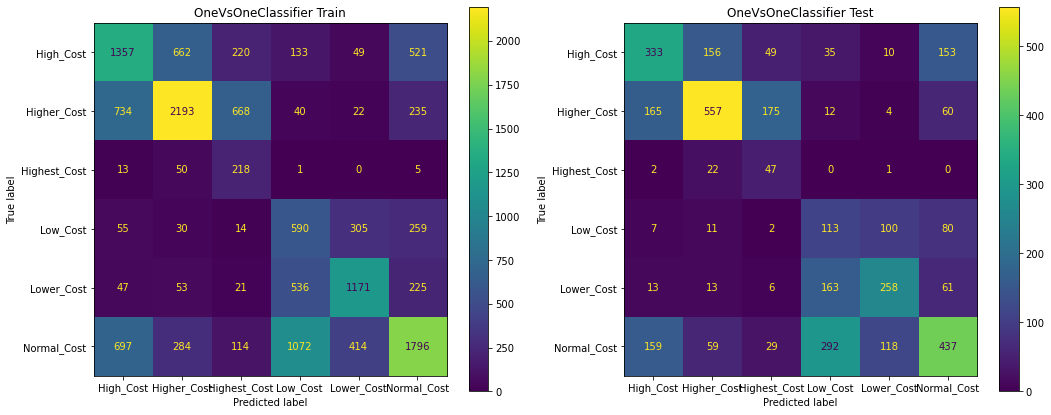

In [18]:
confusion_matrix(X_bin_train, X_bin_test, y_train, y_test, mapping, ovo)

Проверка на переобучение

In [19]:
check_overfitting(ovo, X_bin_train, y_train, X_bin_test, y_test)

Проверка на переобучение :
F1 micro train: 0.495
F1 micro test: 0.471
Процент отличия F1 micro на test от train : 4.736 %
----------------------------------------------------------------------------------------------------
F1 macro train: 0.459
F1 macro test: 0.427
Процент отличия F1 macro на test от train : 6.970 %


**Вывод:** переобучения нет

### Best params_GS - ovr

Далее необходимо подобрать наилучшие параметры

Нахожу для метода OVR наилучшией параметры с помощью GridSearch (т.к. немного данных и признаков)  и Optuna

In [20]:
def func_best_params(strategy: str) -> dict:
    parameters_grid = [{
    'estimator__penalty': ['l2',  None], 
    'estimator__C': np.logspace(-3, 3, num=10),
    'estimator__solver': ['newton-cg', 'saga', 'sag', 'lbfgs'],
    'estimator__max_iter': [500],
    'estimator__class_weight': ['balanced']
    }]
    
    log_regression = LogisticRegression()

    if strategy == 'ovr':
        model = OneVsRestClassifier(log_regression)

    elif strategy == 'ovo':
        model = OneVsOneClassifier(log_regression)

    else:
        return 'Error'

    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)

    # использую в качестве метрики log_loss
    grid_cv = GridSearchCV(model,
                           parameters_grid,
                           scoring='neg_log_loss',
                           cv=cv,
                           verbose=1,
                           n_jobs=-1)

    grid_cv.fit(X_bin_train, y_train)
    best_par = grid_cv.best_params_
    return best_par

In [19]:
best_parametrs_GS = func_best_params('ovo')
best_parametrs_GS = {
    key.split('estimator__')[1]: value
    for key, value in list(best_parametrs_GS.items())
}
best_parametrs_GS

Fitting 5 folds for each of 80 candidates, totalling 400 fits


{'C': 0.001,
 'class_weight': 'balanced',
 'max_iter': 500,
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [21]:
best_parametrs_GS = {
    'C': 0.001,
    'class_weight': 'balanced',
    'max_iter': 500,
    'penalty': 'l2',
    'solver': 'newton-cg'
}

In [22]:
log_reg = LogisticRegression(**best_parametrs_GS)
ovr_gs = OneVsRestClassifier(log_reg)
ovr_gs.fit(X_bin_train, y_train)

y_pred = ovr_gs.predict(X_bin_test)
y_prob = ovr_gs.predict_proba(X_bin_test)

In [23]:
metrics = metrics.append(
    get_metrics(y_bin_test=y_bin_test,
                y_test=y_test,
                y_pred=y_pred,
                y_prob=y_prob,
                name='OVR_GS', 
               type_multi = 'ovr'))

metrics.reset_index(drop=True)

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,OVR_Baseline,0.832578,0.497569,0.414953,0.497569,0.443986,0.497569,0.419231,1.282172
1,OVO_Baseline,0.830750,0.471367,0.430936,0.471367,0.490017,0.471367,0.426778,1.876762
2,OVR_GS,0.818940,0.488925,0.397486,0.488925,0.427269,0.488925,0.402621,1.423482


Проверка на переобучение

In [24]:
check_overfitting(ovr_gs, X_bin_train, y_train, X_bin_test, y_test)

Проверка на переобучение :
F1 micro train: 0.494
F1 micro test: 0.489
Процент отличия F1 micro на test от train : 1.120 %
----------------------------------------------------------------------------------------------------
F1 macro train: 0.413
F1 macro test: 0.403
Процент отличия F1 macro на test от train : 2.628 %


**Вывод:** переобучения нет

### Best params_optuna - ovr

Нахожу параметры через оptuna

In [25]:
import optuna

In [26]:
def objective(trial, X: pd.DataFrame, y: pd.DataFrame, N_FOLDS: int,
              random_state: int, strategy: str):

    parameters = {
        'penalty':
        trial.suggest_categorical('penalty', ['l2', 'none']),
        'C':
        trial.suggest_float('C', 0, 1),
        'class_weight':
        trial.suggest_categorical('class_weight', ['balanced']),
        'solver':
        trial.suggest_categorical('solver',
                                  ['newton-cg', 'lbfgs', 'sag', 'saga']),
        'max_iter':
        trial.suggest_categorical('max_iter', [1000]),
        'multi_class':
        trial.suggest_categorical('multi_class',
                                  ['auto', 'ovr', 'multinomial']),
        'random_state':
        trial.suggest_categorical('random_state', [RAND]),
        'n_jobs':
        trial.suggest_categorical('n_jobs', [-1])
    }

    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
    predicts = np.empty(N_FOLDS)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        log_regression = LogisticRegression(**parameters)

        if strategy == 'ovo':
            model = OneVsOneClassifier(log_regression)
            model.fit(X_train, y_train)
            y_score = model.decision_function(X_test)
            predicts[idx] = log_loss(y_test, y_score)

        elif strategy == 'ovr':
            model = OneVsRestClassifier(log_regression)
            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)
            predicts[idx] = log_loss(y_test, y_score)

        else:
            return 'Error'

    return np.mean(predicts)

In [26]:
study = optuna.create_study(direction="minimize", study_name="OVR_opt")
func = lambda trial: objective(
    trial, X_bin_train, y_train, N_FOLDS=N_FOLDS, random_state=RAND, strategy = 'ovr')

study.optimize(func, n_trials=10, show_progress_bar=True)

[I 2022-09-16 15:49:55,911] A new study created in memory with name: OVR_opt


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-09-16 15:58:37,568] Trial 0 finished with value: 1.2989349655241764 and parameters: {'penalty': 'none', 'C': 0.5335707810070264, 'class_weight': 'balanced', 'solver': 'sag', 'max_iter': 1000, 'multi_class': 'multinomial', 'random_state': 10, 'n_jobs': -1}. Best is trial 0 with value: 1.2989349655241764.
[I 2022-09-16 16:00:08,784] Trial 1 finished with value: 1.2823049232842743 and parameters: {'penalty': 'l2', 'C': 0.9845456662946779, 'class_weight': 'balanced', 'solver': 'newton-cg', 'max_iter': 1000, 'multi_class': 'auto', 'random_state': 10, 'n_jobs': -1}. Best is trial 1 with value: 1.2823049232842743.
[I 2022-09-16 16:02:18,514] Trial 2 finished with value: 1.2812288102483123 and parameters: {'penalty': 'l2', 'C': 0.9927476105377055, 'class_weight': 'balanced', 'solver': 'newton-cg', 'max_iter': 1000, 'multi_class': 'multinomial', 'random_state': 10, 'n_jobs': -1}. Best is trial 2 with value: 1.2812288102483123.
[I 2022-09-16 16:09:07,851] Trial 3 finished with value: 1.3

In [27]:
best_params_lr = study.best_params
best_params_lr

{'penalty': 'l2',
 'C': 0.9927476105377055,
 'class_weight': 'balanced',
 'solver': 'newton-cg',
 'max_iter': 1000,
 'multi_class': 'multinomial',
 'random_state': 10,
 'n_jobs': -1}

Далее необходимо обучить модель на лучших параметрах

In [27]:
best_params_lr = {
    'penalty': 'l2',
    'C': 0.9927476105377055,
    'class_weight': 'balanced',
    'solver': 'newton-cg',
    'max_iter': 1000,
    'multi_class': 'multinomial',
    'random_state': 10,
    'n_jobs': -1
}

In [28]:
log_reg = LogisticRegression(**best_params_lr)
ovr_optuna = OneVsRestClassifier(log_reg)
ovr_optuna.fit(X_bin_train, y_train)

y_pred = ovr_optuna.predict(X_bin_test)
y_prob = ovr_optuna.predict_proba(X_bin_test)

In [29]:
metrics = metrics.append(
    get_metrics(y_bin_test=y_bin_test,
                y_test=y_test,
                y_pred=y_pred,
                y_prob=y_prob,
                name='OVR_optuna',
                type_multi='ovr'))

metrics.reset_index(drop=True)

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,OVR_Baseline,0.832578,0.497569,0.414953,0.497569,0.443986,0.497569,0.419231,1.282172
1,OVO_Baseline,0.830750,0.471367,0.430936,0.471367,0.490017,0.471367,0.426778,1.876762
2,OVR_GS,0.818940,0.488925,0.397486,0.488925,0.427269,0.488925,0.402621,1.423482
3,OVR_optuna,0.829195,0.500540,0.414026,0.500540,0.439475,0.500540,0.416879,1.279775


Проверка на переобучение

In [30]:
check_overfitting(ovr_optuna, X_bin_train, y_train, X_bin_test, y_test)

Проверка на переобучение :
F1 micro train: 0.527
F1 micro test: 0.501
Процент отличия F1 micro на test от train : 4.976 %
----------------------------------------------------------------------------------------------------
F1 macro train: 0.462
F1 macro test: 0.417
Процент отличия F1 macro на test от train : 9.681 %


**Вывод:** переобучения нет

## RandomForest

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
# baseline
# использую бинаризованные данные
rand_forest = RandomForestClassifier(random_state=RAND, class_weight='balanced')
rand_forest.fit(X_bin_train, y_train)

y_pred = rand_forest.predict(X_bin_test)
y_prob = rand_forest.predict_proba(X_bin_test)

In [33]:
metrics = metrics.append(
    get_metrics(y_bin_test=y_bin_test,
                y_test=y_test,
                y_pred=y_pred,
                y_prob=y_prob,
                name='RFores_base',
                type_multi=None))
metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,OVR_Baseline,0.832578,0.497569,0.414953,0.497569,0.443986,0.497569,0.419231,1.282172
0,OVO_Baseline,0.830750,0.471367,0.430936,0.471367,0.490017,0.471367,0.426778,1.876762
0,OVR_GS,0.818940,0.488925,0.397486,0.488925,0.427269,0.488925,0.402621,1.423482
0,OVR_optuna,0.829195,0.500540,0.414026,0.500540,0.439475,0.500540,0.416879,1.279775
0,RFores_base,0.828637,0.552404,0.452836,0.552404,0.415455,0.552404,0.418876,1.514626


Проверка на переобучение

In [34]:
check_overfitting(rand_forest, X_bin_train, y_train, X_bin_test, y_test)

Проверка на переобучение :
F1 micro train: 0.971
F1 micro test: 0.552
Процент отличия F1 micro на test от train : 43.131 %
----------------------------------------------------------------------------------------------------
F1 macro train: 0.958
F1 macro test: 0.419
Процент отличия F1 macro на test от train : 56.271 %


**Вывод:** есть переобучение алгоритма на базовых параметрах

### Best paprams_optuna - random forest

In [35]:
def objective_rf(trial, X: pd.DataFrame, y: pd.DataFrame, N_FOLDS: int,
                 random_state: int):

    parameters = {
        'n_estimators':
        trial.suggest_categorical('n_estimators', [1000]),
        'criterion':
        trial.suggest_categorical('criterion',
                                  ['gini', 'entropy', 'log_loss']),
        'max_depth':
        trial.suggest_int('max_depth', 3, 12, step=1),
        'min_samples_split':
        trial.suggest_categorical('min_samples_split', [500]),
        'max_features':
        trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'bootstrap':
        trial.suggest_categorical('bootstrap', [True]),
        'n_jobs':
        -1,
        'random_state':
        trial.suggest_categorical('random_state', [RAND]),
        'class_weight':
        trial.suggest_categorical('class_weight', ['balanced_subsample']),
        'max_samples':
        trial.suggest_categorical('max_samples', [0.6, 0.7, 0.8, 0.9, 1.0])
    }

    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
    predicts = np.empty(N_FOLDS)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        rf = RandomForestClassifier(**parameters)

        rf.fit(X_train, y_train)

        y_score = rf.predict_proba(X_test)

        predicts[idx] = log_loss(y_test, y_score)

    return np.mean(predicts)

In [37]:
study_rf = optuna.create_study(direction="minimize", study_name="rforest")
func_rf = lambda trial: objective_rf(
    trial, X_bin_train, y_train, N_FOLDS=N_FOLDS, random_state=RAND)

study_rf.optimize(func_rf, n_trials=10, show_progress_bar=True)

[I 2022-09-16 17:30:56,657] A new study created in memory with name: rforest


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-09-16 17:31:08,733] Trial 0 finished with value: 1.484245396153701 and parameters: {'n_estimators': 1000, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 500, 'max_features': 'auto', 'bootstrap': True, 'random_state': 10, 'class_weight': 'balanced_subsample', 'max_samples': 0.7}. Best is trial 0 with value: 1.484245396153701.
[I 2022-09-16 17:31:20,667] Trial 1 finished with value: 1.4701807435832852 and parameters: {'n_estimators': 1000, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 500, 'max_features': 'log2', 'bootstrap': True, 'random_state': 10, 'class_weight': 'balanced_subsample', 'max_samples': 0.7}. Best is trial 1 with value: 1.4701807435832852.
[I 2022-09-16 17:31:35,223] Trial 2 finished with value: 1.3625594864694626 and parameters: {'n_estimators': 1000, 'criterion': 'log_loss', 'max_depth': 9, 'min_samples_split': 500, 'max_features': 'auto', 'bootstrap': True, 'random_state': 10, 'class_weight': 'balanced_subsample', 'max_samples': 1.

In [38]:
best_params_rf = study_rf.best_params
best_params_rf

{'n_estimators': 1000,
 'criterion': 'log_loss',
 'max_depth': 12,
 'min_samples_split': 500,
 'max_features': 'auto',
 'bootstrap': True,
 'random_state': 10,
 'class_weight': 'balanced_subsample',
 'max_samples': 0.9}

In [36]:
best_params_rf = {
    'n_estimators': 1000,
    'criterion': 'log_loss',
    'max_depth': 12,
    'min_samples_split': 500,
    'max_features': 'auto',
    'bootstrap': True,
    'random_state': 10,
    'class_weight': 'balanced_subsample',
    'max_samples': 0.9
}

Обучение Randomforest на best_params

In [37]:
rand_forest = RandomForestClassifier(**best_params_rf)
rand_forest.fit(X_bin_train, y_train)

y_pred = rand_forest.predict(X_bin_test)
y_prob = rand_forest.predict_proba(X_bin_test)

In [38]:
metrics = metrics.append(
    get_metrics(y_bin_test=y_bin_test,
                y_test=y_test,
                y_pred=y_pred,
                y_prob=y_prob,
                name='RandomForest_optuna',
                type_multi=None))

metrics.reset_index(drop=True)

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,OVR_Baseline,0.832578,0.497569,0.414953,0.497569,0.443986,0.497569,0.419231,1.282172
1,OVO_Baseline,0.830750,0.471367,0.430936,0.471367,0.490017,0.471367,0.426778,1.876762
2,OVR_GS,0.818940,0.488925,0.397486,0.488925,0.427269,0.488925,0.402621,1.423482
3,OVR_optuna,0.829195,0.500540,0.414026,0.500540,0.439475,0.500540,0.416879,1.279775
4,RFores_base,0.828637,0.552404,0.452836,0.552404,0.415455,0.552404,0.418876,1.514626
5,RandomForest_optuna,0.839886,0.447056,0.420825,0.447056,0.492643,0.447056,0.411246,1.331717


Проверка на переобучение

In [39]:
check_overfitting(rand_forest, X_bin_train, y_train, X_bin_test, y_test)

Проверка на переобучение :
F1 micro train: 0.458
F1 micro test: 0.447
Процент отличия F1 micro на test от train : 2.487 %
----------------------------------------------------------------------------------------------------
F1 macro train: 0.424
F1 macro test: 0.411
Процент отличия F1 macro на test от train : 3.071 %


**Вывод:** переобучения нет

## LightGMB

In [40]:
from lightgbm import LGBMClassifier

In [41]:
# использую категориальные данные, т.к. LGBM может работать с ними
X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    random_state=RAND_1)
eval_set = [(X_val, y_val)]

In [42]:
clf_LGBM = LGBMClassifier(random_state=RAND, is_unbalance=True)
clf_LGBM.fit(X_train_,
        y_train_,
        eval_set=eval_set,
        early_stopping_rounds=20)

y_pred = clf_LGBM.predict(X_test)
y_prob = clf_LGBM.predict_proba(X_test)

[1]	valid_0's multi_logloss: 1.49185
[2]	valid_0's multi_logloss: 1.41869
[3]	valid_0's multi_logloss: 1.36217
[4]	valid_0's multi_logloss: 1.31697
[5]	valid_0's multi_logloss: 1.28084
[6]	valid_0's multi_logloss: 1.25123
[7]	valid_0's multi_logloss: 1.22514
[8]	valid_0's multi_logloss: 1.20461
[9]	valid_0's multi_logloss: 1.1865
[10]	valid_0's multi_logloss: 1.17097
[11]	valid_0's multi_logloss: 1.15799
[12]	valid_0's multi_logloss: 1.14758
[13]	valid_0's multi_logloss: 1.13785
[14]	valid_0's multi_logloss: 1.12954
[15]	valid_0's multi_logloss: 1.12282
[16]	valid_0's multi_logloss: 1.11637
[17]	valid_0's multi_logloss: 1.11054
[18]	valid_0's multi_logloss: 1.10576
[19]	valid_0's multi_logloss: 1.10155
[20]	valid_0's multi_logloss: 1.09753
[21]	valid_0's multi_logloss: 1.0942
[22]	valid_0's multi_logloss: 1.09126
[23]	valid_0's multi_logloss: 1.08881
[24]	valid_0's multi_logloss: 1.08569
[25]	valid_0's multi_logloss: 1.08296
[26]	valid_0's multi_logloss: 1.08238
[27]	valid_0's multi_lo

In [43]:
metrics = metrics.append(
    get_metrics(y_bin_test=y_bin_test,
                y_test=y_test,
                y_pred=y_pred,
                y_prob=y_prob,
                name='LGBM_base',
                type_multi=None))

metrics.reset_index(drop=True)

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,OVR_Baseline,0.832578,0.497569,0.414953,0.497569,0.443986,0.497569,0.419231,1.282172
1,OVO_Baseline,0.830750,0.471367,0.430936,0.471367,0.490017,0.471367,0.426778,1.876762
2,OVR_GS,0.818940,0.488925,0.397486,0.488925,0.427269,0.488925,0.402621,1.423482
3,OVR_optuna,0.829195,0.500540,0.414026,0.500540,0.439475,0.500540,0.416879,1.279775
4,RFores_base,0.828637,0.552404,0.452836,0.552404,0.415455,0.552404,0.418876,1.514626
5,RandomForest_optuna,0.839886,0.447056,0.420825,0.447056,0.492643,0.447056,0.411246,1.331717
6,LGBM_base,0.849683,0.582388,0.485407,0.582388,0.436131,0.582388,0.429826,1.081487


Проверка на переобучение

In [44]:
check_overfitting(clf_LGBM, X_train, y_train, X_test, y_test)

Проверка на переобучение :
F1 micro train: 0.647
F1 micro test: 0.582
Процент отличия F1 micro на test от train : 10.022 %
----------------------------------------------------------------------------------------------------
F1 macro train: 0.563
F1 macro test: 0.430
Процент отличия F1 macro на test от train : 23.679 %


**Вывод:** есть переобучения алгоритма на базовых параметрах

### Best params_optuna - lgbm

Подбор параметров через optuna

Предварительно подбираю оптимальное количество деревьев с помощью GridSearch

In [48]:
param_grid = [{'n_estimators': [1500,1600,1700], 'max_depth':[5]}]

lgbm_class = LGBMClassifier(class_weight='balanced', random_state=RAND)
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
grid_cv_l = GridSearchCV(lgbm_class, param_grid, cv=cv, verbose=1, n_jobs=-1)
grid_cv_l.fit(X_train, y_train)
best_par = grid_cv_l.best_params_
best_par

Fitting 5 folds for each of 3 candidates, totalling 15 fits


{'max_depth': 5, 'n_estimators': 1600}

In [46]:
def objective_lgbm(trial, X, y, N_FOLDS, random_state=20):

    parameters = {
        'n_estimators':
        trial.suggest_categorical('n_estimators', [1500]),
        "learning_rate":
        trial.suggest_float("learning_rate", 0.001, 0.5, log=True),
        "num_leaves":
        trial.suggest_int("num_leaves", 5, 20, step=2),
        'min_data_in_leaf':
        trial.suggest_int("min_data_in_leaf", 30, 60, step=2),
        'max_depth':
        trial.suggest_int('max_depth', 2,4, step=1),
        'boosting_type':
        trial.suggest_categorical('boosting_type', ['gbdt', 'goss', 'dart']),
        'bagging_fraction':
        trial.suggest_categorical('bagging_fraction', [0.6, 0.7, 0.8, 0.9]),
        'feature_fraction':
        trial.suggest_categorical('feature_fraction', [0.6, 0.7, 0.8, 0.9]),
        "lambda_l1":
        trial.suggest_int("lambda_l1", 0, 50),
        "lambda_l2":
        trial.suggest_int("lambda_l2", 0, 50),
        'is_unbalance':
        trial.suggest_categorical('is_unbalance', [True]),
        'random_state':
        random_state,
        'objective':
        trial.suggest_categorical('objective', ['multiclass']),
        'num_class':
        trial.suggest_categorical('num_class', [6]),
        'metric':
        trial.suggest_categorical('metric', ['multi_logloss'])
    }

    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
    predicts = np.empty(N_FOLDS)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        lgbm_class = LGBMClassifier(**parameters)

        lgbm_class.fit(X_train,
                       y_train,
                       eval_set=[(X_test, y_test)],
                       eval_metric="multi_logloss",
                       early_stopping_rounds=20,
                       verbose=0)

        y_score = lgbm_class.predict_proba(X_test)

        predicts[idx] = log_loss(y_test, y_score)

    return np.mean(predicts)

In [47]:
study_lgbm = optuna.create_study(direction="minimize", study_name="lgbm")
func_lgbm = lambda trial: objective_lgbm(
    trial, X_train, y_train, N_FOLDS=N_FOLDS, random_state=RAND_1)

study_lgbm.optimize(func_lgbm, n_trials=50, show_progress_bar=True)

[I 2022-09-16 17:50:22,927] A new study created in memory with name: lgbm


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=11, reg_alpha=0.0 will be ignored. Current value: lambda_l1=11
[LightGBM] [Warning] lambda_l2 is set=11, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=11, reg_alpha=0.0 will be ignored

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] lambda_l2 is set=49, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49
[I 2022-09-16 17:52:48,358] Trial 2 finished with value: 1.145232322259154 and parameters: {'n_estimators': 1500, 'learning_rate': 0.010042483538566625, 'num_leaves': 15, 'min_data_in_leaf': 44, 'max_depth': 3, 'boosting_type': 'dart', 'bagging_fraction': 0.7, 'feature_fraction': 0.7, 'lambda_l1': 25, 'lambda_l2': 49, 'is_unbalance': True, 'objective': 'multiclass', 'num_class': 6, 'metric': 'multi_logloss'}. Best is trial 0 with 

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=27, reg_alpha=0.0 will be ignored. Current value: lambda_l1=27
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=27, reg_alpha=0.0 will be ignored. 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[I 2022-09-16 17:55:26,193] Trial 7 finished with value: 1.0905769621936439 and parameters: {'n_estimators': 1500, 'learning_rate': 0.0053100221250012465, 'num_leaves': 9, 'min_data_in_leaf': 54, 'max_depth': 3, 'boosting_type': 'goss', 'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'lambda_l1': 18, 'lambda_l2': 3, 'is_unbalance': True, 'objective': 'multiclass', 'num_class': 6, 'metric': 'multi_logloss'}. Best is trial 0 with va

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. C

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=11, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11
[I 2022-09-16 17:56:42,861] Trial 12 finished with value: 1.0849570168657552 and parameters: {'n_estimators': 1500, 'learning_rate': 0.11244159395683234, 'num_leaves': 11, 'min_data_in_leaf': 48, 'max_depth': 3, 'boosting_type': 'gbdt', 'bagging_fraction': 0.7, 'feature_fraction': 0.9, 'lambda_l1': 1, 'lambda_l2': 11, 'is_unbalance': True, 'objective': 'multiclass', 'num_class': 6, 'metric': 'multi_logloss'}. Best is trial 0 with va

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] lambda_l2 is set=23, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. C

[I 2022-09-16 17:57:25,570] Trial 17 finished with value: 1.0972466551818012 and parameters: {'n_estimators': 1500, 'learning_rate': 0.0077800979083545935, 'num_leaves': 7, 'min_data_in_leaf': 58, 'max_depth': 4, 'boosting_type': 'gbdt', 'bagging_fraction': 0.9, 'feature_fraction': 0.6, 'lambda_l1': 27, 'lambda_l2': 32, 'is_unbalance': True, 'objective': 'multiclass', 'num_class': 6, 'metric': 'multi_logloss'}. Best is trial 16 with value: 1.0796834975824523.
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] lambda_l2 is set=32, reg_lambda=0.0 will be ignored

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] lambda_l2 is set=28, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored

[I 2022-09-16 18:00:37,610] Trial 22 finished with value: 1.0790823939247611 and parameters: {'n_estimators': 1500, 'learning_rate': 0.014111454288114418, 'num_leaves': 11, 'min_data_in_leaf': 52, 'max_depth': 4, 'boosting_type': 'gbdt', 'bagging_fraction': 0.9, 'feature_fraction': 0.6, 'lambda_l1': 5, 'lambda_l2': 19, 'is_unbalance': True, 'objective': 'multiclass', 'num_class': 6, 'metric': 'multi_logloss'}. Best is trial 22 with value: 1.0790823939247611.
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=17, reg_lambda=0.0 will be ignored. C

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=13, reg_alpha=0.0 will be ignored. Current value: lambda_l1=13
[LightGBM] [Warning] lambda_l2 is set=6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=13, reg_alpha=0.0 will be ignored. 

[I 2022-09-16 18:01:32,315] Trial 27 finished with value: 1.0882162300148623 and parameters: {'n_estimators': 1500, 'learning_rate': 0.0164629878487419, 'num_leaves': 19, 'min_data_in_leaf': 56, 'max_depth': 3, 'boosting_type': 'goss', 'bagging_fraction': 0.9, 'feature_fraction': 0.6, 'lambda_l1': 22, 'lambda_l2': 13, 'is_unbalance': True, 'objective': 'multiclass', 'num_class': 6, 'metric': 'multi_logloss'}. Best is trial 22 with value: 1.0790823939247611.
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=32, reg_alpha=0.0 will be ignored. Current value: lambda_l1=32
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. 

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. C

[I 2022-09-16 18:04:16,494] Trial 32 finished with value: 1.0792927478486714 and parameters: {'n_estimators': 1500, 'learning_rate': 0.01525390456474152, 'num_leaves': 13, 'min_data_in_leaf': 46, 'max_depth': 4, 'boosting_type': 'gbdt', 'bagging_fraction': 0.9, 'feature_fraction': 0.6, 'lambda_l1': 4, 'lambda_l2': 19, 'is_unbalance': True, 'objective': 'multiclass', 'num_class': 6, 'metric': 'multi_logloss'}. Best is trial 22 with value: 1.0790823939247611.
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=17, reg_lambda=0.0 will be ignored. 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=21, reg_alpha=0.0 will be ignored. Current value: lambda_l1=21
[LightGBM] [Warning] lambda_l2 is set=23, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=21, reg_alpha=0.0 will be ignored

[I 2022-09-16 18:07:13,450] Trial 37 finished with value: 1.079051317514359 and parameters: {'n_estimators': 1500, 'learning_rate': 0.011769529911517002, 'num_leaves': 17, 'min_data_in_leaf': 52, 'max_depth': 4, 'boosting_type': 'gbdt', 'bagging_fraction': 0.9, 'feature_fraction': 0.7, 'lambda_l1': 0, 'lambda_l2': 7, 'is_unbalance': True, 'objective': 'multiclass', 'num_class': 6, 'metric': 'multi_logloss'}. Best is trial 37 with value: 1.079051317514359.
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Curre

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=46, reg_alpha=0.0 will be ignored. Current value: lambda_l1=46
[LightGBM] [Warning] lambda_l2 is set=37, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=46, reg_alpha=0.0 will be ignored

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] lambda_l2 is set=14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. C

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=21, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21
[I 2022-09-16 18:10:42,081] Trial 45 finished with value: 1.1005905533781 and parameters: {'n_estimators': 1500, 'learning_rate': 0.011274246147739923, 'num_leaves': 17, 'min_data_in_leaf': 60, 'max_depth': 4, 'boosting_type': 'dart', 'bagging_fraction': 0.9, 'feature_fraction': 0.6, 'lambda_l1': 2, 'lambda_l2': 21, 'is_unbalance': True, 'objective': 'multiclass', 'num_class': 6, 'metric': 'multi_logloss'}. Best is trial 37 with val

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. C

In [49]:
best_params_lgbm = study_lgbm.best_params

In [49]:
best_params_lgbm ={'n_estimators': 1500,
 'learning_rate': 0.08705364428070803,
 'num_leaves': 15,
 'min_data_in_leaf': 60,
 'max_depth': 4,
 'boosting_type': 'gbdt',
 'bagging_fraction': 0.6,
 'feature_fraction': 0.6,
 'lambda_l1': 14,
 'lambda_l2': 24,
 'is_unbalance': True,
 'objective': 'multiclass',
 'num_class': 6,
 'metric': 'multi_logloss'}


Обучаю lgbm на подобранных параметрах

In [50]:
clf_LGBM = LGBMClassifier(**best_params_lgbm, random_state=RAND_2)
clf_LGBM.fit(X_train_,
             y_train_,
             eval_set=eval_set,
             eval_metric="multi_logloss",
             early_stopping_rounds=30,
             verbose=0)

y_pred = clf_LGBM.predict(X_test)
y_prob = clf_LGBM.predict_proba(X_test)

In [51]:
metrics = metrics.append(
    get_metrics(y_bin_test=y_bin_test,
                y_test=y_test,
                y_pred=y_pred,
                y_prob=y_prob,
                name='LGBM_optuna',
                type_multi=None))

metrics.reset_index(drop=True)

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,OVR_Baseline,0.832578,0.497569,0.414953,0.497569,0.443986,0.497569,0.419231,1.282172
1,OVO_Baseline,0.830750,0.471367,0.430936,0.471367,0.490017,0.471367,0.426778,1.876762
2,OVR_GS,0.818940,0.488925,0.397486,0.488925,0.427269,0.488925,0.402621,1.423482
3,OVR_optuna,0.829195,0.500540,0.414026,0.500540,0.439475,0.500540,0.416879,1.279775
4,RFores_base,0.828637,0.552404,0.452836,0.552404,0.415455,0.552404,0.418876,1.514626
5,RandomForest_optuna,0.839886,0.447056,0.420825,0.447056,0.492643,0.447056,0.411246,1.331717
6,LGBM_base,0.849683,0.582388,0.485407,0.582388,0.436131,0.582388,0.429826,1.081487
7,LGBM_optuna,0.851976,0.577256,0.483994,0.577256,0.417885,0.577256,0.405507,1.075046


Проверка на переобучние

In [52]:
check_overfitting(clf_LGBM, X_train, y_train, X_test, y_test)

Проверка на переобучение :
F1 micro train: 0.601
F1 micro test: 0.577
Процент отличия F1 micro на test от train : 3.927 %
----------------------------------------------------------------------------------------------------
F1 macro train: 0.448
F1 macro test: 0.406
Процент отличия F1 macro на test от train : 9.404 %


**Вывод:** нет переобучения с подобранными параметрами

## CatBoost

In [53]:
from catboost import CatBoostClassifier, Pool

In [54]:
# Baseline
# использую те же категориальнные данные, что и для LGBM
clf_CatBoost = CatBoostClassifier(random_state=RAND, auto_class_weights='Balanced')
clf_CatBoost.fit(X_train_,
                 y_train_,
                 eval_set=eval_set,
                 verbose=False,
                 early_stopping_rounds=100,
                 cat_features=cat_feat)

y_pred = clf_CatBoost.predict(X_test)
y_prob = clf_CatBoost.predict_proba(X_test)

In [55]:
metrics = metrics.append(
    get_metrics(y_bin_test=y_bin_test,
                y_test=y_test,
                y_pred=y_pred,
                y_prob=y_prob,
                name='CatBoost_base',
                type_multi=None))

metrics.reset_index(drop=True)

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,OVR_Baseline,0.832578,0.497569,0.414953,0.497569,0.443986,0.497569,0.419231,1.282172
1,OVO_Baseline,0.830750,0.471367,0.430936,0.471367,0.490017,0.471367,0.426778,1.876762
2,OVR_GS,0.818940,0.488925,0.397486,0.488925,0.427269,0.488925,0.402621,1.423482
3,OVR_optuna,0.829195,0.500540,0.414026,0.500540,0.439475,0.500540,0.416879,1.279775
4,RFores_base,0.828637,0.552404,0.452836,0.552404,0.415455,0.552404,0.418876,1.514626
5,RandomForest_optuna,0.839886,0.447056,0.420825,0.447056,0.492643,0.447056,0.411246,1.331717
6,LGBM_base,0.849683,0.582388,0.485407,0.582388,0.436131,0.582388,0.429826,1.081487
7,LGBM_optuna,0.851976,0.577256,0.483994,0.577256,0.417885,0.577256,0.405507,1.075046
8,CatBoost_base,0.842852,0.483252,0.437492,0.483252,0.481766,0.483252,0.432042,1.217663


Проверка на переобучение

In [56]:
check_overfitting(clf_CatBoost, X_train, y_train, X_test, y_test)

Проверка на переобучение :
F1 micro train: 0.524
F1 micro test: 0.483
Процент отличия F1 micro на test от train : 7.749 %
----------------------------------------------------------------------------------------------------
F1 macro train: 0.484
F1 macro test: 0.432
Процент отличия F1 macro на test от train : 10.737 %


**Вывод:** переобучения нет

### Best params_optuna - CatBoost

Предварительно подбираю количество деревьев, функцию потерь, скорость обучения

In [58]:
param_grid_cat = [{"n_estimators": [800, 1000, 1500]}]

cat_class = CatBoostClassifier(random_state=RAND,
                               loss_function='MultiClass',
                               auto_class_weights='Balanced')
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RAND)
grid_cv_cat = GridSearchCV(cat_class,
                           param_grid_cat,
                           cv=cv,
                           verbose=1,
                           n_jobs=-1)
grid_cv_cat.fit(X_train, y_train, cat_features=cat_feat)
best_par_cat = grid_cv_cat.best_params_
best_par_cat

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Learning rate set to 0.050541
0:	learn: 1.7555197	total: 60.5ms	remaining: 2m 1s
1:	learn: 1.7208881	total: 139ms	remaining: 2m 19s
2:	learn: 1.6911056	total: 199ms	remaining: 2m 12s
3:	learn: 1.6633090	total: 271ms	remaining: 2m 15s
4:	learn: 1.6374796	total: 333ms	remaining: 2m 13s
5:	learn: 1.6159957	total: 394ms	remaining: 2m 11s
6:	learn: 1.5921467	total: 453ms	remaining: 2m 8s
7:	learn: 1.5685034	total: 514ms	remaining: 2m 7s
8:	learn: 1.5462288	total: 574ms	remaining: 2m 7s
9:	learn: 1.5254473	total: 632ms	remaining: 2m 5s
10:	learn: 1.5052979	total: 693ms	remaining: 2m 5s
11:	learn: 1.4902344	total: 746ms	remaining: 2m 3s
12:	learn: 1.4741053	total: 828ms	remaining: 2m 6s
13:	learn: 1.4607210	total: 882ms	remaining: 2m 5s
14:	learn: 1.4461410	total: 939ms	remaining: 2m 4s
15:	learn: 1.4326523	total: 1s	remaining: 2m 4s
16:	learn: 1.4179247	total: 1.07s	remaining: 2m 4s
17:	learn: 1.4065526	total: 1.14s	remaining: 2m 6s

161:	learn: 1.1180837	total: 10.3s	remaining: 1m 57s
162:	learn: 1.1177966	total: 10.4s	remaining: 1m 57s
163:	learn: 1.1162956	total: 10.5s	remaining: 1m 57s
164:	learn: 1.1158522	total: 10.5s	remaining: 1m 57s
165:	learn: 1.1152427	total: 10.6s	remaining: 1m 57s
166:	learn: 1.1147723	total: 10.6s	remaining: 1m 56s
167:	learn: 1.1138862	total: 10.7s	remaining: 1m 56s
168:	learn: 1.1135963	total: 10.8s	remaining: 1m 56s
169:	learn: 1.1134099	total: 10.8s	remaining: 1m 56s
170:	learn: 1.1124174	total: 10.9s	remaining: 1m 56s
171:	learn: 1.1116282	total: 11s	remaining: 1m 56s
172:	learn: 1.1112966	total: 11s	remaining: 1m 56s
173:	learn: 1.1108069	total: 11.1s	remaining: 1m 56s
174:	learn: 1.1091468	total: 11.2s	remaining: 1m 56s
175:	learn: 1.1081363	total: 11.3s	remaining: 1m 56s
176:	learn: 1.1077752	total: 11.3s	remaining: 1m 56s
177:	learn: 1.1075415	total: 11.4s	remaining: 1m 56s
178:	learn: 1.1066330	total: 11.4s	remaining: 1m 56s
179:	learn: 1.1056867	total: 11.5s	remaining: 1m 5

318:	learn: 1.0127798	total: 20.6s	remaining: 1m 48s
319:	learn: 1.0122775	total: 20.7s	remaining: 1m 48s
320:	learn: 1.0117900	total: 20.8s	remaining: 1m 48s
321:	learn: 1.0112141	total: 20.8s	remaining: 1m 48s
322:	learn: 1.0110108	total: 20.9s	remaining: 1m 48s
323:	learn: 1.0105800	total: 21s	remaining: 1m 48s
324:	learn: 1.0094733	total: 21s	remaining: 1m 48s
325:	learn: 1.0090378	total: 21.1s	remaining: 1m 48s
326:	learn: 1.0084430	total: 21.2s	remaining: 1m 48s
327:	learn: 1.0081171	total: 21.2s	remaining: 1m 48s
328:	learn: 1.0078020	total: 21.3s	remaining: 1m 48s
329:	learn: 1.0070882	total: 21.4s	remaining: 1m 48s
330:	learn: 1.0062739	total: 21.4s	remaining: 1m 48s
331:	learn: 1.0058267	total: 21.5s	remaining: 1m 47s
332:	learn: 1.0054057	total: 21.6s	remaining: 1m 47s
333:	learn: 1.0049840	total: 21.6s	remaining: 1m 47s
334:	learn: 1.0045131	total: 21.7s	remaining: 1m 47s
335:	learn: 1.0040072	total: 21.8s	remaining: 1m 47s
336:	learn: 1.0036012	total: 21.8s	remaining: 1m 4

476:	learn: 0.9499375	total: 31s	remaining: 1m 39s
477:	learn: 0.9495044	total: 31.1s	remaining: 1m 38s
478:	learn: 0.9491634	total: 31.2s	remaining: 1m 38s
479:	learn: 0.9488103	total: 31.3s	remaining: 1m 38s
480:	learn: 0.9484330	total: 31.3s	remaining: 1m 38s
481:	learn: 0.9483793	total: 31.4s	remaining: 1m 38s
482:	learn: 0.9477995	total: 31.5s	remaining: 1m 38s
483:	learn: 0.9474152	total: 31.5s	remaining: 1m 38s
484:	learn: 0.9472534	total: 31.6s	remaining: 1m 38s
485:	learn: 0.9470967	total: 31.6s	remaining: 1m 38s
486:	learn: 0.9467510	total: 31.7s	remaining: 1m 38s
487:	learn: 0.9465312	total: 31.8s	remaining: 1m 38s
488:	learn: 0.9462876	total: 31.8s	remaining: 1m 38s
489:	learn: 0.9459259	total: 31.9s	remaining: 1m 38s
490:	learn: 0.9456599	total: 32s	remaining: 1m 38s
491:	learn: 0.9455061	total: 32s	remaining: 1m 38s
492:	learn: 0.9453210	total: 32.1s	remaining: 1m 38s
493:	learn: 0.9449508	total: 32.1s	remaining: 1m 37s
494:	learn: 0.9446220	total: 32.2s	remaining: 1m 37s

634:	learn: 0.9006844	total: 41.4s	remaining: 1m 28s
635:	learn: 0.9003047	total: 41.5s	remaining: 1m 28s
636:	learn: 0.9000907	total: 41.5s	remaining: 1m 28s
637:	learn: 0.8999997	total: 41.6s	remaining: 1m 28s
638:	learn: 0.8998585	total: 41.7s	remaining: 1m 28s
639:	learn: 0.8997858	total: 41.8s	remaining: 1m 28s
640:	learn: 0.8997034	total: 41.9s	remaining: 1m 28s
641:	learn: 0.8995444	total: 42s	remaining: 1m 28s
642:	learn: 0.8992804	total: 42s	remaining: 1m 28s
643:	learn: 0.8985994	total: 42.1s	remaining: 1m 28s
644:	learn: 0.8984307	total: 42.2s	remaining: 1m 28s
645:	learn: 0.8981330	total: 42.3s	remaining: 1m 28s
646:	learn: 0.8977625	total: 42.3s	remaining: 1m 28s
647:	learn: 0.8976116	total: 42.4s	remaining: 1m 28s
648:	learn: 0.8972409	total: 42.5s	remaining: 1m 28s
649:	learn: 0.8971190	total: 42.5s	remaining: 1m 28s
650:	learn: 0.8965508	total: 42.6s	remaining: 1m 28s
651:	learn: 0.8958766	total: 42.7s	remaining: 1m 28s
652:	learn: 0.8957670	total: 42.8s	remaining: 1m 2

790:	learn: 0.8604434	total: 51.7s	remaining: 1m 19s
791:	learn: 0.8602780	total: 51.8s	remaining: 1m 18s
792:	learn: 0.8599911	total: 51.9s	remaining: 1m 18s
793:	learn: 0.8597621	total: 51.9s	remaining: 1m 18s
794:	learn: 0.8594612	total: 52s	remaining: 1m 18s
795:	learn: 0.8591499	total: 52.1s	remaining: 1m 18s
796:	learn: 0.8587517	total: 52.1s	remaining: 1m 18s
797:	learn: 0.8585508	total: 52.2s	remaining: 1m 18s
798:	learn: 0.8580520	total: 52.3s	remaining: 1m 18s
799:	learn: 0.8579252	total: 52.3s	remaining: 1m 18s
800:	learn: 0.8576976	total: 52.4s	remaining: 1m 18s
801:	learn: 0.8575175	total: 52.5s	remaining: 1m 18s
802:	learn: 0.8573253	total: 52.5s	remaining: 1m 18s
803:	learn: 0.8572583	total: 52.6s	remaining: 1m 18s
804:	learn: 0.8569866	total: 52.7s	remaining: 1m 18s
805:	learn: 0.8568527	total: 52.7s	remaining: 1m 18s
806:	learn: 0.8567064	total: 52.8s	remaining: 1m 18s
807:	learn: 0.8565828	total: 52.8s	remaining: 1m 17s
808:	learn: 0.8564955	total: 52.9s	remaining: 1m

950:	learn: 0.8231965	total: 1m 2s	remaining: 1m 8s
951:	learn: 0.8230488	total: 1m 2s	remaining: 1m 8s
952:	learn: 0.8229104	total: 1m 2s	remaining: 1m 8s
953:	learn: 0.8226930	total: 1m 2s	remaining: 1m 8s
954:	learn: 0.8224968	total: 1m 2s	remaining: 1m 8s
955:	learn: 0.8222804	total: 1m 2s	remaining: 1m 8s
956:	learn: 0.8221754	total: 1m 2s	remaining: 1m 8s
957:	learn: 0.8220734	total: 1m 2s	remaining: 1m 7s
958:	learn: 0.8217754	total: 1m 2s	remaining: 1m 7s
959:	learn: 0.8215274	total: 1m 2s	remaining: 1m 7s
960:	learn: 0.8213791	total: 1m 2s	remaining: 1m 7s
961:	learn: 0.8212615	total: 1m 2s	remaining: 1m 7s
962:	learn: 0.8210413	total: 1m 2s	remaining: 1m 7s
963:	learn: 0.8206473	total: 1m 2s	remaining: 1m 7s
964:	learn: 0.8205839	total: 1m 2s	remaining: 1m 7s
965:	learn: 0.8203549	total: 1m 3s	remaining: 1m 7s
966:	learn: 0.8202146	total: 1m 3s	remaining: 1m 7s
967:	learn: 0.8200066	total: 1m 3s	remaining: 1m 7s
968:	learn: 0.8198684	total: 1m 3s	remaining: 1m 7s
969:	learn: 

1106:	learn: 0.7900884	total: 1m 11s	remaining: 58s
1107:	learn: 0.7899953	total: 1m 11s	remaining: 57.9s
1108:	learn: 0.7898195	total: 1m 12s	remaining: 57.9s
1109:	learn: 0.7897130	total: 1m 12s	remaining: 57.8s
1110:	learn: 0.7896377	total: 1m 12s	remaining: 57.7s
1111:	learn: 0.7894513	total: 1m 12s	remaining: 57.7s
1112:	learn: 0.7893706	total: 1m 12s	remaining: 57.6s
1113:	learn: 0.7893080	total: 1m 12s	remaining: 57.6s
1114:	learn: 0.7891672	total: 1m 12s	remaining: 57.5s
1115:	learn: 0.7889714	total: 1m 12s	remaining: 57.5s
1116:	learn: 0.7886596	total: 1m 12s	remaining: 57.4s
1117:	learn: 0.7883159	total: 1m 12s	remaining: 57.3s
1118:	learn: 0.7880983	total: 1m 12s	remaining: 57.3s
1119:	learn: 0.7877980	total: 1m 12s	remaining: 57.2s
1120:	learn: 0.7876321	total: 1m 12s	remaining: 57.1s
1121:	learn: 0.7873114	total: 1m 12s	remaining: 57.1s
1122:	learn: 0.7872760	total: 1m 13s	remaining: 57s
1123:	learn: 0.7871580	total: 1m 13s	remaining: 57s
1124:	learn: 0.7870516	total: 1m 1

1262:	learn: 0.7603322	total: 1m 21s	remaining: 47.8s
1263:	learn: 0.7601829	total: 1m 22s	remaining: 47.8s
1264:	learn: 0.7600117	total: 1m 22s	remaining: 47.7s
1265:	learn: 0.7597671	total: 1m 22s	remaining: 47.6s
1266:	learn: 0.7595774	total: 1m 22s	remaining: 47.6s
1267:	learn: 0.7592299	total: 1m 22s	remaining: 47.5s
1268:	learn: 0.7591464	total: 1m 22s	remaining: 47.4s
1269:	learn: 0.7589831	total: 1m 22s	remaining: 47.4s
1270:	learn: 0.7588420	total: 1m 22s	remaining: 47.3s
1271:	learn: 0.7586965	total: 1m 22s	remaining: 47.3s
1272:	learn: 0.7585848	total: 1m 22s	remaining: 47.2s
1273:	learn: 0.7583459	total: 1m 22s	remaining: 47.1s
1274:	learn: 0.7582166	total: 1m 22s	remaining: 47.1s
1275:	learn: 0.7581258	total: 1m 22s	remaining: 47s
1276:	learn: 0.7578373	total: 1m 22s	remaining: 46.9s
1277:	learn: 0.7577755	total: 1m 22s	remaining: 46.9s
1278:	learn: 0.7575364	total: 1m 23s	remaining: 46.8s
1279:	learn: 0.7573533	total: 1m 23s	remaining: 46.7s
1280:	learn: 0.7571704	total: 

1418:	learn: 0.7336910	total: 1m 32s	remaining: 37.7s
1419:	learn: 0.7335443	total: 1m 32s	remaining: 37.6s
1420:	learn: 0.7334781	total: 1m 32s	remaining: 37.6s
1421:	learn: 0.7331494	total: 1m 32s	remaining: 37.5s
1422:	learn: 0.7328896	total: 1m 32s	remaining: 37.4s
1423:	learn: 0.7328157	total: 1m 32s	remaining: 37.4s
1424:	learn: 0.7326143	total: 1m 32s	remaining: 37.3s
1425:	learn: 0.7324084	total: 1m 32s	remaining: 37.2s
1426:	learn: 0.7322417	total: 1m 32s	remaining: 37.2s
1427:	learn: 0.7321291	total: 1m 32s	remaining: 37.1s
1428:	learn: 0.7320156	total: 1m 32s	remaining: 37s
1429:	learn: 0.7318507	total: 1m 32s	remaining: 37s
1430:	learn: 0.7317569	total: 1m 32s	remaining: 36.9s
1431:	learn: 0.7315199	total: 1m 32s	remaining: 36.8s
1432:	learn: 0.7312650	total: 1m 32s	remaining: 36.8s
1433:	learn: 0.7310839	total: 1m 32s	remaining: 36.7s
1434:	learn: 0.7309811	total: 1m 33s	remaining: 36.6s
1435:	learn: 0.7306111	total: 1m 33s	remaining: 36.6s
1436:	learn: 0.7304451	total: 1m

1573:	learn: 0.7071743	total: 1m 42s	remaining: 27.6s
1574:	learn: 0.7069953	total: 1m 42s	remaining: 27.6s
1575:	learn: 0.7067427	total: 1m 42s	remaining: 27.5s
1576:	learn: 0.7064935	total: 1m 42s	remaining: 27.4s
1577:	learn: 0.7063860	total: 1m 42s	remaining: 27.4s
1578:	learn: 0.7063181	total: 1m 42s	remaining: 27.3s
1579:	learn: 0.7061582	total: 1m 42s	remaining: 27.2s
1580:	learn: 0.7059607	total: 1m 42s	remaining: 27.2s
1581:	learn: 0.7058880	total: 1m 42s	remaining: 27.1s
1582:	learn: 0.7058128	total: 1m 42s	remaining: 27s
1583:	learn: 0.7056558	total: 1m 42s	remaining: 27s
1584:	learn: 0.7055019	total: 1m 42s	remaining: 26.9s
1585:	learn: 0.7053835	total: 1m 42s	remaining: 26.8s
1586:	learn: 0.7051856	total: 1m 42s	remaining: 26.8s
1587:	learn: 0.7051596	total: 1m 42s	remaining: 26.7s
1588:	learn: 0.7049633	total: 1m 43s	remaining: 26.6s
1589:	learn: 0.7047952	total: 1m 43s	remaining: 26.6s
1590:	learn: 0.7046726	total: 1m 43s	remaining: 26.5s
1591:	learn: 0.7045939	total: 1m

1727:	learn: 0.6835072	total: 1m 51s	remaining: 17.6s
1728:	learn: 0.6833912	total: 1m 51s	remaining: 17.5s
1729:	learn: 0.6832987	total: 1m 51s	remaining: 17.5s
1730:	learn: 0.6831486	total: 1m 52s	remaining: 17.4s
1731:	learn: 0.6830571	total: 1m 52s	remaining: 17.3s
1732:	learn: 0.6827135	total: 1m 52s	remaining: 17.3s
1733:	learn: 0.6825597	total: 1m 52s	remaining: 17.2s
1734:	learn: 0.6824073	total: 1m 52s	remaining: 17.2s
1735:	learn: 0.6822440	total: 1m 52s	remaining: 17.1s
1736:	learn: 0.6821068	total: 1m 52s	remaining: 17s
1737:	learn: 0.6819568	total: 1m 52s	remaining: 17s
1738:	learn: 0.6819246	total: 1m 52s	remaining: 16.9s
1739:	learn: 0.6818228	total: 1m 52s	remaining: 16.8s
1740:	learn: 0.6814936	total: 1m 52s	remaining: 16.8s
1741:	learn: 0.6812665	total: 1m 52s	remaining: 16.7s
1742:	learn: 0.6811787	total: 1m 52s	remaining: 16.6s
1743:	learn: 0.6809763	total: 1m 52s	remaining: 16.6s
1744:	learn: 0.6808250	total: 1m 52s	remaining: 16.5s
1745:	learn: 0.6807178	total: 1m

1883:	learn: 0.6612004	total: 2m 1s	remaining: 7.49s
1884:	learn: 0.6609845	total: 2m 1s	remaining: 7.43s
1885:	learn: 0.6608525	total: 2m 1s	remaining: 7.36s
1886:	learn: 0.6605202	total: 2m 1s	remaining: 7.3s
1887:	learn: 0.6602792	total: 2m 1s	remaining: 7.23s
1888:	learn: 0.6600531	total: 2m 1s	remaining: 7.17s
1889:	learn: 0.6600165	total: 2m 2s	remaining: 7.1s
1890:	learn: 0.6599337	total: 2m 2s	remaining: 7.04s
1891:	learn: 0.6598681	total: 2m 2s	remaining: 6.97s
1892:	learn: 0.6597555	total: 2m 2s	remaining: 6.91s
1893:	learn: 0.6596088	total: 2m 2s	remaining: 6.84s
1894:	learn: 0.6595735	total: 2m 2s	remaining: 6.78s
1895:	learn: 0.6593875	total: 2m 2s	remaining: 6.71s
1896:	learn: 0.6592400	total: 2m 2s	remaining: 6.65s
1897:	learn: 0.6591786	total: 2m 2s	remaining: 6.58s
1898:	learn: 0.6590963	total: 2m 2s	remaining: 6.52s
1899:	learn: 0.6587922	total: 2m 2s	remaining: 6.46s
1900:	learn: 0.6585952	total: 2m 2s	remaining: 6.39s
1901:	learn: 0.6584619	total: 2m 2s	remaining: 6

{'n_estimators': 2000}

In [57]:
def objective_catb(trial, X, y, N_FOLDS, random_state, cat_feat):

    parameters = {
        'loss_function':
        trial.suggest_categorical('loss_function', ['MultiClass']),
        'classes_count':
        trial.suggest_categorical('classes_count', [6]),
        "iterations":
        trial.suggest_categorical("iterations", [1500]),
        "learning_rate":
        trial.suggest_float("learning_rate", 0.001, 0.3, step=0.01),
        "max_depth":
        trial.suggest_int("max_depth", 3, 8),
        "l2_leaf_reg":
        trial.suggest_uniform("l2_leaf_reg", 1e-5, 1e3),
        'random_strength':
        trial.suggest_uniform('random_strength', 25, 50),
        'border_count':
        trial.suggest_categorical('border_count', [254]),
        "bootstrap_type":
        trial.suggest_categorical("bootstrap_type",
                                  ["Bayesian", "Bernoulli", "MVS", "No"]),
        'grow_policy':
        trial.suggest_categorical('grow_policy',
                                  ["SymmetricTree", 'Depthwise', 'Lossguide']),
        'leaf_estimation_iterations':
        trial.suggest_int('leaf_estimation_iterations', 1, 20),
        "use_best_model":
        trial.suggest_categorical("use_best_model", [True]),
        "eval_metric":
        trial.suggest_categorical("eval_metric", ['MultiClass']),
        "random_state":
        random_state,
        'auto_class_weights':
        trial.suggest_categorical('auto_class_weights', ['Balanced'])
    }

    if parameters["bootstrap_type"] == "Bayesian":
        parameters["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 10)
    elif parameters["bootstrap_type"] == "Bernoulli":
        parameters["subsample"] = trial.suggest_float("subsample",
                                                      0.1,
                                                      1,
                                                      log=True)
    elif parameters['grow_policy'] == 'Lossguide':
        parameters['max_leaves'] = trial.suggest_int("max_leaves",
                                                     10,
                                                     100,
                                                     step=5)

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RAND)
    predicts = np.empty(N_FOLDS)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        train_data = Pool(data=X_train, label=y_train, cat_features=cat_feat)
        eval_data = Pool(data=X_test, label=y_test, cat_features=cat_feat)

        catb_class = CatBoostClassifier(**parameters)

        catb_class.fit(train_data,
                       eval_set=eval_data,
                       early_stopping_rounds=100,
                       verbose=0)

        y_score = catb_class.predict_proba(X_test)

        predicts[idx] = log_loss(y_test, y_score)

    return np.mean(predicts)

In [58]:
study_cat = optuna.create_study(direction="minimize", study_name="cat")
func_cat = lambda trial: objective_catb(
    trial, X_train, y_train, N_FOLDS=N_FOLDS, random_state=RAND, cat_feat=cat_feat)

study_cat.optimize(func_cat, n_trials=30, show_progress_bar=True)

[I 2022-09-17 11:26:42,327] A new study created in memory with name: cat


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-09-17 11:27:46,237] Trial 0 finished with value: 0.7614278270430495 and parameters: {'loss_function': 'MultiClass', 'classes_count': 6, 'iterations': 1500, 'learning_rate': 0.271, 'max_depth': 6, 'l2_leaf_reg': 30.71376843322905, 'random_strength': 47.55347788661415, 'border_count': 254, 'bootstrap_type': 'Bayesian', 'grow_policy': 'Lossguide', 'leaf_estimation_iterations': 3, 'use_best_model': True, 'eval_metric': 'MultiClass', 'auto_class_weights': 'Balanced', 'bagging_temperature': 7.927359665688565}. Best is trial 0 with value: 0.7614278270430495.
[I 2022-09-17 11:29:45,615] Trial 1 finished with value: 0.7319029203516767 and parameters: {'loss_function': 'MultiClass', 'classes_count': 6, 'iterations': 1500, 'learning_rate': 0.091, 'max_depth': 4, 'l2_leaf_reg': 890.6604978821686, 'random_strength': 37.54755477690881, 'border_count': 254, 'bootstrap_type': 'MVS', 'grow_policy': 'SymmetricTree', 'leaf_estimation_iterations': 12, 'use_best_model': True, 'eval_metric': 'MultiC

[I 2022-09-17 12:05:35,876] Trial 15 finished with value: 4.4671944541950905 and parameters: {'loss_function': 'MultiClass', 'classes_count': 6, 'iterations': 1500, 'learning_rate': 0.221, 'max_depth': 6, 'l2_leaf_reg': 683.1361849321025, 'random_strength': 44.45366865936537, 'border_count': 254, 'bootstrap_type': 'Bayesian', 'grow_policy': 'Depthwise', 'leaf_estimation_iterations': 5, 'use_best_model': True, 'eval_metric': 'MultiClass', 'auto_class_weights': 'Balanced', 'bagging_temperature': 0.41005651721591896}. Best is trial 7 with value: 0.7280526809449698.
[I 2022-09-17 12:06:49,011] Trial 16 finished with value: 0.7017416479855275 and parameters: {'loss_function': 'MultiClass', 'classes_count': 6, 'iterations': 1500, 'learning_rate': 0.161, 'max_depth': 5, 'l2_leaf_reg': 548.7331738005385, 'random_strength': 30.473697101203385, 'border_count': 254, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'Lossguide', 'leaf_estimation_iterations': 14, 'use_best_model': True, 'eval_metric': 

In [59]:
best_params_cboost = study_cat.best_params

In [60]:
best_params_cboost = {
    'loss_function': 'MultiClass',
    'classes_count': 6,
    'iterations': 1500,
    'learning_rate': 0.111,
    'max_depth': 5,
    'l2_leaf_reg': 927.5776204785673,
    'random_strength': 25.297061942842166,
    'border_count': 254,
    'bootstrap_type': 'MVS',
    'grow_policy': 'Depthwise',
    'leaf_estimation_iterations': 11,
    'use_best_model': True,
    'eval_metric': 'MultiClass',
    'auto_class_weights': 'Balanced'
}

In [61]:
clf_CatBoost = CatBoostClassifier(**best_params_cboost)
clf_CatBoost.fit(X_train_,
                 y_train_,
                 eval_set=eval_set,
                 verbose=False,
                 early_stopping_rounds=100,
                 cat_features=cat_feat)

y_pred = clf_CatBoost.predict(X_test)
y_prob = clf_CatBoost.predict_proba(X_test)

In [62]:
metrics = metrics.append(
    get_metrics(y_bin_test=y_bin_test,
                y_test=y_test,
                y_pred=y_pred,
                y_prob=y_prob,
                name='CatBoost_optuna',
                type_multi=None))

metrics.reset_index(drop=True)

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,OVR_Baseline,0.832578,0.497569,0.414953,0.497569,0.443986,0.497569,0.419231,1.282172
1,OVO_Baseline,0.830750,0.471367,0.430936,0.471367,0.490017,0.471367,0.426778,1.876762
2,OVR_GS,0.818940,0.488925,0.397486,0.488925,0.427269,0.488925,0.402621,1.423482
3,OVR_optuna,0.829195,0.500540,0.414026,0.500540,0.439475,0.500540,0.416879,1.279775
4,RFores_base,0.828637,0.552404,0.452836,0.552404,0.415455,0.552404,0.418876,1.514626
5,RandomForest_optuna,0.839886,0.447056,0.420825,0.447056,0.492643,0.447056,0.411246,1.331717
6,LGBM_base,0.849683,0.582388,0.485407,0.582388,0.436131,0.582388,0.429826,1.081487
7,LGBM_optuna,0.851976,0.577256,0.483994,0.577256,0.417885,0.577256,0.405507,1.075046
8,CatBoost_base,0.842852,0.483252,0.437492,0.483252,0.481766,0.483252,0.432042,1.217663
9,CatBoost_optuna,0.845606,0.488655,0.443858,0.488655,0.493726,0.488655,0.440392,1.205884


Проверка на переобучение

In [63]:
check_overfitting(clf_CatBoost, X_train, y_train, X_test, y_test)

Проверка на переобучение :
F1 micro train: 0.530
F1 micro test: 0.489
Процент отличия F1 micro на test от train : 7.717 %
----------------------------------------------------------------------------------------------------
F1 macro train: 0.491
F1 macro test: 0.440
Процент отличия F1 macro на test от train : 10.286 %


**Вывод:** переобучения нет

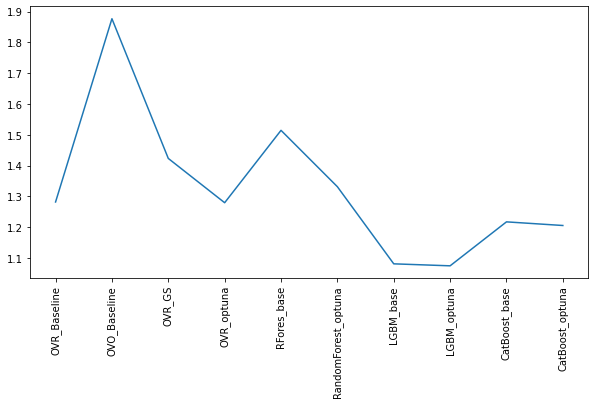

In [64]:
plt.figure(figsize=(10,5))
plt.plot('model', 'Logloss', data=metrics)
plt.xticks(rotation = 90)
plt.show()

**Вывод:** по предварительным результатам наилучшее значение метрики logloss показал алгортим ***LGBM с подобранными
гиперпараметрами***

# StackingClassifier

Вначале попробую обучение на  алгоритмах: LogRegression, KNN, RandomForest, LGBM, CatBoost, - c подобранными параметрами и без, используя встроенные метод из sklearn. 

В расчете не будут использоваться алгоритмы RandomForest и LGBM с базовыми параметрами, т.к. результат показал, что они переобучаются без настройки на текущем датасете

In [65]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [66]:
best_params_cboost.pop('use_best_model')

True

In [67]:
estimators = [
    ('log_reg_p', LogisticRegression(**best_params_lr)),
    ('log_reg', LogisticRegression(class_weight='balanced',
                                   random_state=RAND_1)),
    ('KNN', KNeighborsClassifier()),
    ('rf_p', RandomForestClassifier(**best_params_rf)),
    #('rf', RandomForestClassifier(random_state=RAND, class_weight='balanced')),
    ('lgbm_p', LGBMClassifier(**best_params_lgbm)),
    #('lgbm', LGBMClassifier(random_state=RAND_2, is_unbalance=True)),
    ('cat_p', CatBoostClassifier(**best_params_cboost)),
    ('cat',
     CatBoostClassifier(random_state=RAND_1, auto_class_weights='Balanced'))
]

cv = StratifiedKFold(n_splits=N_FOLDS)
algorithm = StackingClassifier(
    estimators=estimators,
    cv=cv,
    final_estimator=LogisticRegression(random_state=RAND))

algorithm.fit(X_bin_train, y_train)

y_pred = algorithm.predict(X_bin_test)
y_prob = algorithm.predict_proba(X_bin_test)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] lambda_l1 is set=14, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=24, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24
0:	learn: 1.7630182	total: 13.4ms	remaining: 20.1s
1:	learn: 1.7200700	total: 25.4ms	remaining: 19s
2:	learn: 1.7067593	total: 37.4ms	remaining: 18.7s
3:	learn: 1.6990026	total: 49.1ms	remaining: 18.4s
4:	learn: 1.6827479	total: 62.1ms	remaining: 18.6s
5:	learn: 1.6560020	total: 76.5ms	remaining: 19.1s
6:	learn: 1.6353269	total: 88.3ms	remaining: 18.8s
7:	learn: 1.5881129	total: 99.9ms	remaining: 18.6s
8:	learn: 1.5616143	total: 1

152:	learn: 1.1657684	total: 1.76s	remaining: 15.5s
153:	learn: 1.1652300	total: 1.77s	remaining: 15.5s
154:	learn: 1.1646883	total: 1.78s	remaining: 15.5s
155:	learn: 1.1641535	total: 1.79s	remaining: 15.4s
156:	learn: 1.1634443	total: 1.8s	remaining: 15.4s
157:	learn: 1.1628336	total: 1.81s	remaining: 15.4s
158:	learn: 1.1623831	total: 1.83s	remaining: 15.4s
159:	learn: 1.1619883	total: 1.84s	remaining: 15.4s
160:	learn: 1.1613416	total: 1.85s	remaining: 15.4s
161:	learn: 1.1606740	total: 1.86s	remaining: 15.4s
162:	learn: 1.1598967	total: 1.87s	remaining: 15.4s
163:	learn: 1.1585566	total: 1.89s	remaining: 15.4s
164:	learn: 1.1576486	total: 1.9s	remaining: 15.4s
165:	learn: 1.1563898	total: 1.91s	remaining: 15.3s
166:	learn: 1.1559650	total: 1.92s	remaining: 15.3s
167:	learn: 1.1556191	total: 1.93s	remaining: 15.3s
168:	learn: 1.1529841	total: 1.94s	remaining: 15.3s
169:	learn: 1.1505197	total: 1.96s	remaining: 15.3s
170:	learn: 1.1500338	total: 1.97s	remaining: 15.3s
171:	learn: 1.

321:	learn: 1.0871065	total: 3.76s	remaining: 13.8s
322:	learn: 1.0858495	total: 3.77s	remaining: 13.7s
323:	learn: 1.0857666	total: 3.78s	remaining: 13.7s
324:	learn: 1.0854383	total: 3.79s	remaining: 13.7s
325:	learn: 1.0853702	total: 3.81s	remaining: 13.7s
326:	learn: 1.0847125	total: 3.82s	remaining: 13.7s
327:	learn: 1.0845624	total: 3.83s	remaining: 13.7s
328:	learn: 1.0844185	total: 3.84s	remaining: 13.7s
329:	learn: 1.0843015	total: 3.85s	remaining: 13.7s
330:	learn: 1.0839791	total: 3.87s	remaining: 13.7s
331:	learn: 1.0837127	total: 3.88s	remaining: 13.6s
332:	learn: 1.0835081	total: 3.89s	remaining: 13.6s
333:	learn: 1.0833942	total: 3.9s	remaining: 13.6s
334:	learn: 1.0833248	total: 3.91s	remaining: 13.6s
335:	learn: 1.0829999	total: 3.92s	remaining: 13.6s
336:	learn: 1.0825141	total: 3.94s	remaining: 13.6s
337:	learn: 1.0821856	total: 3.95s	remaining: 13.6s
338:	learn: 1.0818876	total: 3.96s	remaining: 13.6s
339:	learn: 1.0815827	total: 3.97s	remaining: 13.6s
340:	learn: 1

491:	learn: 1.0447053	total: 5.77s	remaining: 11.8s
492:	learn: 1.0446633	total: 5.78s	remaining: 11.8s
493:	learn: 1.0444638	total: 5.79s	remaining: 11.8s
494:	learn: 1.0441519	total: 5.8s	remaining: 11.8s
495:	learn: 1.0439529	total: 5.82s	remaining: 11.8s
496:	learn: 1.0434043	total: 5.83s	remaining: 11.8s
497:	learn: 1.0433651	total: 5.84s	remaining: 11.7s
498:	learn: 1.0432756	total: 5.85s	remaining: 11.7s
499:	learn: 1.0432076	total: 5.87s	remaining: 11.7s
500:	learn: 1.0430840	total: 5.88s	remaining: 11.7s
501:	learn: 1.0427191	total: 5.89s	remaining: 11.7s
502:	learn: 1.0426736	total: 5.9s	remaining: 11.7s
503:	learn: 1.0425403	total: 5.91s	remaining: 11.7s
504:	learn: 1.0422982	total: 5.92s	remaining: 11.7s
505:	learn: 1.0422672	total: 5.94s	remaining: 11.7s
506:	learn: 1.0422300	total: 5.95s	remaining: 11.7s
507:	learn: 1.0421951	total: 5.96s	remaining: 11.6s
508:	learn: 1.0421384	total: 5.97s	remaining: 11.6s
509:	learn: 1.0420895	total: 5.99s	remaining: 11.6s
510:	learn: 1.

659:	learn: 1.0144944	total: 7.75s	remaining: 9.87s
660:	learn: 1.0141920	total: 7.77s	remaining: 9.86s
661:	learn: 1.0140035	total: 7.78s	remaining: 9.85s
662:	learn: 1.0139547	total: 7.79s	remaining: 9.84s
663:	learn: 1.0137240	total: 7.8s	remaining: 9.82s
664:	learn: 1.0136931	total: 7.81s	remaining: 9.81s
665:	learn: 1.0133156	total: 7.83s	remaining: 9.8s
666:	learn: 1.0130849	total: 7.84s	remaining: 9.79s
667:	learn: 1.0130002	total: 7.85s	remaining: 9.78s
668:	learn: 1.0127091	total: 7.86s	remaining: 9.76s
669:	learn: 1.0126738	total: 7.87s	remaining: 9.75s
670:	learn: 1.0126300	total: 7.88s	remaining: 9.74s
671:	learn: 1.0124066	total: 7.89s	remaining: 9.73s
672:	learn: 1.0121709	total: 7.91s	remaining: 9.72s
673:	learn: 1.0120288	total: 7.92s	remaining: 9.7s
674:	learn: 1.0118171	total: 7.93s	remaining: 9.69s
675:	learn: 1.0115731	total: 7.94s	remaining: 9.68s
676:	learn: 1.0115155	total: 7.96s	remaining: 9.67s
677:	learn: 1.0113931	total: 7.97s	remaining: 9.66s
678:	learn: 1.0

827:	learn: 0.9879047	total: 9.75s	remaining: 7.91s
828:	learn: 0.9878588	total: 9.77s	remaining: 7.91s
829:	learn: 0.9875135	total: 9.78s	remaining: 7.89s
830:	learn: 0.9874168	total: 9.79s	remaining: 7.88s
831:	learn: 0.9871823	total: 9.8s	remaining: 7.87s
832:	learn: 0.9871462	total: 9.81s	remaining: 7.86s
833:	learn: 0.9868901	total: 9.83s	remaining: 7.85s
834:	learn: 0.9867841	total: 9.84s	remaining: 7.83s
835:	learn: 0.9867610	total: 9.85s	remaining: 7.82s
836:	learn: 0.9862910	total: 9.86s	remaining: 7.81s
837:	learn: 0.9860193	total: 9.87s	remaining: 7.8s
838:	learn: 0.9859941	total: 9.88s	remaining: 7.79s
839:	learn: 0.9859643	total: 9.9s	remaining: 7.78s
840:	learn: 0.9857847	total: 9.91s	remaining: 7.76s
841:	learn: 0.9855632	total: 9.92s	remaining: 7.75s
842:	learn: 0.9853777	total: 9.93s	remaining: 7.74s
843:	learn: 0.9851354	total: 9.94s	remaining: 7.73s
844:	learn: 0.9851105	total: 9.96s	remaining: 7.72s
845:	learn: 0.9850583	total: 9.97s	remaining: 7.71s
846:	learn: 0.9

996:	learn: 0.9638114	total: 11.7s	remaining: 5.93s
997:	learn: 0.9634273	total: 11.8s	remaining: 5.92s
998:	learn: 0.9633798	total: 11.8s	remaining: 5.9s
999:	learn: 0.9633509	total: 11.8s	remaining: 5.89s
1000:	learn: 0.9630462	total: 11.8s	remaining: 5.88s
1001:	learn: 0.9627708	total: 11.8s	remaining: 5.87s
1002:	learn: 0.9626418	total: 11.8s	remaining: 5.86s
1003:	learn: 0.9624989	total: 11.8s	remaining: 5.84s
1004:	learn: 0.9624616	total: 11.8s	remaining: 5.83s
1005:	learn: 0.9621798	total: 11.9s	remaining: 5.82s
1006:	learn: 0.9621515	total: 11.9s	remaining: 5.81s
1007:	learn: 0.9621032	total: 11.9s	remaining: 5.8s
1008:	learn: 0.9618613	total: 11.9s	remaining: 5.79s
1009:	learn: 0.9617992	total: 11.9s	remaining: 5.77s
1010:	learn: 0.9616983	total: 11.9s	remaining: 5.76s
1011:	learn: 0.9615889	total: 11.9s	remaining: 5.75s
1012:	learn: 0.9614976	total: 11.9s	remaining: 5.74s
1013:	learn: 0.9614587	total: 11.9s	remaining: 5.73s
1014:	learn: 0.9612516	total: 12s	remaining: 5.71s
1

1166:	learn: 0.9420130	total: 13.8s	remaining: 3.92s
1167:	learn: 0.9419177	total: 13.8s	remaining: 3.91s
1168:	learn: 0.9418638	total: 13.8s	remaining: 3.9s
1169:	learn: 0.9418110	total: 13.8s	remaining: 3.89s
1170:	learn: 0.9417125	total: 13.8s	remaining: 3.88s
1171:	learn: 0.9416632	total: 13.8s	remaining: 3.87s
1172:	learn: 0.9414479	total: 13.8s	remaining: 3.85s
1173:	learn: 0.9411272	total: 13.8s	remaining: 3.84s
1174:	learn: 0.9410952	total: 13.8s	remaining: 3.83s
1175:	learn: 0.9408134	total: 13.9s	remaining: 3.82s
1176:	learn: 0.9407315	total: 13.9s	remaining: 3.81s
1177:	learn: 0.9405401	total: 13.9s	remaining: 3.79s
1178:	learn: 0.9404331	total: 13.9s	remaining: 3.78s
1179:	learn: 0.9404017	total: 13.9s	remaining: 3.77s
1180:	learn: 0.9403803	total: 13.9s	remaining: 3.76s
1181:	learn: 0.9402369	total: 13.9s	remaining: 3.75s
1182:	learn: 0.9402051	total: 13.9s	remaining: 3.73s
1183:	learn: 0.9401636	total: 14s	remaining: 3.72s
1184:	learn: 0.9400949	total: 14s	remaining: 3.71

1336:	learn: 0.9219343	total: 15.8s	remaining: 1.92s
1337:	learn: 0.9218525	total: 15.8s	remaining: 1.91s
1338:	learn: 0.9217478	total: 15.8s	remaining: 1.9s
1339:	learn: 0.9217231	total: 15.8s	remaining: 1.89s
1340:	learn: 0.9216244	total: 15.8s	remaining: 1.87s
1341:	learn: 0.9215974	total: 15.8s	remaining: 1.86s
1342:	learn: 0.9214413	total: 15.8s	remaining: 1.85s
1343:	learn: 0.9213624	total: 15.8s	remaining: 1.84s
1344:	learn: 0.9212980	total: 15.8s	remaining: 1.83s
1345:	learn: 0.9211087	total: 15.9s	remaining: 1.81s
1346:	learn: 0.9210400	total: 15.9s	remaining: 1.8s
1347:	learn: 0.9208832	total: 15.9s	remaining: 1.79s
1348:	learn: 0.9207331	total: 15.9s	remaining: 1.78s
1349:	learn: 0.9206672	total: 15.9s	remaining: 1.77s
1350:	learn: 0.9206411	total: 15.9s	remaining: 1.75s
1351:	learn: 0.9204868	total: 15.9s	remaining: 1.74s
1352:	learn: 0.9204599	total: 15.9s	remaining: 1.73s
1353:	learn: 0.9204343	total: 16s	remaining: 1.72s
1354:	learn: 0.9203703	total: 16s	remaining: 1.71s

Learning rate set to 0.090785
0:	learn: 1.7222678	total: 8.43ms	remaining: 8.42s
1:	learn: 1.6656785	total: 13.8ms	remaining: 6.89s
2:	learn: 1.6198769	total: 19ms	remaining: 6.32s
3:	learn: 1.5695494	total: 24.4ms	remaining: 6.07s
4:	learn: 1.5285976	total: 29.6ms	remaining: 5.9s
5:	learn: 1.4964092	total: 34.8ms	remaining: 5.77s
6:	learn: 1.4675638	total: 40.2ms	remaining: 5.7s
7:	learn: 1.4409956	total: 45.1ms	remaining: 5.59s
8:	learn: 1.4199842	total: 50.4ms	remaining: 5.55s
9:	learn: 1.3997614	total: 55.6ms	remaining: 5.5s
10:	learn: 1.3786005	total: 60.7ms	remaining: 5.46s
11:	learn: 1.3647530	total: 66ms	remaining: 5.44s
12:	learn: 1.3493048	total: 71.3ms	remaining: 5.42s
13:	learn: 1.3357831	total: 76.3ms	remaining: 5.37s
14:	learn: 1.3240232	total: 81.3ms	remaining: 5.34s
15:	learn: 1.3136780	total: 86.4ms	remaining: 5.31s
16:	learn: 1.3018753	total: 91.5ms	remaining: 5.29s
17:	learn: 1.2948092	total: 96.6ms	remaining: 5.27s
18:	learn: 1.2863651	total: 102ms	remaining: 5.25s


178:	learn: 1.0320102	total: 896ms	remaining: 4.11s
179:	learn: 1.0315007	total: 902ms	remaining: 4.11s
180:	learn: 1.0308928	total: 907ms	remaining: 4.11s
181:	learn: 1.0302876	total: 913ms	remaining: 4.1s
182:	learn: 1.0297153	total: 917ms	remaining: 4.09s
183:	learn: 1.0294547	total: 922ms	remaining: 4.09s
184:	learn: 1.0285492	total: 927ms	remaining: 4.08s
185:	learn: 1.0282753	total: 932ms	remaining: 4.08s
186:	learn: 1.0275280	total: 937ms	remaining: 4.07s
187:	learn: 1.0266772	total: 942ms	remaining: 4.07s
188:	learn: 1.0259989	total: 947ms	remaining: 4.06s
189:	learn: 1.0253778	total: 952ms	remaining: 4.06s
190:	learn: 1.0245733	total: 957ms	remaining: 4.05s
191:	learn: 1.0241240	total: 962ms	remaining: 4.05s
192:	learn: 1.0235730	total: 967ms	remaining: 4.04s
193:	learn: 1.0223219	total: 972ms	remaining: 4.04s
194:	learn: 1.0218019	total: 977ms	remaining: 4.03s
195:	learn: 1.0214845	total: 982ms	remaining: 4.03s
196:	learn: 1.0206445	total: 987ms	remaining: 4.02s
197:	learn: 1

361:	learn: 0.9404295	total: 1.8s	remaining: 3.17s
362:	learn: 0.9401132	total: 1.81s	remaining: 3.17s
363:	learn: 0.9396650	total: 1.81s	remaining: 3.17s
364:	learn: 0.9395378	total: 1.82s	remaining: 3.16s
365:	learn: 0.9390450	total: 1.82s	remaining: 3.15s
366:	learn: 0.9388207	total: 1.83s	remaining: 3.15s
367:	learn: 0.9386460	total: 1.83s	remaining: 3.15s
368:	learn: 0.9384626	total: 1.84s	remaining: 3.14s
369:	learn: 0.9382792	total: 1.84s	remaining: 3.13s
370:	learn: 0.9379861	total: 1.84s	remaining: 3.13s
371:	learn: 0.9378087	total: 1.85s	remaining: 3.12s
372:	learn: 0.9376143	total: 1.85s	remaining: 3.12s
373:	learn: 0.9374235	total: 1.86s	remaining: 3.11s
374:	learn: 0.9371395	total: 1.86s	remaining: 3.11s
375:	learn: 0.9365724	total: 1.87s	remaining: 3.1s
376:	learn: 0.9364755	total: 1.88s	remaining: 3.1s
377:	learn: 0.9357203	total: 1.88s	remaining: 3.09s
378:	learn: 0.9354115	total: 1.89s	remaining: 3.09s
379:	learn: 0.9349973	total: 1.89s	remaining: 3.08s
380:	learn: 0.9

545:	learn: 0.8887906	total: 2.71s	remaining: 2.25s
546:	learn: 0.8885628	total: 2.72s	remaining: 2.25s
547:	learn: 0.8884276	total: 2.72s	remaining: 2.25s
548:	learn: 0.8882266	total: 2.73s	remaining: 2.24s
549:	learn: 0.8881973	total: 2.73s	remaining: 2.23s
550:	learn: 0.8879858	total: 2.74s	remaining: 2.23s
551:	learn: 0.8875052	total: 2.74s	remaining: 2.23s
552:	learn: 0.8869920	total: 2.75s	remaining: 2.22s
553:	learn: 0.8865523	total: 2.75s	remaining: 2.21s
554:	learn: 0.8863832	total: 2.76s	remaining: 2.21s
555:	learn: 0.8858699	total: 2.76s	remaining: 2.21s
556:	learn: 0.8854571	total: 2.77s	remaining: 2.2s
557:	learn: 0.8850471	total: 2.77s	remaining: 2.19s
558:	learn: 0.8849012	total: 2.78s	remaining: 2.19s
559:	learn: 0.8847461	total: 2.78s	remaining: 2.19s
560:	learn: 0.8847153	total: 2.79s	remaining: 2.18s
561:	learn: 0.8844110	total: 2.79s	remaining: 2.17s
562:	learn: 0.8842544	total: 2.8s	remaining: 2.17s
563:	learn: 0.8837492	total: 2.8s	remaining: 2.17s
564:	learn: 0.8

728:	learn: 0.8468703	total: 3.62s	remaining: 1.34s
729:	learn: 0.8467549	total: 3.62s	remaining: 1.34s
730:	learn: 0.8466750	total: 3.63s	remaining: 1.33s
731:	learn: 0.8465943	total: 3.63s	remaining: 1.33s
732:	learn: 0.8465610	total: 3.64s	remaining: 1.32s
733:	learn: 0.8463145	total: 3.64s	remaining: 1.32s
734:	learn: 0.8462052	total: 3.65s	remaining: 1.31s
735:	learn: 0.8458557	total: 3.65s	remaining: 1.31s
736:	learn: 0.8457234	total: 3.66s	remaining: 1.3s
737:	learn: 0.8455140	total: 3.66s	remaining: 1.3s
738:	learn: 0.8453354	total: 3.67s	remaining: 1.29s
739:	learn: 0.8451793	total: 3.67s	remaining: 1.29s
740:	learn: 0.8450753	total: 3.68s	remaining: 1.28s
741:	learn: 0.8449832	total: 3.68s	remaining: 1.28s
742:	learn: 0.8448659	total: 3.69s	remaining: 1.27s
743:	learn: 0.8447299	total: 3.69s	remaining: 1.27s
744:	learn: 0.8444811	total: 3.7s	remaining: 1.26s
745:	learn: 0.8444454	total: 3.7s	remaining: 1.26s
746:	learn: 0.8443209	total: 3.71s	remaining: 1.25s
747:	learn: 0.84

912:	learn: 0.8132679	total: 4.52s	remaining: 431ms
913:	learn: 0.8132030	total: 4.53s	remaining: 426ms
914:	learn: 0.8130624	total: 4.53s	remaining: 421ms
915:	learn: 0.8124819	total: 4.54s	remaining: 416ms
916:	learn: 0.8124443	total: 4.54s	remaining: 411ms
917:	learn: 0.8119694	total: 4.55s	remaining: 406ms
918:	learn: 0.8118859	total: 4.55s	remaining: 401ms
919:	learn: 0.8117675	total: 4.56s	remaining: 396ms
920:	learn: 0.8115757	total: 4.56s	remaining: 391ms
921:	learn: 0.8112336	total: 4.57s	remaining: 386ms
922:	learn: 0.8110730	total: 4.57s	remaining: 382ms
923:	learn: 0.8108143	total: 4.58s	remaining: 377ms
924:	learn: 0.8106955	total: 4.58s	remaining: 372ms
925:	learn: 0.8106465	total: 4.59s	remaining: 367ms
926:	learn: 0.8104388	total: 4.59s	remaining: 362ms
927:	learn: 0.8101566	total: 4.6s	remaining: 357ms
928:	learn: 0.8099699	total: 4.6s	remaining: 352ms
929:	learn: 0.8098538	total: 4.61s	remaining: 347ms
930:	learn: 0.8097507	total: 4.61s	remaining: 342ms
931:	learn: 0.

43:	learn: 1.3311993	total: 402ms	remaining: 13.3s
44:	learn: 1.3296554	total: 412ms	remaining: 13.3s
45:	learn: 1.3294554	total: 421ms	remaining: 13.3s
46:	learn: 1.3276133	total: 429ms	remaining: 13.3s
47:	learn: 1.3270792	total: 437ms	remaining: 13.2s
48:	learn: 1.3254927	total: 446ms	remaining: 13.2s
49:	learn: 1.3224190	total: 455ms	remaining: 13.2s
50:	learn: 1.3216773	total: 464ms	remaining: 13.2s
51:	learn: 1.3208377	total: 473ms	remaining: 13.2s
52:	learn: 1.3202289	total: 481ms	remaining: 13.1s
53:	learn: 1.3200154	total: 490ms	remaining: 13.1s
54:	learn: 1.3164404	total: 499ms	remaining: 13.1s
55:	learn: 1.3160318	total: 507ms	remaining: 13.1s
56:	learn: 1.3152367	total: 516ms	remaining: 13.1s
57:	learn: 1.3134268	total: 525ms	remaining: 13s
58:	learn: 1.3118458	total: 533ms	remaining: 13s
59:	learn: 1.3111302	total: 543ms	remaining: 13s
60:	learn: 1.3098641	total: 551ms	remaining: 13s
61:	learn: 1.3065132	total: 560ms	remaining: 13s
62:	learn: 1.3015513	total: 568ms	remaini

206:	learn: 1.1179132	total: 1.95s	remaining: 12.2s
207:	learn: 1.1163676	total: 1.97s	remaining: 12.2s
208:	learn: 1.1160135	total: 1.98s	remaining: 12.2s
209:	learn: 1.1158058	total: 1.98s	remaining: 12.2s
210:	learn: 1.1155387	total: 1.99s	remaining: 12.2s
211:	learn: 1.1143673	total: 2s	remaining: 12.2s
212:	learn: 1.1137862	total: 2.01s	remaining: 12.2s
213:	learn: 1.1132473	total: 2.02s	remaining: 12.1s
214:	learn: 1.1123827	total: 2.03s	remaining: 12.1s
215:	learn: 1.1114794	total: 2.04s	remaining: 12.1s
216:	learn: 1.1112778	total: 2.05s	remaining: 12.1s
217:	learn: 1.1105661	total: 2.06s	remaining: 12.1s
218:	learn: 1.1103883	total: 2.07s	remaining: 12.1s
219:	learn: 1.1101256	total: 2.08s	remaining: 12.1s
220:	learn: 1.1092349	total: 2.09s	remaining: 12.1s
221:	learn: 1.1080670	total: 2.1s	remaining: 12.1s
222:	learn: 1.1072714	total: 2.1s	remaining: 12.1s
223:	learn: 1.1071037	total: 2.11s	remaining: 12s
224:	learn: 1.1065783	total: 2.12s	remaining: 12s
225:	learn: 1.1063665

371:	learn: 1.0589093	total: 3.53s	remaining: 10.7s
372:	learn: 1.0584591	total: 3.54s	remaining: 10.7s
373:	learn: 1.0577572	total: 3.55s	remaining: 10.7s
374:	learn: 1.0572952	total: 3.56s	remaining: 10.7s
375:	learn: 1.0571521	total: 3.56s	remaining: 10.7s
376:	learn: 1.0567432	total: 3.57s	remaining: 10.6s
377:	learn: 1.0566588	total: 3.58s	remaining: 10.6s
378:	learn: 1.0565947	total: 3.59s	remaining: 10.6s
379:	learn: 1.0565193	total: 3.6s	remaining: 10.6s
380:	learn: 1.0561201	total: 3.61s	remaining: 10.6s
381:	learn: 1.0559682	total: 3.62s	remaining: 10.6s
382:	learn: 1.0558989	total: 3.63s	remaining: 10.6s
383:	learn: 1.0555495	total: 3.64s	remaining: 10.6s
384:	learn: 1.0554687	total: 3.65s	remaining: 10.6s
385:	learn: 1.0552932	total: 3.66s	remaining: 10.6s
386:	learn: 1.0550778	total: 3.67s	remaining: 10.5s
387:	learn: 1.0547746	total: 3.68s	remaining: 10.5s
388:	learn: 1.0539134	total: 3.69s	remaining: 10.5s
389:	learn: 1.0537719	total: 3.7s	remaining: 10.5s
390:	learn: 1.

538:	learn: 1.0200494	total: 5.13s	remaining: 9.15s
539:	learn: 1.0194498	total: 5.14s	remaining: 9.14s
540:	learn: 1.0189854	total: 5.15s	remaining: 9.13s
541:	learn: 1.0189401	total: 5.16s	remaining: 9.12s
542:	learn: 1.0184050	total: 5.17s	remaining: 9.11s
543:	learn: 1.0182626	total: 5.18s	remaining: 9.1s
544:	learn: 1.0182307	total: 5.19s	remaining: 9.09s
545:	learn: 1.0180473	total: 5.2s	remaining: 9.08s
546:	learn: 1.0179330	total: 5.21s	remaining: 9.07s
547:	learn: 1.0176433	total: 5.22s	remaining: 9.07s
548:	learn: 1.0175160	total: 5.23s	remaining: 9.06s
549:	learn: 1.0168279	total: 5.24s	remaining: 9.05s
550:	learn: 1.0167995	total: 5.25s	remaining: 9.05s
551:	learn: 1.0167566	total: 5.27s	remaining: 9.04s
552:	learn: 1.0165930	total: 5.28s	remaining: 9.03s
553:	learn: 1.0157796	total: 5.29s	remaining: 9.03s
554:	learn: 1.0156629	total: 5.29s	remaining: 9.02s
555:	learn: 1.0155894	total: 5.3s	remaining: 9.01s
556:	learn: 1.0154696	total: 5.31s	remaining: 9s
557:	learn: 1.0154

699:	learn: 0.9930841	total: 6.72s	remaining: 7.68s
700:	learn: 0.9929680	total: 6.74s	remaining: 7.68s
701:	learn: 0.9928480	total: 6.75s	remaining: 7.67s
702:	learn: 0.9927987	total: 6.75s	remaining: 7.66s
703:	learn: 0.9924585	total: 6.76s	remaining: 7.65s
704:	learn: 0.9922725	total: 6.77s	remaining: 7.64s
705:	learn: 0.9918148	total: 6.78s	remaining: 7.63s
706:	learn: 0.9913422	total: 6.79s	remaining: 7.62s
707:	learn: 0.9912990	total: 6.8s	remaining: 7.61s
708:	learn: 0.9911994	total: 6.81s	remaining: 7.6s
709:	learn: 0.9910979	total: 6.82s	remaining: 7.59s
710:	learn: 0.9905297	total: 6.83s	remaining: 7.58s
711:	learn: 0.9901962	total: 6.84s	remaining: 7.57s
712:	learn: 0.9900358	total: 6.85s	remaining: 7.56s
713:	learn: 0.9898263	total: 6.86s	remaining: 7.55s
714:	learn: 0.9897519	total: 6.87s	remaining: 7.54s
715:	learn: 0.9896077	total: 6.88s	remaining: 7.53s
716:	learn: 0.9894029	total: 6.88s	remaining: 7.52s
717:	learn: 0.9889641	total: 6.89s	remaining: 7.51s
718:	learn: 0.

865:	learn: 0.9634372	total: 8.31s	remaining: 6.09s
866:	learn: 0.9633511	total: 8.33s	remaining: 6.08s
867:	learn: 0.9633165	total: 8.34s	remaining: 6.07s
868:	learn: 0.9630381	total: 8.35s	remaining: 6.06s
869:	learn: 0.9629760	total: 8.35s	remaining: 6.05s
870:	learn: 0.9629318	total: 8.36s	remaining: 6.04s
871:	learn: 0.9629091	total: 8.37s	remaining: 6.03s
872:	learn: 0.9628238	total: 8.38s	remaining: 6.02s
873:	learn: 0.9625923	total: 8.39s	remaining: 6.01s
874:	learn: 0.9625394	total: 8.4s	remaining: 6s
875:	learn: 0.9622963	total: 8.41s	remaining: 5.99s
876:	learn: 0.9621281	total: 8.42s	remaining: 5.98s
877:	learn: 0.9614730	total: 8.43s	remaining: 5.97s
878:	learn: 0.9612933	total: 8.44s	remaining: 5.96s
879:	learn: 0.9611917	total: 8.45s	remaining: 5.95s
880:	learn: 0.9610234	total: 8.46s	remaining: 5.94s
881:	learn: 0.9608638	total: 8.47s	remaining: 5.93s
882:	learn: 0.9608365	total: 8.48s	remaining: 5.92s
883:	learn: 0.9607145	total: 8.49s	remaining: 5.91s
884:	learn: 0.96

1031:	learn: 0.9397776	total: 9.9s	remaining: 4.49s
1032:	learn: 0.9396828	total: 9.91s	remaining: 4.48s
1033:	learn: 0.9395874	total: 9.92s	remaining: 4.47s
1034:	learn: 0.9394037	total: 9.93s	remaining: 4.46s
1035:	learn: 0.9392170	total: 9.94s	remaining: 4.45s
1036:	learn: 0.9389058	total: 9.95s	remaining: 4.44s
1037:	learn: 0.9388398	total: 9.96s	remaining: 4.43s
1038:	learn: 0.9387852	total: 9.96s	remaining: 4.42s
1039:	learn: 0.9387160	total: 9.97s	remaining: 4.41s
1040:	learn: 0.9386168	total: 9.98s	remaining: 4.4s
1041:	learn: 0.9384357	total: 9.99s	remaining: 4.39s
1042:	learn: 0.9383208	total: 10s	remaining: 4.38s
1043:	learn: 0.9382806	total: 10s	remaining: 4.37s
1044:	learn: 0.9378903	total: 10s	remaining: 4.36s
1045:	learn: 0.9376752	total: 10s	remaining: 4.35s
1046:	learn: 0.9376530	total: 10s	remaining: 4.34s
1047:	learn: 0.9373760	total: 10s	remaining: 4.33s
1048:	learn: 0.9370969	total: 10.1s	remaining: 4.32s
1049:	learn: 0.9370206	total: 10.1s	remaining: 4.31s
1050:	l

1196:	learn: 0.9182296	total: 11.5s	remaining: 2.91s
1197:	learn: 0.9180900	total: 11.5s	remaining: 2.9s
1198:	learn: 0.9179497	total: 11.5s	remaining: 2.89s
1199:	learn: 0.9178967	total: 11.5s	remaining: 2.88s
1200:	learn: 0.9178398	total: 11.5s	remaining: 2.87s
1201:	learn: 0.9175956	total: 11.5s	remaining: 2.86s
1202:	learn: 0.9174654	total: 11.5s	remaining: 2.85s
1203:	learn: 0.9173897	total: 11.6s	remaining: 2.84s
1204:	learn: 0.9172620	total: 11.6s	remaining: 2.83s
1205:	learn: 0.9171973	total: 11.6s	remaining: 2.82s
1206:	learn: 0.9169327	total: 11.6s	remaining: 2.81s
1207:	learn: 0.9168619	total: 11.6s	remaining: 2.8s
1208:	learn: 0.9166336	total: 11.6s	remaining: 2.79s
1209:	learn: 0.9165190	total: 11.6s	remaining: 2.78s
1210:	learn: 0.9162871	total: 11.6s	remaining: 2.77s
1211:	learn: 0.9161089	total: 11.6s	remaining: 2.76s
1212:	learn: 0.9160795	total: 11.6s	remaining: 2.75s
1213:	learn: 0.9159358	total: 11.6s	remaining: 2.74s
1214:	learn: 0.9157758	total: 11.7s	remaining: 2

1361:	learn: 0.8981114	total: 13.1s	remaining: 1.32s
1362:	learn: 0.8980866	total: 13.1s	remaining: 1.31s
1363:	learn: 0.8978830	total: 13.1s	remaining: 1.3s
1364:	learn: 0.8977489	total: 13.1s	remaining: 1.29s
1365:	learn: 0.8976641	total: 13.1s	remaining: 1.28s
1366:	learn: 0.8975108	total: 13.1s	remaining: 1.28s
1367:	learn: 0.8973886	total: 13.1s	remaining: 1.27s
1368:	learn: 0.8971153	total: 13.1s	remaining: 1.26s
1369:	learn: 0.8970285	total: 13.1s	remaining: 1.25s
1370:	learn: 0.8969875	total: 13.2s	remaining: 1.24s
1371:	learn: 0.8968626	total: 13.2s	remaining: 1.23s
1372:	learn: 0.8966823	total: 13.2s	remaining: 1.22s
1373:	learn: 0.8966659	total: 13.2s	remaining: 1.21s
1374:	learn: 0.8962886	total: 13.2s	remaining: 1.2s
1375:	learn: 0.8960601	total: 13.2s	remaining: 1.19s
1376:	learn: 0.8958345	total: 13.2s	remaining: 1.18s
1377:	learn: 0.8958014	total: 13.2s	remaining: 1.17s
1378:	learn: 0.8955587	total: 13.2s	remaining: 1.16s
1379:	learn: 0.8953196	total: 13.2s	remaining: 1

21:	learn: 1.4145925	total: 196ms	remaining: 13.2s
22:	learn: 1.4127766	total: 206ms	remaining: 13.3s
23:	learn: 1.4028608	total: 216ms	remaining: 13.3s
24:	learn: 1.3999691	total: 225ms	remaining: 13.3s
25:	learn: 1.3982197	total: 234ms	remaining: 13.3s
26:	learn: 1.3960542	total: 243ms	remaining: 13.3s
27:	learn: 1.3941765	total: 251ms	remaining: 13.2s
28:	learn: 1.3894378	total: 260ms	remaining: 13.2s
29:	learn: 1.3824338	total: 269ms	remaining: 13.2s
30:	learn: 1.3751103	total: 278ms	remaining: 13.2s
31:	learn: 1.3720042	total: 287ms	remaining: 13.2s
32:	learn: 1.3712209	total: 295ms	remaining: 13.1s
33:	learn: 1.3655983	total: 304ms	remaining: 13.1s
34:	learn: 1.3647620	total: 312ms	remaining: 13.1s
35:	learn: 1.3594142	total: 320ms	remaining: 13s
36:	learn: 1.3573042	total: 329ms	remaining: 13s
37:	learn: 1.3546940	total: 337ms	remaining: 13s
38:	learn: 1.3522362	total: 346ms	remaining: 13s
39:	learn: 1.3484214	total: 355ms	remaining: 12.9s
40:	learn: 1.3473339	total: 363ms	remai

188:	learn: 1.1316699	total: 1.75s	remaining: 12.1s
189:	learn: 1.1313692	total: 1.76s	remaining: 12.1s
190:	learn: 1.1310840	total: 1.77s	remaining: 12.1s
191:	learn: 1.1298122	total: 1.78s	remaining: 12.1s
192:	learn: 1.1293195	total: 1.79s	remaining: 12.1s
193:	learn: 1.1271914	total: 1.8s	remaining: 12.1s
194:	learn: 1.1269298	total: 1.81s	remaining: 12.1s
195:	learn: 1.1260765	total: 1.82s	remaining: 12.1s
196:	learn: 1.1256739	total: 1.83s	remaining: 12.1s
197:	learn: 1.1252282	total: 1.84s	remaining: 12.1s
198:	learn: 1.1249647	total: 1.85s	remaining: 12.1s
199:	learn: 1.1245826	total: 1.86s	remaining: 12.1s
200:	learn: 1.1238418	total: 1.86s	remaining: 12.1s
201:	learn: 1.1233572	total: 1.87s	remaining: 12s
202:	learn: 1.1225772	total: 1.88s	remaining: 12s
203:	learn: 1.1217443	total: 1.89s	remaining: 12s
204:	learn: 1.1214418	total: 1.9s	remaining: 12s
205:	learn: 1.1203858	total: 1.91s	remaining: 12s
206:	learn: 1.1201568	total: 1.92s	remaining: 12s
207:	learn: 1.1196755	tota

354:	learn: 1.0697790	total: 3.34s	remaining: 10.8s
355:	learn: 1.0697164	total: 3.35s	remaining: 10.8s
356:	learn: 1.0695791	total: 3.36s	remaining: 10.8s
357:	learn: 1.0695228	total: 3.37s	remaining: 10.8s
358:	learn: 1.0693607	total: 3.38s	remaining: 10.7s
359:	learn: 1.0691036	total: 3.39s	remaining: 10.7s
360:	learn: 1.0689954	total: 3.4s	remaining: 10.7s
361:	learn: 1.0687359	total: 3.41s	remaining: 10.7s
362:	learn: 1.0686308	total: 3.42s	remaining: 10.7s
363:	learn: 1.0678207	total: 3.43s	remaining: 10.7s
364:	learn: 1.0677520	total: 3.44s	remaining: 10.7s
365:	learn: 1.0676710	total: 3.44s	remaining: 10.7s
366:	learn: 1.0673903	total: 3.46s	remaining: 10.7s
367:	learn: 1.0672703	total: 3.46s	remaining: 10.7s
368:	learn: 1.0667314	total: 3.47s	remaining: 10.6s
369:	learn: 1.0665216	total: 3.48s	remaining: 10.6s
370:	learn: 1.0661513	total: 3.49s	remaining: 10.6s
371:	learn: 1.0660486	total: 3.5s	remaining: 10.6s
372:	learn: 1.0659481	total: 3.51s	remaining: 10.6s
373:	learn: 1.

521:	learn: 1.0302812	total: 4.93s	remaining: 9.24s
522:	learn: 1.0298349	total: 4.94s	remaining: 9.23s
523:	learn: 1.0291389	total: 4.95s	remaining: 9.22s
524:	learn: 1.0290675	total: 4.96s	remaining: 9.21s
525:	learn: 1.0285444	total: 4.97s	remaining: 9.2s
526:	learn: 1.0283935	total: 4.98s	remaining: 9.19s
527:	learn: 1.0280291	total: 4.99s	remaining: 9.18s
528:	learn: 1.0278870	total: 5s	remaining: 9.17s
529:	learn: 1.0277443	total: 5.01s	remaining: 9.16s
530:	learn: 1.0276108	total: 5.02s	remaining: 9.15s
531:	learn: 1.0273766	total: 5.03s	remaining: 9.14s
532:	learn: 1.0272838	total: 5.04s	remaining: 9.13s
533:	learn: 1.0272422	total: 5.04s	remaining: 9.13s
534:	learn: 1.0271180	total: 5.05s	remaining: 9.12s
535:	learn: 1.0270691	total: 5.06s	remaining: 9.11s
536:	learn: 1.0270292	total: 5.07s	remaining: 9.09s
537:	learn: 1.0269870	total: 5.08s	remaining: 9.08s
538:	learn: 1.0268824	total: 5.09s	remaining: 9.07s
539:	learn: 1.0264506	total: 5.1s	remaining: 9.06s
540:	learn: 1.026

687:	learn: 0.9975253	total: 6.51s	remaining: 7.69s
688:	learn: 0.9974788	total: 6.53s	remaining: 7.68s
689:	learn: 0.9973880	total: 6.54s	remaining: 7.67s
690:	learn: 0.9973083	total: 6.54s	remaining: 7.66s
691:	learn: 0.9972369	total: 6.55s	remaining: 7.65s
692:	learn: 0.9968878	total: 6.56s	remaining: 7.64s
693:	learn: 0.9965463	total: 6.57s	remaining: 7.63s
694:	learn: 0.9962831	total: 6.58s	remaining: 7.62s
695:	learn: 0.9958722	total: 6.59s	remaining: 7.61s
696:	learn: 0.9957957	total: 6.6s	remaining: 7.61s
697:	learn: 0.9957388	total: 6.61s	remaining: 7.6s
698:	learn: 0.9957007	total: 6.63s	remaining: 7.59s
699:	learn: 0.9955637	total: 6.64s	remaining: 7.58s
700:	learn: 0.9955297	total: 6.64s	remaining: 7.57s
701:	learn: 0.9954849	total: 6.65s	remaining: 7.56s
702:	learn: 0.9953246	total: 6.66s	remaining: 7.55s
703:	learn: 0.9951452	total: 6.67s	remaining: 7.54s
704:	learn: 0.9951086	total: 6.68s	remaining: 7.54s
705:	learn: 0.9947715	total: 6.69s	remaining: 7.53s
706:	learn: 0.

853:	learn: 0.9724258	total: 8.1s	remaining: 6.13s
854:	learn: 0.9723874	total: 8.11s	remaining: 6.12s
855:	learn: 0.9719605	total: 8.12s	remaining: 6.11s
856:	learn: 0.9718650	total: 8.13s	remaining: 6.1s
857:	learn: 0.9716860	total: 8.14s	remaining: 6.09s
858:	learn: 0.9715570	total: 8.15s	remaining: 6.08s
859:	learn: 0.9713138	total: 8.16s	remaining: 6.07s
860:	learn: 0.9712423	total: 8.17s	remaining: 6.06s
861:	learn: 0.9709942	total: 8.18s	remaining: 6.05s
862:	learn: 0.9709680	total: 8.19s	remaining: 6.04s
863:	learn: 0.9705693	total: 8.2s	remaining: 6.03s
864:	learn: 0.9704766	total: 8.21s	remaining: 6.02s
865:	learn: 0.9704268	total: 8.22s	remaining: 6.01s
866:	learn: 0.9703665	total: 8.22s	remaining: 6s
867:	learn: 0.9701441	total: 8.23s	remaining: 6s
868:	learn: 0.9699854	total: 8.24s	remaining: 5.99s
869:	learn: 0.9699495	total: 8.25s	remaining: 5.98s
870:	learn: 0.9695832	total: 8.26s	remaining: 5.97s
871:	learn: 0.9695217	total: 8.27s	remaining: 5.96s
872:	learn: 0.9694622

1021:	learn: 0.9491551	total: 9.7s	remaining: 4.54s
1022:	learn: 0.9490086	total: 9.71s	remaining: 4.53s
1023:	learn: 0.9486389	total: 9.72s	remaining: 4.52s
1024:	learn: 0.9482864	total: 9.73s	remaining: 4.51s
1025:	learn: 0.9478548	total: 9.74s	remaining: 4.5s
1026:	learn: 0.9477133	total: 9.75s	remaining: 4.49s
1027:	learn: 0.9476714	total: 9.76s	remaining: 4.48s
1028:	learn: 0.9476222	total: 9.77s	remaining: 4.47s
1029:	learn: 0.9475969	total: 9.78s	remaining: 4.46s
1030:	learn: 0.9475159	total: 9.79s	remaining: 4.45s
1031:	learn: 0.9474919	total: 9.8s	remaining: 4.44s
1032:	learn: 0.9473499	total: 9.81s	remaining: 4.43s
1033:	learn: 0.9472340	total: 9.82s	remaining: 4.42s
1034:	learn: 0.9471770	total: 9.83s	remaining: 4.42s
1035:	learn: 0.9471115	total: 9.84s	remaining: 4.41s
1036:	learn: 0.9469380	total: 9.85s	remaining: 4.4s
1037:	learn: 0.9469025	total: 9.86s	remaining: 4.39s
1038:	learn: 0.9468126	total: 9.87s	remaining: 4.38s
1039:	learn: 0.9466507	total: 9.87s	remaining: 4.3

1183:	learn: 0.9266325	total: 11.3s	remaining: 3s
1184:	learn: 0.9265722	total: 11.3s	remaining: 3s
1185:	learn: 0.9264529	total: 11.3s	remaining: 2.99s
1186:	learn: 0.9263148	total: 11.3s	remaining: 2.98s
1187:	learn: 0.9261281	total: 11.3s	remaining: 2.97s
1188:	learn: 0.9260689	total: 11.3s	remaining: 2.96s
1189:	learn: 0.9259503	total: 11.3s	remaining: 2.95s
1190:	learn: 0.9258706	total: 11.3s	remaining: 2.94s
1191:	learn: 0.9258508	total: 11.3s	remaining: 2.93s
1192:	learn: 0.9258126	total: 11.3s	remaining: 2.92s
1193:	learn: 0.9256666	total: 11.4s	remaining: 2.91s
1194:	learn: 0.9253991	total: 11.4s	remaining: 2.9s
1195:	learn: 0.9253622	total: 11.4s	remaining: 2.89s
1196:	learn: 0.9251323	total: 11.4s	remaining: 2.88s
1197:	learn: 0.9251084	total: 11.4s	remaining: 2.87s
1198:	learn: 0.9249178	total: 11.4s	remaining: 2.86s
1199:	learn: 0.9248996	total: 11.4s	remaining: 2.85s
1200:	learn: 0.9247983	total: 11.4s	remaining: 2.84s
1201:	learn: 0.9247689	total: 11.4s	remaining: 2.83s


1346:	learn: 0.9075964	total: 12.8s	remaining: 1.46s
1347:	learn: 0.9074359	total: 12.8s	remaining: 1.45s
1348:	learn: 0.9073155	total: 12.8s	remaining: 1.44s
1349:	learn: 0.9072651	total: 12.9s	remaining: 1.43s
1350:	learn: 0.9071871	total: 12.9s	remaining: 1.42s
1351:	learn: 0.9070837	total: 12.9s	remaining: 1.41s
1352:	learn: 0.9070574	total: 12.9s	remaining: 1.4s
1353:	learn: 0.9067700	total: 12.9s	remaining: 1.39s
1354:	learn: 0.9067032	total: 12.9s	remaining: 1.38s
1355:	learn: 0.9066744	total: 12.9s	remaining: 1.37s
1356:	learn: 0.9064522	total: 12.9s	remaining: 1.36s
1357:	learn: 0.9063984	total: 12.9s	remaining: 1.35s
1358:	learn: 0.9063227	total: 12.9s	remaining: 1.34s
1359:	learn: 0.9062711	total: 13s	remaining: 1.33s
1360:	learn: 0.9062170	total: 13s	remaining: 1.32s
1361:	learn: 0.9061689	total: 13s	remaining: 1.31s
1362:	learn: 0.9060724	total: 13s	remaining: 1.3s
1363:	learn: 0.9059583	total: 13s	remaining: 1.29s
1364:	learn: 0.9058256	total: 13s	remaining: 1.28s
1365:	l

18:	learn: 1.4488604	total: 198ms	remaining: 15.4s
19:	learn: 1.4474822	total: 209ms	remaining: 15.5s
20:	learn: 1.4417794	total: 221ms	remaining: 15.5s
21:	learn: 1.4380256	total: 231ms	remaining: 15.6s
22:	learn: 1.4320516	total: 243ms	remaining: 15.6s
23:	learn: 1.4308814	total: 255ms	remaining: 15.7s
24:	learn: 1.4269952	total: 266ms	remaining: 15.7s
25:	learn: 1.4214063	total: 277ms	remaining: 15.7s
26:	learn: 1.4151021	total: 290ms	remaining: 15.8s
27:	learn: 1.4138682	total: 302ms	remaining: 15.9s
28:	learn: 1.4102706	total: 314ms	remaining: 15.9s
29:	learn: 1.4067776	total: 326ms	remaining: 16s
30:	learn: 1.4037804	total: 338ms	remaining: 16s
31:	learn: 1.3997763	total: 349ms	remaining: 16s
32:	learn: 1.3977519	total: 362ms	remaining: 16.1s
33:	learn: 1.3959562	total: 374ms	remaining: 16.1s
34:	learn: 1.3897837	total: 387ms	remaining: 16.2s
35:	learn: 1.3806658	total: 398ms	remaining: 16.2s
36:	learn: 1.3759686	total: 411ms	remaining: 16.2s
37:	learn: 1.3749008	total: 423ms	rem

187:	learn: 1.1349632	total: 2.16s	remaining: 15.1s
188:	learn: 1.1345300	total: 2.17s	remaining: 15.1s
189:	learn: 1.1342582	total: 2.19s	remaining: 15.1s
190:	learn: 1.1332286	total: 2.2s	remaining: 15.1s
191:	learn: 1.1328021	total: 2.21s	remaining: 15.1s
192:	learn: 1.1323455	total: 2.22s	remaining: 15.1s
193:	learn: 1.1312871	total: 2.23s	remaining: 15s
194:	learn: 1.1309963	total: 2.25s	remaining: 15s
195:	learn: 1.1303455	total: 2.26s	remaining: 15s
196:	learn: 1.1301057	total: 2.27s	remaining: 15s
197:	learn: 1.1285475	total: 2.28s	remaining: 15s
198:	learn: 1.1280776	total: 2.29s	remaining: 15s
199:	learn: 1.1275583	total: 2.31s	remaining: 15s
200:	learn: 1.1271503	total: 2.32s	remaining: 15s
201:	learn: 1.1269093	total: 2.33s	remaining: 15s
202:	learn: 1.1266343	total: 2.34s	remaining: 15s
203:	learn: 1.1262589	total: 2.36s	remaining: 15s
204:	learn: 1.1260722	total: 2.37s	remaining: 15s
205:	learn: 1.1258746	total: 2.38s	remaining: 15s
206:	learn: 1.1257290	total: 2.39s	rema

357:	learn: 1.0655591	total: 3.9s	remaining: 12.4s
358:	learn: 1.0654894	total: 3.91s	remaining: 12.4s
359:	learn: 1.0648607	total: 3.92s	remaining: 12.4s
360:	learn: 1.0647779	total: 3.93s	remaining: 12.4s
361:	learn: 1.0644937	total: 3.94s	remaining: 12.4s
362:	learn: 1.0643083	total: 3.94s	remaining: 12.4s
363:	learn: 1.0636352	total: 3.96s	remaining: 12.3s
364:	learn: 1.0634903	total: 3.96s	remaining: 12.3s
365:	learn: 1.0630736	total: 3.97s	remaining: 12.3s
366:	learn: 1.0629214	total: 3.98s	remaining: 12.3s
367:	learn: 1.0627992	total: 3.99s	remaining: 12.3s
368:	learn: 1.0626881	total: 4s	remaining: 12.3s
369:	learn: 1.0626047	total: 4.01s	remaining: 12.3s
370:	learn: 1.0624904	total: 4.02s	remaining: 12.2s
371:	learn: 1.0622400	total: 4.03s	remaining: 12.2s
372:	learn: 1.0621210	total: 4.04s	remaining: 12.2s
373:	learn: 1.0619393	total: 4.05s	remaining: 12.2s
374:	learn: 1.0617332	total: 4.06s	remaining: 12.2s
375:	learn: 1.0616624	total: 4.07s	remaining: 12.2s
376:	learn: 1.06

523:	learn: 1.0230749	total: 5.47s	remaining: 10.2s
524:	learn: 1.0229954	total: 5.48s	remaining: 10.2s
525:	learn: 1.0226605	total: 5.49s	remaining: 10.2s
526:	learn: 1.0226168	total: 5.5s	remaining: 10.1s
527:	learn: 1.0221613	total: 5.5s	remaining: 10.1s
528:	learn: 1.0214719	total: 5.51s	remaining: 10.1s
529:	learn: 1.0208159	total: 5.52s	remaining: 10.1s
530:	learn: 1.0207366	total: 5.53s	remaining: 10.1s
531:	learn: 1.0206831	total: 5.54s	remaining: 10.1s
532:	learn: 1.0205956	total: 5.55s	remaining: 10.1s
533:	learn: 1.0204771	total: 5.56s	remaining: 10.1s
534:	learn: 1.0199197	total: 5.57s	remaining: 10s
535:	learn: 1.0198737	total: 5.58s	remaining: 10s
536:	learn: 1.0197960	total: 5.59s	remaining: 10s
537:	learn: 1.0192893	total: 5.6s	remaining: 10s
538:	learn: 1.0192386	total: 5.61s	remaining: 10s
539:	learn: 1.0191674	total: 5.62s	remaining: 9.98s
540:	learn: 1.0191097	total: 5.63s	remaining: 9.97s
541:	learn: 1.0189347	total: 5.63s	remaining: 9.96s
542:	learn: 1.0186073	tot

688:	learn: 0.9911772	total: 7.05s	remaining: 8.3s
689:	learn: 0.9908753	total: 7.06s	remaining: 8.29s
690:	learn: 0.9908353	total: 7.07s	remaining: 8.28s
691:	learn: 0.9907927	total: 7.08s	remaining: 8.27s
692:	learn: 0.9906267	total: 7.09s	remaining: 8.26s
693:	learn: 0.9902544	total: 7.1s	remaining: 8.24s
694:	learn: 0.9902020	total: 7.11s	remaining: 8.23s
695:	learn: 0.9899112	total: 7.12s	remaining: 8.23s
696:	learn: 0.9895707	total: 7.13s	remaining: 8.22s
697:	learn: 0.9893828	total: 7.14s	remaining: 8.21s
698:	learn: 0.9891551	total: 7.15s	remaining: 8.2s
699:	learn: 0.9889831	total: 7.16s	remaining: 8.19s
700:	learn: 0.9886411	total: 7.17s	remaining: 8.18s
701:	learn: 0.9885939	total: 7.18s	remaining: 8.16s
702:	learn: 0.9884861	total: 7.19s	remaining: 8.15s
703:	learn: 0.9884563	total: 7.2s	remaining: 8.14s
704:	learn: 0.9882954	total: 7.21s	remaining: 8.13s
705:	learn: 0.9882401	total: 7.22s	remaining: 8.12s
706:	learn: 0.9881320	total: 7.23s	remaining: 8.11s
707:	learn: 0.98

851:	learn: 0.9631885	total: 8.61s	remaining: 6.54s
852:	learn: 0.9631073	total: 8.62s	remaining: 6.53s
853:	learn: 0.9628600	total: 8.63s	remaining: 6.52s
854:	learn: 0.9627917	total: 8.63s	remaining: 6.51s
855:	learn: 0.9625061	total: 8.64s	remaining: 6.5s
856:	learn: 0.9622935	total: 8.65s	remaining: 6.49s
857:	learn: 0.9622512	total: 8.66s	remaining: 6.48s
858:	learn: 0.9622028	total: 8.67s	remaining: 6.47s
859:	learn: 0.9620845	total: 8.68s	remaining: 6.46s
860:	learn: 0.9618318	total: 8.69s	remaining: 6.45s
861:	learn: 0.9617587	total: 8.7s	remaining: 6.44s
862:	learn: 0.9617161	total: 8.71s	remaining: 6.43s
863:	learn: 0.9616152	total: 8.72s	remaining: 6.42s
864:	learn: 0.9615849	total: 8.73s	remaining: 6.41s
865:	learn: 0.9614841	total: 8.73s	remaining: 6.39s
866:	learn: 0.9614445	total: 8.74s	remaining: 6.38s
867:	learn: 0.9612950	total: 8.75s	remaining: 6.37s
868:	learn: 0.9610208	total: 8.76s	remaining: 6.36s
869:	learn: 0.9609910	total: 8.77s	remaining: 6.35s
870:	learn: 0.

1017:	learn: 0.9403336	total: 10.2s	remaining: 4.82s
1018:	learn: 0.9402347	total: 10.2s	remaining: 4.81s
1019:	learn: 0.9401847	total: 10.2s	remaining: 4.8s
1020:	learn: 0.9401059	total: 10.2s	remaining: 4.79s
1021:	learn: 0.9400569	total: 10.2s	remaining: 4.78s
1022:	learn: 0.9399515	total: 10.2s	remaining: 4.77s
1023:	learn: 0.9399296	total: 10.2s	remaining: 4.76s
1024:	learn: 0.9398343	total: 10.2s	remaining: 4.75s
1025:	learn: 0.9397967	total: 10.3s	remaining: 4.74s
1026:	learn: 0.9397046	total: 10.3s	remaining: 4.73s
1027:	learn: 0.9395183	total: 10.3s	remaining: 4.72s
1028:	learn: 0.9392645	total: 10.3s	remaining: 4.71s
1029:	learn: 0.9392188	total: 10.3s	remaining: 4.7s
1030:	learn: 0.9388910	total: 10.3s	remaining: 4.69s
1031:	learn: 0.9388533	total: 10.3s	remaining: 4.67s
1032:	learn: 0.9385723	total: 10.3s	remaining: 4.67s
1033:	learn: 0.9385451	total: 10.3s	remaining: 4.65s
1034:	learn: 0.9385142	total: 10.3s	remaining: 4.64s
1035:	learn: 0.9384105	total: 10.3s	remaining: 4

1182:	learn: 0.9189701	total: 11.7s	remaining: 3.15s
1183:	learn: 0.9189175	total: 11.8s	remaining: 3.14s
1184:	learn: 0.9187989	total: 11.8s	remaining: 3.13s
1185:	learn: 0.9187743	total: 11.8s	remaining: 3.12s
1186:	learn: 0.9187560	total: 11.8s	remaining: 3.11s
1187:	learn: 0.9186579	total: 11.8s	remaining: 3.1s
1188:	learn: 0.9185964	total: 11.8s	remaining: 3.09s
1189:	learn: 0.9183273	total: 11.8s	remaining: 3.08s
1190:	learn: 0.9181458	total: 11.8s	remaining: 3.07s
1191:	learn: 0.9177779	total: 11.8s	remaining: 3.06s
1192:	learn: 0.9176046	total: 11.8s	remaining: 3.05s
1193:	learn: 0.9174016	total: 11.9s	remaining: 3.04s
1194:	learn: 0.9173297	total: 11.9s	remaining: 3.03s
1195:	learn: 0.9173013	total: 11.9s	remaining: 3.02s
1196:	learn: 0.9172334	total: 11.9s	remaining: 3.01s
1197:	learn: 0.9171858	total: 11.9s	remaining: 3s
1198:	learn: 0.9168586	total: 11.9s	remaining: 2.99s
1199:	learn: 0.9168320	total: 11.9s	remaining: 2.98s
1200:	learn: 0.9168061	total: 11.9s	remaining: 2.9

1346:	learn: 0.8976065	total: 13.3s	remaining: 1.51s
1347:	learn: 0.8974877	total: 13.3s	remaining: 1.5s
1348:	learn: 0.8973994	total: 13.3s	remaining: 1.49s
1349:	learn: 0.8973313	total: 13.4s	remaining: 1.48s
1350:	learn: 0.8972419	total: 13.4s	remaining: 1.47s
1351:	learn: 0.8972060	total: 13.4s	remaining: 1.46s
1352:	learn: 0.8970863	total: 13.4s	remaining: 1.45s
1353:	learn: 0.8969839	total: 13.4s	remaining: 1.44s
1354:	learn: 0.8968822	total: 13.4s	remaining: 1.43s
1355:	learn: 0.8968448	total: 13.4s	remaining: 1.42s
1356:	learn: 0.8967398	total: 13.4s	remaining: 1.41s
1357:	learn: 0.8966223	total: 13.4s	remaining: 1.4s
1358:	learn: 0.8965966	total: 13.4s	remaining: 1.39s
1359:	learn: 0.8964953	total: 13.4s	remaining: 1.38s
1360:	learn: 0.8963410	total: 13.5s	remaining: 1.37s
1361:	learn: 0.8962611	total: 13.5s	remaining: 1.36s
1362:	learn: 0.8961957	total: 13.5s	remaining: 1.35s
1363:	learn: 0.8960020	total: 13.5s	remaining: 1.34s
1364:	learn: 0.8958204	total: 13.5s	remaining: 1

21:	learn: 1.4446348	total: 196ms	remaining: 13.2s
22:	learn: 1.4419392	total: 206ms	remaining: 13.2s
23:	learn: 1.4383127	total: 214ms	remaining: 13.2s
24:	learn: 1.4353196	total: 223ms	remaining: 13.1s
25:	learn: 1.4197215	total: 231ms	remaining: 13.1s
26:	learn: 1.4182354	total: 240ms	remaining: 13.1s
27:	learn: 1.4066929	total: 250ms	remaining: 13.1s
28:	learn: 1.4029673	total: 258ms	remaining: 13.1s
29:	learn: 1.3971565	total: 267ms	remaining: 13.1s
30:	learn: 1.3900145	total: 275ms	remaining: 13.1s
31:	learn: 1.3848494	total: 284ms	remaining: 13s
32:	learn: 1.3823437	total: 292ms	remaining: 13s
33:	learn: 1.3820715	total: 300ms	remaining: 12.9s
34:	learn: 1.3797539	total: 309ms	remaining: 12.9s
35:	learn: 1.3743258	total: 317ms	remaining: 12.9s
36:	learn: 1.3728407	total: 326ms	remaining: 12.9s
37:	learn: 1.3671349	total: 334ms	remaining: 12.9s
38:	learn: 1.3608139	total: 342ms	remaining: 12.8s
39:	learn: 1.3567550	total: 350ms	remaining: 12.8s
40:	learn: 1.3516233	total: 359ms	r

192:	learn: 1.1254990	total: 1.75s	remaining: 11.8s
193:	learn: 1.1252439	total: 1.76s	remaining: 11.9s
194:	learn: 1.1250151	total: 1.77s	remaining: 11.8s
195:	learn: 1.1246245	total: 1.78s	remaining: 11.8s
196:	learn: 1.1232923	total: 1.79s	remaining: 11.8s
197:	learn: 1.1226750	total: 1.8s	remaining: 11.8s
198:	learn: 1.1206396	total: 1.81s	remaining: 11.8s
199:	learn: 1.1191678	total: 1.82s	remaining: 11.8s
200:	learn: 1.1187979	total: 1.83s	remaining: 11.8s
201:	learn: 1.1173453	total: 1.83s	remaining: 11.8s
202:	learn: 1.1169164	total: 1.84s	remaining: 11.8s
203:	learn: 1.1166179	total: 1.85s	remaining: 11.8s
204:	learn: 1.1157454	total: 1.86s	remaining: 11.8s
205:	learn: 1.1154548	total: 1.87s	remaining: 11.8s
206:	learn: 1.1151048	total: 1.88s	remaining: 11.8s
207:	learn: 1.1147466	total: 1.89s	remaining: 11.7s
208:	learn: 1.1131392	total: 1.9s	remaining: 11.7s
209:	learn: 1.1124105	total: 1.91s	remaining: 11.7s
210:	learn: 1.1120465	total: 1.92s	remaining: 11.7s
211:	learn: 1.

356:	learn: 1.0551577	total: 3.31s	remaining: 10.6s
357:	learn: 1.0545599	total: 3.32s	remaining: 10.6s
358:	learn: 1.0541370	total: 3.33s	remaining: 10.6s
359:	learn: 1.0537067	total: 3.34s	remaining: 10.6s
360:	learn: 1.0527818	total: 3.35s	remaining: 10.6s
361:	learn: 1.0522332	total: 3.35s	remaining: 10.5s
362:	learn: 1.0520835	total: 3.37s	remaining: 10.5s
363:	learn: 1.0513624	total: 3.37s	remaining: 10.5s
364:	learn: 1.0507576	total: 3.39s	remaining: 10.5s
365:	learn: 1.0506716	total: 3.4s	remaining: 10.5s
366:	learn: 1.0505760	total: 3.41s	remaining: 10.5s
367:	learn: 1.0500022	total: 3.42s	remaining: 10.5s
368:	learn: 1.0497889	total: 3.43s	remaining: 10.5s
369:	learn: 1.0495868	total: 3.44s	remaining: 10.5s
370:	learn: 1.0495116	total: 3.44s	remaining: 10.5s
371:	learn: 1.0487373	total: 3.45s	remaining: 10.5s
372:	learn: 1.0486017	total: 3.46s	remaining: 10.5s
373:	learn: 1.0485244	total: 3.47s	remaining: 10.5s
374:	learn: 1.0480607	total: 3.48s	remaining: 10.4s
375:	learn: 1

520:	learn: 1.0129989	total: 4.86s	remaining: 9.13s
521:	learn: 1.0121613	total: 4.87s	remaining: 9.13s
522:	learn: 1.0120417	total: 4.88s	remaining: 9.12s
523:	learn: 1.0118162	total: 4.89s	remaining: 9.11s
524:	learn: 1.0117254	total: 4.9s	remaining: 9.1s
525:	learn: 1.0116869	total: 4.91s	remaining: 9.09s
526:	learn: 1.0114858	total: 4.92s	remaining: 9.08s
527:	learn: 1.0111439	total: 4.93s	remaining: 9.07s
528:	learn: 1.0110337	total: 4.94s	remaining: 9.06s
529:	learn: 1.0109369	total: 4.95s	remaining: 9.05s
530:	learn: 1.0105301	total: 4.96s	remaining: 9.04s
531:	learn: 1.0103993	total: 4.96s	remaining: 9.04s
532:	learn: 1.0103229	total: 4.97s	remaining: 9.03s
533:	learn: 1.0102770	total: 4.98s	remaining: 9.02s
534:	learn: 1.0102173	total: 4.99s	remaining: 9.01s
535:	learn: 1.0101698	total: 5s	remaining: 8.99s
536:	learn: 1.0095182	total: 5.01s	remaining: 8.99s
537:	learn: 1.0094574	total: 5.02s	remaining: 8.98s
538:	learn: 1.0094169	total: 5.03s	remaining: 8.97s
539:	learn: 1.009

685:	learn: 0.9824332	total: 6.43s	remaining: 7.63s
686:	learn: 0.9819743	total: 6.44s	remaining: 7.62s
687:	learn: 0.9819340	total: 6.45s	remaining: 7.61s
688:	learn: 0.9815728	total: 6.46s	remaining: 7.6s
689:	learn: 0.9815300	total: 6.47s	remaining: 7.59s
690:	learn: 0.9810530	total: 6.48s	remaining: 7.58s
691:	learn: 0.9809432	total: 6.49s	remaining: 7.58s
692:	learn: 0.9808026	total: 6.5s	remaining: 7.57s
693:	learn: 0.9807558	total: 6.51s	remaining: 7.56s
694:	learn: 0.9807271	total: 6.51s	remaining: 7.55s
695:	learn: 0.9806706	total: 6.52s	remaining: 7.54s
696:	learn: 0.9804263	total: 6.53s	remaining: 7.53s
697:	learn: 0.9802638	total: 6.54s	remaining: 7.52s
698:	learn: 0.9802235	total: 6.55s	remaining: 7.51s
699:	learn: 0.9801320	total: 6.56s	remaining: 7.5s
700:	learn: 0.9800761	total: 6.57s	remaining: 7.49s
701:	learn: 0.9800385	total: 6.58s	remaining: 7.48s
702:	learn: 0.9799440	total: 6.59s	remaining: 7.47s
703:	learn: 0.9799135	total: 6.6s	remaining: 7.46s
704:	learn: 0.97

850:	learn: 0.9545825	total: 8s	remaining: 6.1s
851:	learn: 0.9544381	total: 8.01s	remaining: 6.09s
852:	learn: 0.9542032	total: 8.02s	remaining: 6.08s
853:	learn: 0.9539705	total: 8.03s	remaining: 6.07s
854:	learn: 0.9538858	total: 8.04s	remaining: 6.06s
855:	learn: 0.9536459	total: 8.05s	remaining: 6.05s
856:	learn: 0.9536119	total: 8.06s	remaining: 6.04s
857:	learn: 0.9535286	total: 8.06s	remaining: 6.04s
858:	learn: 0.9531982	total: 8.07s	remaining: 6.03s
859:	learn: 0.9531580	total: 8.08s	remaining: 6.02s
860:	learn: 0.9531305	total: 8.09s	remaining: 6.01s
861:	learn: 0.9529066	total: 8.1s	remaining: 6s
862:	learn: 0.9527761	total: 8.11s	remaining: 5.99s
863:	learn: 0.9526482	total: 8.12s	remaining: 5.98s
864:	learn: 0.9522479	total: 8.13s	remaining: 5.97s
865:	learn: 0.9521633	total: 8.14s	remaining: 5.96s
866:	learn: 0.9520994	total: 8.15s	remaining: 5.95s
867:	learn: 0.9520569	total: 8.16s	remaining: 5.94s
868:	learn: 0.9520321	total: 8.17s	remaining: 5.93s
869:	learn: 0.951962

1014:	learn: 0.9311243	total: 9.55s	remaining: 4.57s
1015:	learn: 0.9310522	total: 9.56s	remaining: 4.56s
1016:	learn: 0.9310224	total: 9.57s	remaining: 4.55s
1017:	learn: 0.9309322	total: 9.58s	remaining: 4.54s
1018:	learn: 0.9308590	total: 9.59s	remaining: 4.53s
1019:	learn: 0.9308026	total: 9.6s	remaining: 4.52s
1020:	learn: 0.9305510	total: 9.61s	remaining: 4.51s
1021:	learn: 0.9305091	total: 9.62s	remaining: 4.5s
1022:	learn: 0.9301847	total: 9.63s	remaining: 4.49s
1023:	learn: 0.9300187	total: 9.64s	remaining: 4.48s
1024:	learn: 0.9297239	total: 9.65s	remaining: 4.47s
1025:	learn: 0.9294723	total: 9.66s	remaining: 4.46s
1026:	learn: 0.9291994	total: 9.67s	remaining: 4.45s
1027:	learn: 0.9286234	total: 9.68s	remaining: 4.44s
1028:	learn: 0.9284759	total: 9.69s	remaining: 4.43s
1029:	learn: 0.9283867	total: 9.7s	remaining: 4.42s
1030:	learn: 0.9282661	total: 9.71s	remaining: 4.42s
1031:	learn: 0.9280287	total: 9.71s	remaining: 4.41s
1032:	learn: 0.9278706	total: 9.72s	remaining: 4.

1178:	learn: 0.9080303	total: 11.1s	remaining: 3.03s
1179:	learn: 0.9078070	total: 11.1s	remaining: 3.02s
1180:	learn: 0.9076659	total: 11.1s	remaining: 3.01s
1181:	learn: 0.9076317	total: 11.1s	remaining: 3s
1182:	learn: 0.9075534	total: 11.2s	remaining: 2.99s
1183:	learn: 0.9073241	total: 11.2s	remaining: 2.98s
1184:	learn: 0.9072992	total: 11.2s	remaining: 2.97s
1185:	learn: 0.9071014	total: 11.2s	remaining: 2.96s
1186:	learn: 0.9069782	total: 11.2s	remaining: 2.95s
1187:	learn: 0.9068387	total: 11.2s	remaining: 2.94s
1188:	learn: 0.9066710	total: 11.2s	remaining: 2.93s
1189:	learn: 0.9066365	total: 11.2s	remaining: 2.92s
1190:	learn: 0.9066009	total: 11.2s	remaining: 2.91s
1191:	learn: 0.9065128	total: 11.2s	remaining: 2.9s
1192:	learn: 0.9064356	total: 11.2s	remaining: 2.89s
1193:	learn: 0.9063066	total: 11.3s	remaining: 2.88s
1194:	learn: 0.9061755	total: 11.3s	remaining: 2.88s
1195:	learn: 0.9060149	total: 11.3s	remaining: 2.87s
1196:	learn: 0.9059710	total: 11.3s	remaining: 2.8

1344:	learn: 0.8872031	total: 12.7s	remaining: 1.46s
1345:	learn: 0.8869442	total: 12.7s	remaining: 1.45s
1346:	learn: 0.8867511	total: 12.7s	remaining: 1.44s
1347:	learn: 0.8865805	total: 12.7s	remaining: 1.44s
1348:	learn: 0.8864914	total: 12.7s	remaining: 1.43s
1349:	learn: 0.8864710	total: 12.7s	remaining: 1.42s
1350:	learn: 0.8863690	total: 12.8s	remaining: 1.41s
1351:	learn: 0.8863462	total: 12.8s	remaining: 1.4s
1352:	learn: 0.8862990	total: 12.8s	remaining: 1.39s
1353:	learn: 0.8859756	total: 12.8s	remaining: 1.38s
1354:	learn: 0.8859601	total: 12.8s	remaining: 1.37s
1355:	learn: 0.8859368	total: 12.8s	remaining: 1.36s
1356:	learn: 0.8858261	total: 12.8s	remaining: 1.35s
1357:	learn: 0.8856858	total: 12.8s	remaining: 1.34s
1358:	learn: 0.8856169	total: 12.8s	remaining: 1.33s
1359:	learn: 0.8855911	total: 12.8s	remaining: 1.32s
1360:	learn: 0.8853414	total: 12.9s	remaining: 1.31s
1361:	learn: 0.8850420	total: 12.9s	remaining: 1.3s
1362:	learn: 0.8849673	total: 12.9s	remaining: 1

0:	learn: 1.7631848	total: 8.99ms	remaining: 13.5s
1:	learn: 1.7012104	total: 18.2ms	remaining: 13.6s
2:	learn: 1.6973978	total: 26.6ms	remaining: 13.3s
3:	learn: 1.6834983	total: 34.9ms	remaining: 13.1s
4:	learn: 1.6494139	total: 43.9ms	remaining: 13.1s
5:	learn: 1.6239674	total: 52.2ms	remaining: 13s
6:	learn: 1.5777007	total: 60.7ms	remaining: 12.9s
7:	learn: 1.5538915	total: 69.5ms	remaining: 13s
8:	learn: 1.5293941	total: 77.5ms	remaining: 12.8s
9:	learn: 1.5207062	total: 87ms	remaining: 13s
10:	learn: 1.5184920	total: 95.2ms	remaining: 12.9s
11:	learn: 1.5109443	total: 104ms	remaining: 12.9s
12:	learn: 1.5044476	total: 113ms	remaining: 12.9s
13:	learn: 1.5010981	total: 121ms	remaining: 12.8s
14:	learn: 1.4902323	total: 129ms	remaining: 12.8s
15:	learn: 1.4888208	total: 138ms	remaining: 12.8s
16:	learn: 1.4849773	total: 146ms	remaining: 12.7s
17:	learn: 1.4691404	total: 154ms	remaining: 12.7s
18:	learn: 1.4549910	total: 163ms	remaining: 12.7s
19:	learn: 1.4493062	total: 171ms	rema

167:	learn: 1.1510238	total: 1.52s	remaining: 12.1s
168:	learn: 1.1506317	total: 1.53s	remaining: 12.1s
169:	learn: 1.1489622	total: 1.54s	remaining: 12.1s
170:	learn: 1.1481895	total: 1.55s	remaining: 12.1s
171:	learn: 1.1471912	total: 1.56s	remaining: 12.1s
172:	learn: 1.1468477	total: 1.57s	remaining: 12.1s
173:	learn: 1.1460526	total: 1.58s	remaining: 12s
174:	learn: 1.1451980	total: 1.59s	remaining: 12s
175:	learn: 1.1436902	total: 1.6s	remaining: 12s
176:	learn: 1.1427961	total: 1.61s	remaining: 12s
177:	learn: 1.1424217	total: 1.62s	remaining: 12s
178:	learn: 1.1410182	total: 1.63s	remaining: 12s
179:	learn: 1.1406715	total: 1.64s	remaining: 12s
180:	learn: 1.1399894	total: 1.65s	remaining: 12s
181:	learn: 1.1395485	total: 1.65s	remaining: 12s
182:	learn: 1.1389808	total: 1.66s	remaining: 12s
183:	learn: 1.1380653	total: 1.67s	remaining: 12s
184:	learn: 1.1378043	total: 1.68s	remaining: 12s
185:	learn: 1.1371404	total: 1.69s	remaining: 11.9s
186:	learn: 1.1365855	total: 1.7s	rem

333:	learn: 1.0757802	total: 3.12s	remaining: 10.9s
334:	learn: 1.0757095	total: 3.13s	remaining: 10.9s
335:	learn: 1.0754775	total: 3.14s	remaining: 10.9s
336:	learn: 1.0753048	total: 3.15s	remaining: 10.9s
337:	learn: 1.0751054	total: 3.16s	remaining: 10.9s
338:	learn: 1.0749869	total: 3.17s	remaining: 10.9s
339:	learn: 1.0746341	total: 3.18s	remaining: 10.8s
340:	learn: 1.0743450	total: 3.19s	remaining: 10.8s
341:	learn: 1.0733502	total: 3.2s	remaining: 10.8s
342:	learn: 1.0732082	total: 3.21s	remaining: 10.8s
343:	learn: 1.0731101	total: 3.22s	remaining: 10.8s
344:	learn: 1.0729966	total: 3.23s	remaining: 10.8s
345:	learn: 1.0729104	total: 3.23s	remaining: 10.8s
346:	learn: 1.0726904	total: 3.24s	remaining: 10.8s
347:	learn: 1.0726102	total: 3.25s	remaining: 10.8s
348:	learn: 1.0722437	total: 3.26s	remaining: 10.8s
349:	learn: 1.0720720	total: 3.27s	remaining: 10.8s
350:	learn: 1.0718980	total: 3.28s	remaining: 10.7s
351:	learn: 1.0716181	total: 3.29s	remaining: 10.7s
352:	learn: 1

501:	learn: 1.0312925	total: 4.72s	remaining: 9.39s
502:	learn: 1.0310940	total: 4.74s	remaining: 9.39s
503:	learn: 1.0309750	total: 4.75s	remaining: 9.38s
504:	learn: 1.0308750	total: 4.75s	remaining: 9.37s
505:	learn: 1.0307691	total: 4.76s	remaining: 9.36s
506:	learn: 1.0301934	total: 4.77s	remaining: 9.35s
507:	learn: 1.0299608	total: 4.78s	remaining: 9.34s
508:	learn: 1.0297367	total: 4.79s	remaining: 9.33s
509:	learn: 1.0296128	total: 4.8s	remaining: 9.32s
510:	learn: 1.0295626	total: 4.81s	remaining: 9.31s
511:	learn: 1.0295216	total: 4.82s	remaining: 9.3s
512:	learn: 1.0293131	total: 4.83s	remaining: 9.29s
513:	learn: 1.0289008	total: 4.84s	remaining: 9.28s
514:	learn: 1.0288176	total: 4.85s	remaining: 9.27s
515:	learn: 1.0284100	total: 4.86s	remaining: 9.27s
516:	learn: 1.0281058	total: 4.87s	remaining: 9.26s
517:	learn: 1.0280605	total: 4.88s	remaining: 9.25s
518:	learn: 1.0280046	total: 4.89s	remaining: 9.24s
519:	learn: 1.0279459	total: 4.89s	remaining: 9.23s
520:	learn: 1.

668:	learn: 0.9989287	total: 6.33s	remaining: 7.86s
669:	learn: 0.9988778	total: 6.34s	remaining: 7.85s
670:	learn: 0.9986909	total: 6.34s	remaining: 7.84s
671:	learn: 0.9984895	total: 6.36s	remaining: 7.83s
672:	learn: 0.9983387	total: 6.36s	remaining: 7.82s
673:	learn: 0.9981889	total: 6.37s	remaining: 7.81s
674:	learn: 0.9979781	total: 6.38s	remaining: 7.8s
675:	learn: 0.9978251	total: 6.39s	remaining: 7.79s
676:	learn: 0.9973165	total: 6.4s	remaining: 7.78s
677:	learn: 0.9971449	total: 6.41s	remaining: 7.77s
678:	learn: 0.9970426	total: 6.42s	remaining: 7.76s
679:	learn: 0.9970154	total: 6.43s	remaining: 7.75s
680:	learn: 0.9969578	total: 6.44s	remaining: 7.74s
681:	learn: 0.9966275	total: 6.45s	remaining: 7.73s
682:	learn: 0.9965078	total: 6.46s	remaining: 7.72s
683:	learn: 0.9960377	total: 6.47s	remaining: 7.72s
684:	learn: 0.9959219	total: 6.48s	remaining: 7.71s
685:	learn: 0.9957221	total: 6.49s	remaining: 7.7s
686:	learn: 0.9955034	total: 6.5s	remaining: 7.69s
687:	learn: 0.99

833:	learn: 0.9690119	total: 7.91s	remaining: 6.31s
834:	learn: 0.9689825	total: 7.92s	remaining: 6.3s
835:	learn: 0.9688984	total: 7.93s	remaining: 6.3s
836:	learn: 0.9688597	total: 7.94s	remaining: 6.29s
837:	learn: 0.9688317	total: 7.95s	remaining: 6.28s
838:	learn: 0.9687111	total: 7.95s	remaining: 6.27s
839:	learn: 0.9682110	total: 7.96s	remaining: 6.26s
840:	learn: 0.9679547	total: 7.97s	remaining: 6.25s
841:	learn: 0.9677996	total: 7.98s	remaining: 6.24s
842:	learn: 0.9677199	total: 7.99s	remaining: 6.23s
843:	learn: 0.9674776	total: 8s	remaining: 6.22s
844:	learn: 0.9674229	total: 8.01s	remaining: 6.21s
845:	learn: 0.9670330	total: 8.02s	remaining: 6.2s
846:	learn: 0.9666572	total: 8.03s	remaining: 6.19s
847:	learn: 0.9664364	total: 8.04s	remaining: 6.18s
848:	learn: 0.9663965	total: 8.05s	remaining: 6.17s
849:	learn: 0.9662248	total: 8.06s	remaining: 6.16s
850:	learn: 0.9658316	total: 8.07s	remaining: 6.15s
851:	learn: 0.9656060	total: 8.08s	remaining: 6.14s
852:	learn: 0.9655

998:	learn: 0.9416735	total: 9.49s	remaining: 4.76s
999:	learn: 0.9416415	total: 9.5s	remaining: 4.75s
1000:	learn: 0.9415694	total: 9.51s	remaining: 4.74s
1001:	learn: 0.9415165	total: 9.52s	remaining: 4.73s
1002:	learn: 0.9414916	total: 9.53s	remaining: 4.72s
1003:	learn: 0.9414684	total: 9.54s	remaining: 4.71s
1004:	learn: 0.9413882	total: 9.55s	remaining: 4.7s
1005:	learn: 0.9413724	total: 9.56s	remaining: 4.69s
1006:	learn: 0.9412839	total: 9.57s	remaining: 4.68s
1007:	learn: 0.9409542	total: 9.58s	remaining: 4.67s
1008:	learn: 0.9407649	total: 9.59s	remaining: 4.67s
1009:	learn: 0.9406299	total: 9.6s	remaining: 4.66s
1010:	learn: 0.9405761	total: 9.61s	remaining: 4.64s
1011:	learn: 0.9402710	total: 9.61s	remaining: 4.64s
1012:	learn: 0.9402309	total: 9.62s	remaining: 4.63s
1013:	learn: 0.9400988	total: 9.63s	remaining: 4.62s
1014:	learn: 0.9399898	total: 9.64s	remaining: 4.61s
1015:	learn: 0.9399736	total: 9.65s	remaining: 4.6s
1016:	learn: 0.9396877	total: 9.66s	remaining: 4.59s

1162:	learn: 0.9201178	total: 11.1s	remaining: 3.21s
1163:	learn: 0.9200784	total: 11.1s	remaining: 3.2s
1164:	learn: 0.9200413	total: 11.1s	remaining: 3.19s
1165:	learn: 0.9198804	total: 11.1s	remaining: 3.18s
1166:	learn: 0.9197340	total: 11.1s	remaining: 3.17s
1167:	learn: 0.9195277	total: 11.1s	remaining: 3.16s
1168:	learn: 0.9194902	total: 11.1s	remaining: 3.15s
1169:	learn: 0.9193287	total: 11.1s	remaining: 3.14s
1170:	learn: 0.9189234	total: 11.1s	remaining: 3.13s
1171:	learn: 0.9188604	total: 11.1s	remaining: 3.12s
1172:	learn: 0.9188427	total: 11.2s	remaining: 3.11s
1173:	learn: 0.9185561	total: 11.2s	remaining: 3.1s
1174:	learn: 0.9184950	total: 11.2s	remaining: 3.09s
1175:	learn: 0.9183895	total: 11.2s	remaining: 3.08s
1176:	learn: 0.9182549	total: 11.2s	remaining: 3.07s
1177:	learn: 0.9180200	total: 11.2s	remaining: 3.06s
1178:	learn: 0.9179308	total: 11.2s	remaining: 3.05s
1179:	learn: 0.9178027	total: 11.2s	remaining: 3.04s
1180:	learn: 0.9177066	total: 11.2s	remaining: 3

1328:	learn: 0.8990766	total: 12.7s	remaining: 1.63s
1329:	learn: 0.8989931	total: 12.7s	remaining: 1.62s
1330:	learn: 0.8988769	total: 12.7s	remaining: 1.61s
1331:	learn: 0.8988039	total: 12.7s	remaining: 1.6s
1332:	learn: 0.8987777	total: 12.7s	remaining: 1.59s
1333:	learn: 0.8986967	total: 12.7s	remaining: 1.58s
1334:	learn: 0.8986128	total: 12.7s	remaining: 1.57s
1335:	learn: 0.8985845	total: 12.7s	remaining: 1.56s
1336:	learn: 0.8984609	total: 12.7s	remaining: 1.55s
1337:	learn: 0.8984014	total: 12.7s	remaining: 1.54s
1338:	learn: 0.8981299	total: 12.8s	remaining: 1.53s
1339:	learn: 0.8979167	total: 12.8s	remaining: 1.52s
1340:	learn: 0.8978061	total: 12.8s	remaining: 1.51s
1341:	learn: 0.8976853	total: 12.8s	remaining: 1.5s
1342:	learn: 0.8974685	total: 12.8s	remaining: 1.5s
1343:	learn: 0.8974008	total: 12.8s	remaining: 1.49s
1344:	learn: 0.8973859	total: 12.8s	remaining: 1.48s
1345:	learn: 0.8973642	total: 12.8s	remaining: 1.47s
1346:	learn: 0.8972602	total: 12.8s	remaining: 1.

1488:	learn: 0.8797680	total: 14.2s	remaining: 105ms
1489:	learn: 0.8796983	total: 14.2s	remaining: 95.4ms
1490:	learn: 0.8794946	total: 14.2s	remaining: 85.9ms
1491:	learn: 0.8794590	total: 14.2s	remaining: 76.3ms
1492:	learn: 0.8791817	total: 14.2s	remaining: 66.8ms
1493:	learn: 0.8791240	total: 14.3s	remaining: 57.2ms
1494:	learn: 0.8790989	total: 14.3s	remaining: 47.7ms
1495:	learn: 0.8788732	total: 14.3s	remaining: 38.2ms
1496:	learn: 0.8788410	total: 14.3s	remaining: 28.6ms
1497:	learn: 0.8786801	total: 14.3s	remaining: 19.1ms
1498:	learn: 0.8782764	total: 14.3s	remaining: 9.54ms
1499:	learn: 0.8781253	total: 14.3s	remaining: 0us
Learning rate set to 0.089757
0:	learn: 1.7324923	total: 7.08ms	remaining: 7.07s
1:	learn: 1.6782693	total: 12.8ms	remaining: 6.39s
2:	learn: 1.6323833	total: 18.8ms	remaining: 6.24s
3:	learn: 1.5859458	total: 24.3ms	remaining: 6.06s
4:	learn: 1.5485893	total: 30.2ms	remaining: 6.01s
5:	learn: 1.5199084	total: 35.6ms	remaining: 5.9s
6:	learn: 1.4909526	t

152:	learn: 1.0383732	total: 719ms	remaining: 3.98s
153:	learn: 1.0377065	total: 724ms	remaining: 3.98s
154:	learn: 1.0372585	total: 729ms	remaining: 3.98s
155:	learn: 1.0364740	total: 735ms	remaining: 3.97s
156:	learn: 1.0359034	total: 739ms	remaining: 3.97s
157:	learn: 1.0352385	total: 744ms	remaining: 3.96s
158:	learn: 1.0340042	total: 748ms	remaining: 3.96s
159:	learn: 1.0330460	total: 753ms	remaining: 3.95s
160:	learn: 1.0321025	total: 757ms	remaining: 3.95s
161:	learn: 1.0310133	total: 762ms	remaining: 3.94s
162:	learn: 1.0304310	total: 766ms	remaining: 3.93s
163:	learn: 1.0297534	total: 771ms	remaining: 3.93s
164:	learn: 1.0283283	total: 775ms	remaining: 3.92s
165:	learn: 1.0272720	total: 780ms	remaining: 3.92s
166:	learn: 1.0269481	total: 784ms	remaining: 3.91s
167:	learn: 1.0264728	total: 788ms	remaining: 3.9s
168:	learn: 1.0259403	total: 793ms	remaining: 3.9s
169:	learn: 1.0247994	total: 797ms	remaining: 3.89s
170:	learn: 1.0238144	total: 802ms	remaining: 3.89s
171:	learn: 1.

345:	learn: 0.9324089	total: 1.63s	remaining: 3.08s
346:	learn: 0.9322422	total: 1.63s	remaining: 3.07s
347:	learn: 0.9316871	total: 1.64s	remaining: 3.07s
348:	learn: 0.9314482	total: 1.64s	remaining: 3.06s
349:	learn: 0.9309583	total: 1.65s	remaining: 3.06s
350:	learn: 0.9300521	total: 1.65s	remaining: 3.06s
351:	learn: 0.9297605	total: 1.66s	remaining: 3.05s
352:	learn: 0.9293688	total: 1.66s	remaining: 3.04s
353:	learn: 0.9291824	total: 1.67s	remaining: 3.04s
354:	learn: 0.9288439	total: 1.67s	remaining: 3.03s
355:	learn: 0.9285334	total: 1.67s	remaining: 3.03s
356:	learn: 0.9276049	total: 1.68s	remaining: 3.02s
357:	learn: 0.9274319	total: 1.68s	remaining: 3.02s
358:	learn: 0.9270347	total: 1.69s	remaining: 3.01s
359:	learn: 0.9267020	total: 1.69s	remaining: 3.01s
360:	learn: 0.9265120	total: 1.7s	remaining: 3s
361:	learn: 0.9262749	total: 1.7s	remaining: 3s
362:	learn: 0.9261824	total: 1.7s	remaining: 2.99s
363:	learn: 0.9255095	total: 1.71s	remaining: 2.99s
364:	learn: 0.9252775

505:	learn: 0.8739392	total: 2.35s	remaining: 2.29s
506:	learn: 0.8738539	total: 2.36s	remaining: 2.29s
507:	learn: 0.8737243	total: 2.36s	remaining: 2.29s
508:	learn: 0.8734595	total: 2.37s	remaining: 2.28s
509:	learn: 0.8732715	total: 2.37s	remaining: 2.28s
510:	learn: 0.8728283	total: 2.38s	remaining: 2.27s
511:	learn: 0.8721531	total: 2.38s	remaining: 2.27s
512:	learn: 0.8715068	total: 2.38s	remaining: 2.26s
513:	learn: 0.8710755	total: 2.39s	remaining: 2.26s
514:	learn: 0.8708955	total: 2.39s	remaining: 2.25s
515:	learn: 0.8707250	total: 2.4s	remaining: 2.25s
516:	learn: 0.8705395	total: 2.4s	remaining: 2.24s
517:	learn: 0.8705078	total: 2.4s	remaining: 2.24s
518:	learn: 0.8703572	total: 2.41s	remaining: 2.23s
519:	learn: 0.8703127	total: 2.41s	remaining: 2.23s
520:	learn: 0.8698746	total: 2.42s	remaining: 2.22s
521:	learn: 0.8698170	total: 2.42s	remaining: 2.22s
522:	learn: 0.8692757	total: 2.43s	remaining: 2.21s
523:	learn: 0.8687131	total: 2.43s	remaining: 2.21s
524:	learn: 0.8

669:	learn: 0.8335911	total: 3.08s	remaining: 1.52s
670:	learn: 0.8335778	total: 3.08s	remaining: 1.51s
671:	learn: 0.8334277	total: 3.09s	remaining: 1.51s
672:	learn: 0.8332017	total: 3.09s	remaining: 1.5s
673:	learn: 0.8330486	total: 3.1s	remaining: 1.5s
674:	learn: 0.8326634	total: 3.1s	remaining: 1.49s
675:	learn: 0.8322990	total: 3.11s	remaining: 1.49s
676:	learn: 0.8320078	total: 3.11s	remaining: 1.48s
677:	learn: 0.8314554	total: 3.12s	remaining: 1.48s
678:	learn: 0.8312286	total: 3.12s	remaining: 1.48s
679:	learn: 0.8308803	total: 3.13s	remaining: 1.47s
680:	learn: 0.8307108	total: 3.13s	remaining: 1.47s
681:	learn: 0.8303283	total: 3.13s	remaining: 1.46s
682:	learn: 0.8301602	total: 3.14s	remaining: 1.46s
683:	learn: 0.8298425	total: 3.14s	remaining: 1.45s
684:	learn: 0.8297629	total: 3.15s	remaining: 1.45s
685:	learn: 0.8294403	total: 3.15s	remaining: 1.44s
686:	learn: 0.8292946	total: 3.15s	remaining: 1.44s
687:	learn: 0.8289763	total: 3.16s	remaining: 1.43s
688:	learn: 0.82

830:	learn: 0.7975151	total: 3.8s	remaining: 773ms
831:	learn: 0.7974110	total: 3.81s	remaining: 769ms
832:	learn: 0.7972452	total: 3.81s	remaining: 764ms
833:	learn: 0.7968375	total: 3.82s	remaining: 760ms
834:	learn: 0.7967309	total: 3.82s	remaining: 755ms
835:	learn: 0.7963199	total: 3.83s	remaining: 751ms
836:	learn: 0.7962275	total: 3.83s	remaining: 746ms
837:	learn: 0.7956866	total: 3.83s	remaining: 741ms
838:	learn: 0.7954603	total: 3.84s	remaining: 737ms
839:	learn: 0.7952566	total: 3.84s	remaining: 732ms
840:	learn: 0.7949058	total: 3.85s	remaining: 728ms
841:	learn: 0.7948644	total: 3.85s	remaining: 723ms
842:	learn: 0.7948343	total: 3.86s	remaining: 718ms
843:	learn: 0.7945651	total: 3.86s	remaining: 714ms
844:	learn: 0.7943691	total: 3.87s	remaining: 709ms
845:	learn: 0.7943070	total: 3.87s	remaining: 705ms
846:	learn: 0.7941355	total: 3.88s	remaining: 700ms
847:	learn: 0.7940998	total: 3.88s	remaining: 695ms
848:	learn: 0.7936629	total: 3.88s	remaining: 691ms
849:	learn: 0

992:	learn: 0.7689399	total: 4.53s	remaining: 31.9ms
993:	learn: 0.7689033	total: 4.53s	remaining: 27.4ms
994:	learn: 0.7686851	total: 4.54s	remaining: 22.8ms
995:	learn: 0.7683776	total: 4.54s	remaining: 18.2ms
996:	learn: 0.7677626	total: 4.55s	remaining: 13.7ms
997:	learn: 0.7676293	total: 4.55s	remaining: 9.12ms
998:	learn: 0.7674332	total: 4.56s	remaining: 4.56ms
999:	learn: 0.7673692	total: 4.56s	remaining: 0us
Learning rate set to 0.089757
0:	learn: 1.7276060	total: 12.7ms	remaining: 12.7s
1:	learn: 1.6681731	total: 17.6ms	remaining: 8.76s
2:	learn: 1.6267910	total: 22.1ms	remaining: 7.35s
3:	learn: 1.5850207	total: 26.8ms	remaining: 6.68s
4:	learn: 1.5500345	total: 31.4ms	remaining: 6.25s
5:	learn: 1.5208141	total: 36ms	remaining: 5.96s
6:	learn: 1.4941903	total: 40.6ms	remaining: 5.76s
7:	learn: 1.4708963	total: 45.2ms	remaining: 5.61s
8:	learn: 1.4463245	total: 50ms	remaining: 5.51s
9:	learn: 1.4224566	total: 54.5ms	remaining: 5.4s
10:	learn: 1.4026331	total: 59.1ms	remaining

177:	learn: 1.0201004	total: 814ms	remaining: 3.76s
178:	learn: 1.0194204	total: 819ms	remaining: 3.76s
179:	learn: 1.0183372	total: 825ms	remaining: 3.76s
180:	learn: 1.0179578	total: 829ms	remaining: 3.75s
181:	learn: 1.0169037	total: 834ms	remaining: 3.75s
182:	learn: 1.0159793	total: 839ms	remaining: 3.74s
183:	learn: 1.0151971	total: 843ms	remaining: 3.74s
184:	learn: 1.0143332	total: 848ms	remaining: 3.73s
185:	learn: 1.0136435	total: 852ms	remaining: 3.73s
186:	learn: 1.0125015	total: 857ms	remaining: 3.72s
187:	learn: 1.0120097	total: 861ms	remaining: 3.72s
188:	learn: 1.0112088	total: 866ms	remaining: 3.71s
189:	learn: 1.0106087	total: 870ms	remaining: 3.71s
190:	learn: 1.0102273	total: 874ms	remaining: 3.7s
191:	learn: 1.0095858	total: 879ms	remaining: 3.7s
192:	learn: 1.0088174	total: 883ms	remaining: 3.69s
193:	learn: 1.0084894	total: 887ms	remaining: 3.69s
194:	learn: 1.0081252	total: 891ms	remaining: 3.68s
195:	learn: 1.0076217	total: 896ms	remaining: 3.67s
196:	learn: 1.

339:	learn: 0.9344989	total: 1.54s	remaining: 2.98s
340:	learn: 0.9339361	total: 1.54s	remaining: 2.98s
341:	learn: 0.9331825	total: 1.55s	remaining: 2.98s
342:	learn: 0.9326326	total: 1.55s	remaining: 2.97s
343:	learn: 0.9322255	total: 1.56s	remaining: 2.97s
344:	learn: 0.9316237	total: 1.56s	remaining: 2.96s
345:	learn: 0.9310527	total: 1.56s	remaining: 2.96s
346:	learn: 0.9305928	total: 1.57s	remaining: 2.95s
347:	learn: 0.9303269	total: 1.57s	remaining: 2.95s
348:	learn: 0.9298966	total: 1.58s	remaining: 2.94s
349:	learn: 0.9296403	total: 1.58s	remaining: 2.94s
350:	learn: 0.9291258	total: 1.59s	remaining: 2.94s
351:	learn: 0.9288184	total: 1.59s	remaining: 2.93s
352:	learn: 0.9284406	total: 1.6s	remaining: 2.92s
353:	learn: 0.9280430	total: 1.6s	remaining: 2.92s
354:	learn: 0.9274963	total: 1.6s	remaining: 2.92s
355:	learn: 0.9269319	total: 1.61s	remaining: 2.91s
356:	learn: 0.9266918	total: 1.61s	remaining: 2.91s
357:	learn: 0.9264692	total: 1.62s	remaining: 2.9s
358:	learn: 0.92

500:	learn: 0.8762844	total: 2.26s	remaining: 2.25s
501:	learn: 0.8759880	total: 2.27s	remaining: 2.25s
502:	learn: 0.8753833	total: 2.27s	remaining: 2.24s
503:	learn: 0.8749983	total: 2.28s	remaining: 2.24s
504:	learn: 0.8749008	total: 2.28s	remaining: 2.24s
505:	learn: 0.8747250	total: 2.29s	remaining: 2.23s
506:	learn: 0.8745612	total: 2.29s	remaining: 2.23s
507:	learn: 0.8741256	total: 2.29s	remaining: 2.22s
508:	learn: 0.8737172	total: 2.3s	remaining: 2.22s
509:	learn: 0.8735295	total: 2.3s	remaining: 2.21s
510:	learn: 0.8733152	total: 2.31s	remaining: 2.21s
511:	learn: 0.8730454	total: 2.31s	remaining: 2.2s
512:	learn: 0.8726908	total: 2.32s	remaining: 2.2s
513:	learn: 0.8724442	total: 2.32s	remaining: 2.19s
514:	learn: 0.8722541	total: 2.33s	remaining: 2.19s
515:	learn: 0.8721008	total: 2.33s	remaining: 2.19s
516:	learn: 0.8719919	total: 2.33s	remaining: 2.18s
517:	learn: 0.8718597	total: 2.34s	remaining: 2.17s
518:	learn: 0.8717125	total: 2.34s	remaining: 2.17s
519:	learn: 0.87

663:	learn: 0.8329331	total: 2.99s	remaining: 1.51s
664:	learn: 0.8328881	total: 2.99s	remaining: 1.51s
665:	learn: 0.8325771	total: 3s	remaining: 1.5s
666:	learn: 0.8324069	total: 3s	remaining: 1.5s
667:	learn: 0.8319102	total: 3.01s	remaining: 1.49s
668:	learn: 0.8318360	total: 3.01s	remaining: 1.49s
669:	learn: 0.8314497	total: 3.02s	remaining: 1.49s
670:	learn: 0.8313619	total: 3.02s	remaining: 1.48s
671:	learn: 0.8307855	total: 3.02s	remaining: 1.48s
672:	learn: 0.8307032	total: 3.03s	remaining: 1.47s
673:	learn: 0.8306263	total: 3.03s	remaining: 1.47s
674:	learn: 0.8304555	total: 3.04s	remaining: 1.46s
675:	learn: 0.8301919	total: 3.04s	remaining: 1.46s
676:	learn: 0.8299203	total: 3.05s	remaining: 1.45s
677:	learn: 0.8296208	total: 3.05s	remaining: 1.45s
678:	learn: 0.8291076	total: 3.06s	remaining: 1.44s
679:	learn: 0.8289505	total: 3.06s	remaining: 1.44s
680:	learn: 0.8287423	total: 3.06s	remaining: 1.44s
681:	learn: 0.8285800	total: 3.07s	remaining: 1.43s
682:	learn: 0.828386

824:	learn: 0.7957291	total: 3.71s	remaining: 787ms
825:	learn: 0.7955135	total: 3.71s	remaining: 783ms
826:	learn: 0.7952977	total: 3.72s	remaining: 778ms
827:	learn: 0.7952512	total: 3.73s	remaining: 774ms
828:	learn: 0.7952117	total: 3.73s	remaining: 769ms
829:	learn: 0.7949831	total: 3.73s	remaining: 765ms
830:	learn: 0.7949030	total: 3.74s	remaining: 760ms
831:	learn: 0.7946387	total: 3.74s	remaining: 756ms
832:	learn: 0.7944472	total: 3.75s	remaining: 751ms
833:	learn: 0.7941490	total: 3.75s	remaining: 747ms
834:	learn: 0.7938881	total: 3.76s	remaining: 743ms
835:	learn: 0.7937523	total: 3.76s	remaining: 738ms
836:	learn: 0.7935372	total: 3.77s	remaining: 733ms
837:	learn: 0.7933970	total: 3.77s	remaining: 729ms
838:	learn: 0.7933553	total: 3.77s	remaining: 724ms
839:	learn: 0.7928773	total: 3.78s	remaining: 720ms
840:	learn: 0.7925936	total: 3.78s	remaining: 715ms
841:	learn: 0.7924216	total: 3.79s	remaining: 711ms
842:	learn: 0.7920340	total: 3.79s	remaining: 706ms
843:	learn: 

987:	learn: 0.7656216	total: 4.44s	remaining: 53.9ms
988:	learn: 0.7651306	total: 4.44s	remaining: 49.4ms
989:	learn: 0.7649547	total: 4.45s	remaining: 44.9ms
990:	learn: 0.7648233	total: 4.45s	remaining: 40.4ms
991:	learn: 0.7646491	total: 4.46s	remaining: 36ms
992:	learn: 0.7645297	total: 4.46s	remaining: 31.5ms
993:	learn: 0.7644765	total: 4.47s	remaining: 27ms
994:	learn: 0.7642880	total: 4.47s	remaining: 22.5ms
995:	learn: 0.7641025	total: 4.48s	remaining: 18ms
996:	learn: 0.7640006	total: 4.48s	remaining: 13.5ms
997:	learn: 0.7638136	total: 4.49s	remaining: 8.99ms
998:	learn: 0.7637241	total: 4.49s	remaining: 4.49ms
999:	learn: 0.7636907	total: 4.49s	remaining: 0us
Learning rate set to 0.089757
0:	learn: 1.7265852	total: 19.4ms	remaining: 19.3s
1:	learn: 1.6679170	total: 24.8ms	remaining: 12.4s
2:	learn: 1.6254667	total: 29.7ms	remaining: 9.86s
3:	learn: 1.5880386	total: 34.5ms	remaining: 8.58s
4:	learn: 1.5516910	total: 39.1ms	remaining: 7.79s
5:	learn: 1.5218423	total: 43.8ms	r

170:	learn: 1.0187745	total: 789ms	remaining: 3.83s
171:	learn: 1.0178060	total: 794ms	remaining: 3.82s
172:	learn: 1.0168173	total: 799ms	remaining: 3.82s
173:	learn: 1.0157571	total: 804ms	remaining: 3.82s
174:	learn: 1.0150866	total: 809ms	remaining: 3.81s
175:	learn: 1.0146634	total: 813ms	remaining: 3.81s
176:	learn: 1.0139380	total: 818ms	remaining: 3.8s
177:	learn: 1.0131761	total: 822ms	remaining: 3.79s
178:	learn: 1.0124256	total: 826ms	remaining: 3.79s
179:	learn: 1.0113137	total: 831ms	remaining: 3.78s
180:	learn: 1.0105252	total: 835ms	remaining: 3.78s
181:	learn: 1.0099931	total: 839ms	remaining: 3.77s
182:	learn: 1.0093660	total: 844ms	remaining: 3.77s
183:	learn: 1.0088487	total: 848ms	remaining: 3.76s
184:	learn: 1.0081151	total: 852ms	remaining: 3.75s
185:	learn: 1.0072268	total: 857ms	remaining: 3.75s
186:	learn: 1.0065625	total: 861ms	remaining: 3.74s
187:	learn: 1.0062477	total: 865ms	remaining: 3.74s
188:	learn: 1.0055503	total: 870ms	remaining: 3.73s
189:	learn: 1

331:	learn: 0.9289682	total: 1.52s	remaining: 3.05s
332:	learn: 0.9286339	total: 1.52s	remaining: 3.05s
333:	learn: 0.9281505	total: 1.53s	remaining: 3.04s
334:	learn: 0.9279379	total: 1.53s	remaining: 3.04s
335:	learn: 0.9276329	total: 1.53s	remaining: 3.03s
336:	learn: 0.9271070	total: 1.54s	remaining: 3.03s
337:	learn: 0.9266711	total: 1.54s	remaining: 3.02s
338:	learn: 0.9261712	total: 1.55s	remaining: 3.02s
339:	learn: 0.9260639	total: 1.55s	remaining: 3.02s
340:	learn: 0.9257630	total: 1.56s	remaining: 3.01s
341:	learn: 0.9251023	total: 1.56s	remaining: 3.01s
342:	learn: 0.9246940	total: 1.57s	remaining: 3s
343:	learn: 0.9243032	total: 1.57s	remaining: 3s
344:	learn: 0.9239578	total: 1.58s	remaining: 2.99s
345:	learn: 0.9234930	total: 1.58s	remaining: 2.99s
346:	learn: 0.9233277	total: 1.58s	remaining: 2.98s
347:	learn: 0.9229487	total: 1.59s	remaining: 2.98s
348:	learn: 0.9227453	total: 1.59s	remaining: 2.97s
349:	learn: 0.9223860	total: 1.6s	remaining: 2.97s
350:	learn: 0.92226

491:	learn: 0.8710246	total: 2.24s	remaining: 2.31s
492:	learn: 0.8707514	total: 2.24s	remaining: 2.31s
493:	learn: 0.8706212	total: 2.25s	remaining: 2.3s
494:	learn: 0.8702045	total: 2.25s	remaining: 2.3s
495:	learn: 0.8698648	total: 2.26s	remaining: 2.29s
496:	learn: 0.8697630	total: 2.26s	remaining: 2.29s
497:	learn: 0.8691558	total: 2.27s	remaining: 2.29s
498:	learn: 0.8688207	total: 2.27s	remaining: 2.28s
499:	learn: 0.8686192	total: 2.27s	remaining: 2.27s
500:	learn: 0.8685458	total: 2.28s	remaining: 2.27s
501:	learn: 0.8684005	total: 2.28s	remaining: 2.27s
502:	learn: 0.8680751	total: 2.29s	remaining: 2.26s
503:	learn: 0.8679254	total: 2.29s	remaining: 2.26s
504:	learn: 0.8675910	total: 2.3s	remaining: 2.25s
505:	learn: 0.8674968	total: 2.3s	remaining: 2.25s
506:	learn: 0.8671718	total: 2.31s	remaining: 2.24s
507:	learn: 0.8669815	total: 2.31s	remaining: 2.24s
508:	learn: 0.8664137	total: 2.31s	remaining: 2.23s
509:	learn: 0.8660094	total: 2.32s	remaining: 2.23s
510:	learn: 0.86

652:	learn: 0.8291029	total: 2.96s	remaining: 1.57s
653:	learn: 0.8288012	total: 2.97s	remaining: 1.57s
654:	learn: 0.8282422	total: 2.97s	remaining: 1.57s
655:	learn: 0.8280962	total: 2.98s	remaining: 1.56s
656:	learn: 0.8279211	total: 2.98s	remaining: 1.56s
657:	learn: 0.8274437	total: 2.99s	remaining: 1.55s
658:	learn: 0.8272068	total: 2.99s	remaining: 1.55s
659:	learn: 0.8271782	total: 3s	remaining: 1.54s
660:	learn: 0.8271436	total: 3s	remaining: 1.54s
661:	learn: 0.8269769	total: 3.01s	remaining: 1.53s
662:	learn: 0.8268236	total: 3.01s	remaining: 1.53s
663:	learn: 0.8265069	total: 3.01s	remaining: 1.52s
664:	learn: 0.8262639	total: 3.02s	remaining: 1.52s
665:	learn: 0.8261822	total: 3.02s	remaining: 1.52s
666:	learn: 0.8261219	total: 3.03s	remaining: 1.51s
667:	learn: 0.8259188	total: 3.03s	remaining: 1.51s
668:	learn: 0.8256343	total: 3.04s	remaining: 1.5s
669:	learn: 0.8255283	total: 3.04s	remaining: 1.5s
670:	learn: 0.8251419	total: 3.04s	remaining: 1.49s
671:	learn: 0.824861

814:	learn: 0.7944705	total: 3.69s	remaining: 837ms
815:	learn: 0.7942417	total: 3.69s	remaining: 833ms
816:	learn: 0.7939425	total: 3.7s	remaining: 828ms
817:	learn: 0.7936823	total: 3.7s	remaining: 824ms
818:	learn: 0.7935509	total: 3.71s	remaining: 819ms
819:	learn: 0.7932075	total: 3.71s	remaining: 815ms
820:	learn: 0.7931076	total: 3.72s	remaining: 810ms
821:	learn: 0.7929727	total: 3.72s	remaining: 806ms
822:	learn: 0.7928454	total: 3.73s	remaining: 801ms
823:	learn: 0.7922294	total: 3.73s	remaining: 797ms
824:	learn: 0.7921862	total: 3.73s	remaining: 792ms
825:	learn: 0.7919867	total: 3.74s	remaining: 788ms
826:	learn: 0.7918515	total: 3.74s	remaining: 783ms
827:	learn: 0.7915443	total: 3.75s	remaining: 779ms
828:	learn: 0.7912879	total: 3.75s	remaining: 774ms
829:	learn: 0.7911398	total: 3.76s	remaining: 770ms
830:	learn: 0.7910414	total: 3.76s	remaining: 765ms
831:	learn: 0.7909080	total: 3.77s	remaining: 761ms
832:	learn: 0.7907147	total: 3.77s	remaining: 756ms
833:	learn: 0.

974:	learn: 0.7641382	total: 4.41s	remaining: 113ms
975:	learn: 0.7639189	total: 4.42s	remaining: 109ms
976:	learn: 0.7637725	total: 4.42s	remaining: 104ms
977:	learn: 0.7635792	total: 4.43s	remaining: 99.8ms
978:	learn: 0.7633674	total: 4.44s	remaining: 95.3ms
979:	learn: 0.7633129	total: 4.45s	remaining: 90.7ms
980:	learn: 0.7630140	total: 4.45s	remaining: 86.2ms
981:	learn: 0.7626530	total: 4.46s	remaining: 81.7ms
982:	learn: 0.7624746	total: 4.46s	remaining: 77.1ms
983:	learn: 0.7624198	total: 4.46s	remaining: 72.6ms
984:	learn: 0.7623895	total: 4.47s	remaining: 68.1ms
985:	learn: 0.7622452	total: 4.47s	remaining: 63.5ms
986:	learn: 0.7622100	total: 4.48s	remaining: 59ms
987:	learn: 0.7621372	total: 4.48s	remaining: 54.4ms
988:	learn: 0.7620585	total: 4.49s	remaining: 49.9ms
989:	learn: 0.7618834	total: 4.49s	remaining: 45.4ms
990:	learn: 0.7617884	total: 4.5s	remaining: 40.8ms
991:	learn: 0.7616603	total: 4.5s	remaining: 36.3ms
992:	learn: 0.7616289	total: 4.5s	remaining: 31.8ms
9

159:	learn: 1.0251330	total: 724ms	remaining: 3.8s
160:	learn: 1.0245684	total: 729ms	remaining: 3.8s
161:	learn: 1.0240820	total: 734ms	remaining: 3.8s
162:	learn: 1.0234405	total: 739ms	remaining: 3.79s
163:	learn: 1.0223846	total: 744ms	remaining: 3.79s
164:	learn: 1.0213230	total: 749ms	remaining: 3.79s
165:	learn: 1.0206389	total: 753ms	remaining: 3.79s
166:	learn: 1.0197785	total: 758ms	remaining: 3.78s
167:	learn: 1.0189925	total: 762ms	remaining: 3.77s
168:	learn: 1.0182882	total: 767ms	remaining: 3.77s
169:	learn: 1.0174512	total: 771ms	remaining: 3.77s
170:	learn: 1.0170276	total: 775ms	remaining: 3.76s
171:	learn: 1.0159989	total: 780ms	remaining: 3.75s
172:	learn: 1.0147481	total: 784ms	remaining: 3.75s
173:	learn: 1.0136063	total: 789ms	remaining: 3.74s
174:	learn: 1.0127383	total: 793ms	remaining: 3.74s
175:	learn: 1.0116925	total: 798ms	remaining: 3.73s
176:	learn: 1.0112857	total: 802ms	remaining: 3.73s
177:	learn: 1.0107304	total: 806ms	remaining: 3.72s
178:	learn: 1.0

321:	learn: 0.9325573	total: 1.45s	remaining: 3.05s
322:	learn: 0.9323034	total: 1.46s	remaining: 3.05s
323:	learn: 0.9319091	total: 1.46s	remaining: 3.05s
324:	learn: 0.9312138	total: 1.47s	remaining: 3.04s
325:	learn: 0.9306096	total: 1.47s	remaining: 3.04s
326:	learn: 0.9304697	total: 1.47s	remaining: 3.04s
327:	learn: 0.9302465	total: 1.48s	remaining: 3.03s
328:	learn: 0.9300020	total: 1.48s	remaining: 3.02s
329:	learn: 0.9295347	total: 1.49s	remaining: 3.02s
330:	learn: 0.9291787	total: 1.49s	remaining: 3.02s
331:	learn: 0.9289847	total: 1.5s	remaining: 3.01s
332:	learn: 0.9288117	total: 1.5s	remaining: 3s
333:	learn: 0.9283724	total: 1.5s	remaining: 3s
334:	learn: 0.9280624	total: 1.51s	remaining: 3s
335:	learn: 0.9276209	total: 1.51s	remaining: 2.99s
336:	learn: 0.9274606	total: 1.52s	remaining: 2.98s
337:	learn: 0.9272762	total: 1.52s	remaining: 2.98s
338:	learn: 0.9267714	total: 1.53s	remaining: 2.98s
339:	learn: 0.9263729	total: 1.53s	remaining: 2.97s
340:	learn: 0.9255152	to

483:	learn: 0.8763329	total: 2.17s	remaining: 2.32s
484:	learn: 0.8759050	total: 2.18s	remaining: 2.31s
485:	learn: 0.8751312	total: 2.19s	remaining: 2.31s
486:	learn: 0.8750633	total: 2.19s	remaining: 2.31s
487:	learn: 0.8750160	total: 2.19s	remaining: 2.3s
488:	learn: 0.8747880	total: 2.2s	remaining: 2.3s
489:	learn: 0.8744529	total: 2.2s	remaining: 2.29s
490:	learn: 0.8741523	total: 2.21s	remaining: 2.29s
491:	learn: 0.8735000	total: 2.21s	remaining: 2.28s
492:	learn: 0.8731116	total: 2.22s	remaining: 2.28s
493:	learn: 0.8726866	total: 2.22s	remaining: 2.27s
494:	learn: 0.8724211	total: 2.23s	remaining: 2.27s
495:	learn: 0.8722932	total: 2.23s	remaining: 2.27s
496:	learn: 0.8719714	total: 2.23s	remaining: 2.26s
497:	learn: 0.8716503	total: 2.24s	remaining: 2.26s
498:	learn: 0.8715311	total: 2.24s	remaining: 2.25s
499:	learn: 0.8713420	total: 2.25s	remaining: 2.25s
500:	learn: 0.8711102	total: 2.25s	remaining: 2.24s
501:	learn: 0.8710701	total: 2.25s	remaining: 2.24s
502:	learn: 0.87

645:	learn: 0.8384936	total: 2.9s	remaining: 1.59s
646:	learn: 0.8383020	total: 2.91s	remaining: 1.58s
647:	learn: 0.8381175	total: 2.91s	remaining: 1.58s
648:	learn: 0.8380299	total: 2.92s	remaining: 1.58s
649:	learn: 0.8378622	total: 2.92s	remaining: 1.57s
650:	learn: 0.8371725	total: 2.93s	remaining: 1.57s
651:	learn: 0.8368060	total: 2.93s	remaining: 1.56s
652:	learn: 0.8366950	total: 2.93s	remaining: 1.56s
653:	learn: 0.8365387	total: 2.94s	remaining: 1.55s
654:	learn: 0.8359751	total: 2.94s	remaining: 1.55s
655:	learn: 0.8356057	total: 2.95s	remaining: 1.54s
656:	learn: 0.8353129	total: 2.95s	remaining: 1.54s
657:	learn: 0.8350609	total: 2.96s	remaining: 1.54s
658:	learn: 0.8347821	total: 2.96s	remaining: 1.53s
659:	learn: 0.8346249	total: 2.96s	remaining: 1.53s
660:	learn: 0.8343462	total: 2.97s	remaining: 1.52s
661:	learn: 0.8342680	total: 2.97s	remaining: 1.52s
662:	learn: 0.8339880	total: 2.98s	remaining: 1.51s
663:	learn: 0.8338297	total: 2.98s	remaining: 1.51s
664:	learn: 0

807:	learn: 0.8039702	total: 3.62s	remaining: 861ms
808:	learn: 0.8037015	total: 3.63s	remaining: 857ms
809:	learn: 0.8036125	total: 3.63s	remaining: 852ms
810:	learn: 0.8034854	total: 3.64s	remaining: 848ms
811:	learn: 0.8034156	total: 3.64s	remaining: 844ms
812:	learn: 0.8031399	total: 3.65s	remaining: 839ms
813:	learn: 0.8028091	total: 3.65s	remaining: 835ms
814:	learn: 0.8026719	total: 3.66s	remaining: 830ms
815:	learn: 0.8023449	total: 3.66s	remaining: 826ms
816:	learn: 0.8020751	total: 3.67s	remaining: 821ms
817:	learn: 0.8018272	total: 3.67s	remaining: 817ms
818:	learn: 0.8015153	total: 3.67s	remaining: 812ms
819:	learn: 0.8009920	total: 3.68s	remaining: 808ms
820:	learn: 0.8008492	total: 3.68s	remaining: 803ms
821:	learn: 0.8004815	total: 3.69s	remaining: 799ms
822:	learn: 0.8002480	total: 3.69s	remaining: 794ms
823:	learn: 0.8001382	total: 3.7s	remaining: 790ms
824:	learn: 0.7998178	total: 3.7s	remaining: 785ms
825:	learn: 0.7996279	total: 3.71s	remaining: 781ms
826:	learn: 0.

969:	learn: 0.7718931	total: 4.35s	remaining: 135ms
970:	learn: 0.7716429	total: 4.36s	remaining: 130ms
971:	learn: 0.7714176	total: 4.36s	remaining: 126ms
972:	learn: 0.7713302	total: 4.37s	remaining: 121ms
973:	learn: 0.7709734	total: 4.37s	remaining: 117ms
974:	learn: 0.7709321	total: 4.37s	remaining: 112ms
975:	learn: 0.7708882	total: 4.38s	remaining: 108ms
976:	learn: 0.7707103	total: 4.38s	remaining: 103ms
977:	learn: 0.7706308	total: 4.39s	remaining: 98.7ms
978:	learn: 0.7701672	total: 4.39s	remaining: 94.2ms
979:	learn: 0.7701309	total: 4.4s	remaining: 89.7ms
980:	learn: 0.7699124	total: 4.4s	remaining: 85.2ms
981:	learn: 0.7697756	total: 4.41s	remaining: 80.8ms
982:	learn: 0.7693927	total: 4.41s	remaining: 76.3ms
983:	learn: 0.7692231	total: 4.41s	remaining: 71.8ms
984:	learn: 0.7691145	total: 4.42s	remaining: 67.3ms
985:	learn: 0.7689450	total: 4.42s	remaining: 62.8ms
986:	learn: 0.7688503	total: 4.43s	remaining: 58.3ms
987:	learn: 0.7685533	total: 4.43s	remaining: 53.8ms
988

160:	learn: 1.0300302	total: 740ms	remaining: 3.86s
161:	learn: 1.0293364	total: 745ms	remaining: 3.85s
162:	learn: 1.0287757	total: 750ms	remaining: 3.85s
163:	learn: 1.0281620	total: 755ms	remaining: 3.85s
164:	learn: 1.0270555	total: 760ms	remaining: 3.85s
165:	learn: 1.0265422	total: 765ms	remaining: 3.84s
166:	learn: 1.0258158	total: 769ms	remaining: 3.84s
167:	learn: 1.0247477	total: 774ms	remaining: 3.83s
168:	learn: 1.0241015	total: 778ms	remaining: 3.83s
169:	learn: 1.0233108	total: 782ms	remaining: 3.82s
170:	learn: 1.0228579	total: 787ms	remaining: 3.81s
171:	learn: 1.0224045	total: 791ms	remaining: 3.81s
172:	learn: 1.0216114	total: 796ms	remaining: 3.8s
173:	learn: 1.0211228	total: 801ms	remaining: 3.8s
174:	learn: 1.0206276	total: 805ms	remaining: 3.79s
175:	learn: 1.0197543	total: 809ms	remaining: 3.79s
176:	learn: 1.0190153	total: 814ms	remaining: 3.78s
177:	learn: 1.0178177	total: 818ms	remaining: 3.78s
178:	learn: 1.0173285	total: 823ms	remaining: 3.77s
179:	learn: 1.

320:	learn: 0.9342400	total: 1.47s	remaining: 3.1s
321:	learn: 0.9339089	total: 1.47s	remaining: 3.1s
322:	learn: 0.9333895	total: 1.48s	remaining: 3.09s
323:	learn: 0.9327867	total: 1.48s	remaining: 3.09s
324:	learn: 0.9324575	total: 1.49s	remaining: 3.09s
325:	learn: 0.9321547	total: 1.49s	remaining: 3.08s
326:	learn: 0.9314790	total: 1.5s	remaining: 3.08s
327:	learn: 0.9310747	total: 1.5s	remaining: 3.07s
328:	learn: 0.9303192	total: 1.5s	remaining: 3.07s
329:	learn: 0.9298987	total: 1.51s	remaining: 3.06s
330:	learn: 0.9295065	total: 1.51s	remaining: 3.06s
331:	learn: 0.9290338	total: 1.52s	remaining: 3.05s
332:	learn: 0.9287893	total: 1.52s	remaining: 3.05s
333:	learn: 0.9284172	total: 1.53s	remaining: 3.04s
334:	learn: 0.9282271	total: 1.53s	remaining: 3.04s
335:	learn: 0.9278449	total: 1.53s	remaining: 3.03s
336:	learn: 0.9275245	total: 1.54s	remaining: 3.03s
337:	learn: 0.9271042	total: 1.54s	remaining: 3.02s
338:	learn: 0.9262727	total: 1.55s	remaining: 3.02s
339:	learn: 0.925

482:	learn: 0.8757047	total: 2.19s	remaining: 2.35s
483:	learn: 0.8754675	total: 2.2s	remaining: 2.34s
484:	learn: 0.8753686	total: 2.2s	remaining: 2.34s
485:	learn: 0.8749369	total: 2.21s	remaining: 2.33s
486:	learn: 0.8743265	total: 2.21s	remaining: 2.33s
487:	learn: 0.8741810	total: 2.22s	remaining: 2.33s
488:	learn: 0.8738737	total: 2.22s	remaining: 2.32s
489:	learn: 0.8737950	total: 2.22s	remaining: 2.31s
490:	learn: 0.8737010	total: 2.23s	remaining: 2.31s
491:	learn: 0.8732554	total: 2.23s	remaining: 2.31s
492:	learn: 0.8730099	total: 2.24s	remaining: 2.3s
493:	learn: 0.8726775	total: 2.24s	remaining: 2.3s
494:	learn: 0.8722756	total: 2.25s	remaining: 2.29s
495:	learn: 0.8717795	total: 2.25s	remaining: 2.29s
496:	learn: 0.8715360	total: 2.25s	remaining: 2.28s
497:	learn: 0.8714332	total: 2.26s	remaining: 2.28s
498:	learn: 0.8713379	total: 2.26s	remaining: 2.27s
499:	learn: 0.8711081	total: 2.27s	remaining: 2.27s
500:	learn: 0.8709627	total: 2.27s	remaining: 2.26s
501:	learn: 0.87

643:	learn: 0.8360597	total: 2.91s	remaining: 1.61s
644:	learn: 0.8358165	total: 2.92s	remaining: 1.61s
645:	learn: 0.8355308	total: 2.92s	remaining: 1.6s
646:	learn: 0.8350765	total: 2.93s	remaining: 1.6s
647:	learn: 0.8348651	total: 2.93s	remaining: 1.59s
648:	learn: 0.8346605	total: 2.94s	remaining: 1.59s
649:	learn: 0.8343800	total: 2.94s	remaining: 1.58s
650:	learn: 0.8342093	total: 2.95s	remaining: 1.58s
651:	learn: 0.8340692	total: 2.95s	remaining: 1.57s
652:	learn: 0.8337938	total: 2.96s	remaining: 1.57s
653:	learn: 0.8333075	total: 2.96s	remaining: 1.57s
654:	learn: 0.8331511	total: 2.96s	remaining: 1.56s
655:	learn: 0.8330420	total: 2.97s	remaining: 1.56s
656:	learn: 0.8329532	total: 2.97s	remaining: 1.55s
657:	learn: 0.8328466	total: 2.98s	remaining: 1.55s
658:	learn: 0.8320741	total: 2.98s	remaining: 1.54s
659:	learn: 0.8317726	total: 2.99s	remaining: 1.54s
660:	learn: 0.8316891	total: 2.99s	remaining: 1.53s
661:	learn: 0.8314825	total: 3s	remaining: 1.53s
662:	learn: 0.831

804:	learn: 0.8000366	total: 3.64s	remaining: 882ms
805:	learn: 0.7999735	total: 3.64s	remaining: 877ms
806:	learn: 0.7995927	total: 3.65s	remaining: 873ms
807:	learn: 0.7994026	total: 3.65s	remaining: 868ms
808:	learn: 0.7991562	total: 3.66s	remaining: 864ms
809:	learn: 0.7989219	total: 3.66s	remaining: 859ms
810:	learn: 0.7987536	total: 3.67s	remaining: 855ms
811:	learn: 0.7984882	total: 3.67s	remaining: 850ms
812:	learn: 0.7983385	total: 3.68s	remaining: 846ms
813:	learn: 0.7977838	total: 3.68s	remaining: 841ms
814:	learn: 0.7974679	total: 3.69s	remaining: 837ms
815:	learn: 0.7969940	total: 3.69s	remaining: 832ms
816:	learn: 0.7966138	total: 3.69s	remaining: 828ms
817:	learn: 0.7962176	total: 3.7s	remaining: 823ms
818:	learn: 0.7960910	total: 3.7s	remaining: 819ms
819:	learn: 0.7957897	total: 3.71s	remaining: 814ms
820:	learn: 0.7955693	total: 3.71s	remaining: 810ms
821:	learn: 0.7951811	total: 3.72s	remaining: 805ms
822:	learn: 0.7949524	total: 3.72s	remaining: 800ms
823:	learn: 0.

966:	learn: 0.7699093	total: 4.36s	remaining: 149ms
967:	learn: 0.7696971	total: 4.37s	remaining: 144ms
968:	learn: 0.7696077	total: 4.37s	remaining: 140ms
969:	learn: 0.7693177	total: 4.38s	remaining: 135ms
970:	learn: 0.7690586	total: 4.38s	remaining: 131ms
971:	learn: 0.7688969	total: 4.39s	remaining: 126ms
972:	learn: 0.7687683	total: 4.39s	remaining: 122ms
973:	learn: 0.7686363	total: 4.4s	remaining: 117ms
974:	learn: 0.7683710	total: 4.4s	remaining: 113ms
975:	learn: 0.7682278	total: 4.41s	remaining: 108ms
976:	learn: 0.7679265	total: 4.41s	remaining: 104ms
977:	learn: 0.7676181	total: 4.42s	remaining: 99.4ms
978:	learn: 0.7670819	total: 4.42s	remaining: 94.9ms
979:	learn: 0.7670404	total: 4.43s	remaining: 90.3ms
980:	learn: 0.7668772	total: 4.43s	remaining: 85.8ms
981:	learn: 0.7666297	total: 4.43s	remaining: 81.3ms
982:	learn: 0.7664459	total: 4.44s	remaining: 76.8ms
983:	learn: 0.7662536	total: 4.44s	remaining: 72.3ms
984:	learn: 0.7662110	total: 4.45s	remaining: 67.7ms
985:	l

In [68]:
metrics = metrics.append(
    get_metrics(y_bin_test=y_bin_test,
                y_test=y_test,
                y_pred=y_pred,
                y_prob=y_prob,
                name='Stacking_base',
                type_multi=None))

metrics.reset_index(drop=True)

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,OVR_Baseline,0.832578,0.497569,0.414953,0.497569,0.443986,0.497569,0.419231,1.282172
1,OVO_Baseline,0.830750,0.471367,0.430936,0.471367,0.490017,0.471367,0.426778,1.876762
2,OVR_GS,0.818940,0.488925,0.397486,0.488925,0.427269,0.488925,0.402621,1.423482
3,OVR_optuna,0.829195,0.500540,0.414026,0.500540,0.439475,0.500540,0.416879,1.279775
4,RFores_base,0.828637,0.552404,0.452836,0.552404,0.415455,0.552404,0.418876,1.514626
5,RandomForest_optuna,0.839886,0.447056,0.420825,0.447056,0.492643,0.447056,0.411246,1.331717
6,LGBM_base,0.849683,0.582388,0.485407,0.582388,0.436131,0.582388,0.429826,1.081487
7,LGBM_optuna,0.851976,0.577256,0.483994,0.577256,0.417885,0.577256,0.405507,1.075046
8,CatBoost_base,0.842852,0.483252,0.437492,0.483252,0.481766,0.483252,0.432042,1.217663
9,CatBoost_optuna,0.845606,0.488655,0.443858,0.488655,0.493726,0.488655,0.440392,1.205884


Проверка на переобучение

In [69]:
check_overfitting(algorithm, X_bin_train, y_train, X_bin_test, y_test)

Проверка на переобучение :
F1 micro train: 0.634
F1 micro test: 0.581
Процент отличия F1 micro на test от train : 8.333 %
----------------------------------------------------------------------------------------------------
F1 macro train: 0.508
F1 macro test: 0.425
Процент отличия F1 macro на test от train : 16.295 %


**Вывод:** модель близка к переобучению

## Реализация ручного стэкинга

Т.к. у основных алгоритмов подобраны параметры, можно создать датасет с предсазанными классами на основе их обучение.
На данном датасете будет обучена финальная модель для получения метрик успешности предсказания классов.

Создаю пустые датафреймы для заполнения

* predicted_X - датасет с предсказанными вероятностями классов на holdout данных, на котором будет обучаться финальная модель
* predicted_X_test - датасет с предсказанными вероятностями классов на test данных, по которому будут получены вероятности классов тестового датасета

In [70]:
predicted_X = pd.DataFrame()
predicted_X_test = pd.DataFrame()

Вначале получаю предсказания классов на LogisticRegression на методе OneVsRest
* c подобранными параметрами
* без параметров

In [71]:
pred_proba_val = []

cv = StratifiedKFold(n_splits=N_FOLDS)
for (train_idx, test_idx) in cv.split(X_bin_train, y_train):
    X_train_l, X_val_l = X_bin_train.iloc[train_idx], X_bin_train.iloc[test_idx]
    y_train_l, y_val_l = y_train.iloc[train_idx], y_train.iloc[test_idx]

    log_regression = LogisticRegression(**best_params_lr)
    alg = OneVsRestClassifier(log_regression)
    alg.fit(X_train_l, y_train_l)
    #y_pred_val = alg.predict(X_val)
    y_proba_val = alg.decision_function(X_val_l)
    # добавляю предсказания классов на каждой итерации в список
    pred_proba_val.append(y_proba_val)

# обучаю алгоритм на полном тренировочном датасете
alg.fit(X_bin_train, y_train)
# добавляю в соответствующие датафреймы предсказания классов
predicted_X['log_reg'] = np.concatenate(pred_proba_val)[:, 1]
predicted_X_test['log_reg'] = alg.predict_proba(X_bin_test)[:, 1]

In [72]:
pred_proba_val = []

cv = StratifiedKFold(n_splits=N_FOLDS)
for (train_idx, test_idx) in cv.split(X_bin_train, y_train):
    X_train_l, X_val_l = X_bin_train.iloc[train_idx], X_bin_train.iloc[test_idx]
    y_train_l, y_val_l = y_train.iloc[train_idx], y_train.iloc[test_idx]

    log_regression = LogisticRegression(class_weight='balanced', random_state=RAND)
    alg = OneVsRestClassifier(log_regression)
    alg.fit(X_train_l, y_train_l)
    #y_pred_val = alg.predict(X_val)
    y_proba_val = alg.decision_function(X_val_l)
    # добавляю предсказания классов на каждой итерации в список
    pred_proba_val.append(y_proba_val)

# обучаю алгоритм на полном тренировочном датасете
alg.fit(X_bin_train, y_train)
# добавляю в соответствующие датафреймы предсказания классов
predicted_X['log_reg_base'] = np.concatenate(pred_proba_val)[:, 1]
predicted_X_test['log_reg_base'] = alg.predict_proba(X_bin_test)[:, 1]

Далее получаю предсказания на RandomForest
* с подобранными параметрами

In [73]:
pred_proba_val = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)

for (train_idx, test_idx) in cv.split(X_bin_train, y_train):
    X_train_r, X_val_r = X_bin_train.iloc[train_idx], X_bin_train.iloc[test_idx]
    y_train_r, y_val_r = y_train.iloc[train_idx], y_train.iloc[test_idx]

    rf = RandomForestClassifier(**best_params_rf)
    rf.fit(X_train_r, y_train_r)
    y_proba_val = rf.predict_proba(X_val_r)
    # добавляю предсказания классов на каждой итерации в список
    pred_proba_val.append(y_proba_val)

# обучаю алгоритм на полном тренировочном датасете
rf.fit(X_bin_train, y_train)
# добавляю в соответствующие датафреймы предсказания классов
predicted_X['rf'] = np.concatenate(pred_proba_val)[:, 1]
predicted_X_test['rf'] = rf.predict_proba(X_bin_test)[:, 1]

Получаю предсказания на LGBM
* с подобранными параметрами

In [74]:
pred_proba_val = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_lb, X_val_lb = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_lb, y_val_lb = y_train.iloc[train_idx], y_train.iloc[test_idx]

    lgbm_class = LGBMClassifier(**best_params_lgbm)
    lgbm_class.fit(X_train_lb,
                   y_train_lb,
                   eval_metric="multi_logloss",
                   eval_set=[(X_val_lb, y_val_lb)],
                   early_stopping_rounds=100)
    y_proba_val = lgbm_class.predict_proba(X_val_lb)
    # добавляю предсказания классов на каждой итерации в список
    pred_proba_val.append(y_proba_val)

# обучаю алгоритм на полном тренировочном датасете
# ранее данные были разбиты на тренировочные и валидационные
lgbm_class.fit(X_train_,
               y_train_,
               eval_metric="multi_logloss",
               eval_set=eval_set,
               early_stopping_rounds=100)
# добавляю в соответствующие датафреймы предсказания классов
predicted_X['lgbm'] = np.concatenate(pred_proba_val)[:, 1]
predicted_X_test['lgbm'] = lgbm_class.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] lambda_l1 is set=14, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=24, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24
[1]	valid_0's multi_logloss: 1.53809
[2]	valid_0's multi_logloss: 1.48487
[3]	valid_0's multi_logloss: 1.44261
[4]	valid_0's multi_logloss: 1.40689
[5]	valid_0's multi_logloss: 1.37582
[6]	valid_0's multi_logloss: 1.34571
[7]	valid_0's multi_logloss: 1.32402
[8]	valid_0's multi_logloss: 1.30298
[9]	valid_0's multi_logloss: 1.28651
[10]	valid_0's multi_logloss: 1.26872
[11]	valid_0's multi_logloss: 1.25486
[12]	valid_0's multi_logl

[226]	valid_0's multi_logloss: 1.09309
[227]	valid_0's multi_logloss: 1.09309
[228]	valid_0's multi_logloss: 1.09309
[229]	valid_0's multi_logloss: 1.09309
[230]	valid_0's multi_logloss: 1.09309
[231]	valid_0's multi_logloss: 1.09309
[232]	valid_0's multi_logloss: 1.09309
[233]	valid_0's multi_logloss: 1.09309
[234]	valid_0's multi_logloss: 1.09309
[235]	valid_0's multi_logloss: 1.09309
[236]	valid_0's multi_logloss: 1.09309
[237]	valid_0's multi_logloss: 1.09309
[238]	valid_0's multi_logloss: 1.09309
[239]	valid_0's multi_logloss: 1.09309
[240]	valid_0's multi_logloss: 1.09309
[241]	valid_0's multi_logloss: 1.09309
[242]	valid_0's multi_logloss: 1.09309
[243]	valid_0's multi_logloss: 1.09309
[244]	valid_0's multi_logloss: 1.09309
[245]	valid_0's multi_logloss: 1.09309
[246]	valid_0's multi_logloss: 1.09309
[247]	valid_0's multi_logloss: 1.09309
[248]	valid_0's multi_logloss: 1.09309
[249]	valid_0's multi_logloss: 1.09309
[250]	valid_0's multi_logloss: 1.09309
[251]	valid_0's multi_log

[177]	valid_0's multi_logloss: 1.11397
[178]	valid_0's multi_logloss: 1.11393
[179]	valid_0's multi_logloss: 1.11395
[180]	valid_0's multi_logloss: 1.11395
[181]	valid_0's multi_logloss: 1.11396
[182]	valid_0's multi_logloss: 1.11396
[183]	valid_0's multi_logloss: 1.11397
[184]	valid_0's multi_logloss: 1.11397
[185]	valid_0's multi_logloss: 1.11397
[186]	valid_0's multi_logloss: 1.11397
[187]	valid_0's multi_logloss: 1.11398
[188]	valid_0's multi_logloss: 1.11403
[189]	valid_0's multi_logloss: 1.11405
[190]	valid_0's multi_logloss: 1.11403
[191]	valid_0's multi_logloss: 1.11394
[192]	valid_0's multi_logloss: 1.11393
[193]	valid_0's multi_logloss: 1.11393
[194]	valid_0's multi_logloss: 1.11393
[195]	valid_0's multi_logloss: 1.11393
[196]	valid_0's multi_logloss: 1.11393
[197]	valid_0's multi_logloss: 1.11396
[198]	valid_0's multi_logloss: 1.11396
[199]	valid_0's multi_logloss: 1.11396
[200]	valid_0's multi_logloss: 1.11397
[201]	valid_0's multi_logloss: 1.11397
[202]	valid_0's multi_log

[213]	valid_0's multi_logloss: 1.06319
[214]	valid_0's multi_logloss: 1.06318
[215]	valid_0's multi_logloss: 1.06318
[216]	valid_0's multi_logloss: 1.06318
[217]	valid_0's multi_logloss: 1.06318
[218]	valid_0's multi_logloss: 1.06318
[219]	valid_0's multi_logloss: 1.06318
[220]	valid_0's multi_logloss: 1.06318
[221]	valid_0's multi_logloss: 1.06318
[222]	valid_0's multi_logloss: 1.06318
[223]	valid_0's multi_logloss: 1.06318
[224]	valid_0's multi_logloss: 1.06318
[225]	valid_0's multi_logloss: 1.06318
[226]	valid_0's multi_logloss: 1.06318
[227]	valid_0's multi_logloss: 1.06318
[228]	valid_0's multi_logloss: 1.06318
[229]	valid_0's multi_logloss: 1.06318
[230]	valid_0's multi_logloss: 1.06318
[231]	valid_0's multi_logloss: 1.06318
[232]	valid_0's multi_logloss: 1.06318
[233]	valid_0's multi_logloss: 1.06318
[234]	valid_0's multi_logloss: 1.06318
[235]	valid_0's multi_logloss: 1.06318
[236]	valid_0's multi_logloss: 1.06318
[237]	valid_0's multi_logloss: 1.06318
[238]	valid_0's multi_log

[171]	valid_0's multi_logloss: 1.07813
[172]	valid_0's multi_logloss: 1.07812
[173]	valid_0's multi_logloss: 1.07797
[174]	valid_0's multi_logloss: 1.07793
[175]	valid_0's multi_logloss: 1.07789
[176]	valid_0's multi_logloss: 1.07786
[177]	valid_0's multi_logloss: 1.0779
[178]	valid_0's multi_logloss: 1.07788
[179]	valid_0's multi_logloss: 1.07789
[180]	valid_0's multi_logloss: 1.07783
[181]	valid_0's multi_logloss: 1.07783
[182]	valid_0's multi_logloss: 1.07783
[183]	valid_0's multi_logloss: 1.07777
[184]	valid_0's multi_logloss: 1.07776
[185]	valid_0's multi_logloss: 1.07776
[186]	valid_0's multi_logloss: 1.07778
[187]	valid_0's multi_logloss: 1.07782
[188]	valid_0's multi_logloss: 1.0778
[189]	valid_0's multi_logloss: 1.0778
[190]	valid_0's multi_logloss: 1.0778
[191]	valid_0's multi_logloss: 1.0778
[192]	valid_0's multi_logloss: 1.0778
[193]	valid_0's multi_logloss: 1.07781
[194]	valid_0's multi_logloss: 1.07782
[195]	valid_0's multi_logloss: 1.0778
[196]	valid_0's multi_logloss: 1

[169]	valid_0's multi_logloss: 1.06577
[170]	valid_0's multi_logloss: 1.06576
[171]	valid_0's multi_logloss: 1.06575
[172]	valid_0's multi_logloss: 1.06574
[173]	valid_0's multi_logloss: 1.06574
[174]	valid_0's multi_logloss: 1.06571
[175]	valid_0's multi_logloss: 1.06569
[176]	valid_0's multi_logloss: 1.06568
[177]	valid_0's multi_logloss: 1.06574
[178]	valid_0's multi_logloss: 1.06568
[179]	valid_0's multi_logloss: 1.06568
[180]	valid_0's multi_logloss: 1.06566
[181]	valid_0's multi_logloss: 1.06567
[182]	valid_0's multi_logloss: 1.06566
[183]	valid_0's multi_logloss: 1.06559
[184]	valid_0's multi_logloss: 1.06559
[185]	valid_0's multi_logloss: 1.06558
[186]	valid_0's multi_logloss: 1.06557
[187]	valid_0's multi_logloss: 1.06555
[188]	valid_0's multi_logloss: 1.06556
[189]	valid_0's multi_logloss: 1.06555
[190]	valid_0's multi_logloss: 1.06551
[191]	valid_0's multi_logloss: 1.06548
[192]	valid_0's multi_logloss: 1.06546
[193]	valid_0's multi_logloss: 1.06543
[194]	valid_0's multi_log

[103]	valid_0's multi_logloss: 1.07402
[104]	valid_0's multi_logloss: 1.07382
[105]	valid_0's multi_logloss: 1.0735
[106]	valid_0's multi_logloss: 1.07344
[107]	valid_0's multi_logloss: 1.0733
[108]	valid_0's multi_logloss: 1.07307
[109]	valid_0's multi_logloss: 1.07297
[110]	valid_0's multi_logloss: 1.07283
[111]	valid_0's multi_logloss: 1.07276
[112]	valid_0's multi_logloss: 1.07256
[113]	valid_0's multi_logloss: 1.07243
[114]	valid_0's multi_logloss: 1.07225
[115]	valid_0's multi_logloss: 1.07216
[116]	valid_0's multi_logloss: 1.07199
[117]	valid_0's multi_logloss: 1.07175
[118]	valid_0's multi_logloss: 1.07166
[119]	valid_0's multi_logloss: 1.07157
[120]	valid_0's multi_logloss: 1.07149
[121]	valid_0's multi_logloss: 1.07146
[122]	valid_0's multi_logloss: 1.07139
[123]	valid_0's multi_logloss: 1.07143
[124]	valid_0's multi_logloss: 1.07135
[125]	valid_0's multi_logloss: 1.07129
[126]	valid_0's multi_logloss: 1.0713
[127]	valid_0's multi_logloss: 1.07128
[128]	valid_0's multi_loglos

В конце получаю предсказания на CatBoost
* с подобранными параметрами
* без параметров

In [75]:
pred_proba_val = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)

for (train_idx, test_idx) in cv.split(X_train, y_train):
    X_train_c, X_val_c = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_c, y_val_c = y_train.iloc[train_idx], y_train.iloc[test_idx]

    clf_CatBoost = CatBoostClassifier(**best_params_cboost)
    clf_CatBoost.fit(X_train_c,
                     y_train_c,
                     eval_set=[(X_val_c, y_val_c)],
                     verbose=False,
                     early_stopping_rounds=100,
                     cat_features=cat_feat)
    y_proba_val = clf_CatBoost.predict_proba(X_val_c)
    # добавляю предсказания классов на каждой итерации в список
    pred_proba_val.append(y_proba_val)

# обучаю алгоритм на полном тренировочном датасете
clf_CatBoost.fit(X_train_,
                 y_train_,
                 eval_set=eval_set,
                 verbose=False,
                 early_stopping_rounds=100,
                 cat_features=cat_feat)
# добавляю в соответствующие датафреймы предсказания классов
predicted_X['catB'] = np.concatenate(pred_proba_val)[:, 1]
predicted_X_test['catB'] = clf_CatBoost.predict_proba(X_test)[:, 1]

In [76]:
pred_proba_val = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)

for (train_idx, test_idx) in cv.split(X_train, y_train):
    X_train_c, X_val_c = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_c, y_val_c = y_train.iloc[train_idx], y_train.iloc[test_idx]

    clf_CatBoost = CatBoostClassifier(random_state=RAND,
                                      auto_class_weights='Balanced')
    clf_CatBoost.fit(X_train_c,
                     y_train_c,
                     eval_set=[(X_val_c, y_val_c)],
                     verbose=False,
                     early_stopping_rounds=100,
                     cat_features=cat_feat)
    y_proba_val = clf_CatBoost.predict_proba(X_val_c)
    # добавляю предсказания классов на каждой итерации в список
    pred_proba_val.append(y_proba_val)

# обучаю алгоритм на полном тренировочном датасете
clf_CatBoost.fit(X_train_,
                 y_train_,
                 eval_set=eval_set,
                 verbose=False,
                 early_stopping_rounds=100,
                 cat_features=cat_feat)
# добавляю в соответствующие датафреймы предсказания классов
predicted_X['catB_base'] = np.concatenate(pred_proba_val)[:, 1]
predicted_X_test['catB_base'] = clf_CatBoost.predict_proba(X_test)[:, 1]

Предскажем также вероятности на алгоритме KNeighborsClassifier

In [77]:
pred_proba_val = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)

for (train_idx, test_idx) in cv.split(X_bin_train, y_train):
    X_train_k, X_val_k = X_bin_train.iloc[train_idx], X_bin_train.iloc[test_idx]
    y_train_k, y_val_k = y_train.iloc[train_idx], y_train.iloc[test_idx]

    neib = KNeighborsClassifier()
    neib.fit(X_train_k, y_train_k)
    y_proba_val = neib.predict_proba(X_val_k)
    # добавляю предсказания классов на каждой итерации в список
    pred_proba_val.append(y_proba_val)

# обучаю алгоритм на полном тренировочном датасете
neib.fit(X_bin_train, y_train)
# добавляю в соответствующие датафреймы предсказания классов
predicted_X['KNN_base'] = np.concatenate(pred_proba_val)[:, 1]
predicted_X_test['KNN_base'] = neib.predict_proba(X_bin_test)[:, 1]

In [78]:
predicted_X.head()

,log_reg,log_reg_base,rf,lgbm,catB,catB_base,KNN_base
0,0.308360,0.874315,0.396803,0.393352,0.453320,0.432699,0.4
1,0.042482,0.175888,0.248161,0.230503,0.206557,0.225826,0.2
2,-1.017209,-2.112021,0.029534,0.050289,0.032205,0.040604,0.0
3,-2.461501,-4.573716,0.299833,0.411061,0.312218,0.227651,0.8
4,1.328872,2.665529,0.009300,0.008100,0.003662,0.004638,0.0


После того как датафреймы созданы, можно обучить на них финальную модель - LGBM

In [79]:
final_model = LGBMClassifier(is_unbalance=True,
                             random_state=RAND).fit(predicted_X, y_train)
y_pred = final_model.predict(predicted_X_test)
y_prob = final_model.predict_proba(predicted_X_test)

In [80]:
metrics = metrics.append(
    get_metrics(y_bin_test=y_bin_test,
                y_test=y_test,
                y_pred=y_pred,
                y_prob=y_prob,
                name='Stacking_handmade',
                type_multi=None))

metrics.reset_index(drop=True)

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,OVR_Baseline,0.832578,0.497569,0.414953,0.497569,0.443986,0.497569,0.419231,1.282172
1,OVO_Baseline,0.830750,0.471367,0.430936,0.471367,0.490017,0.471367,0.426778,1.876762
2,OVR_GS,0.818940,0.488925,0.397486,0.488925,0.427269,0.488925,0.402621,1.423482
3,OVR_optuna,0.829195,0.500540,0.414026,0.500540,0.439475,0.500540,0.416879,1.279775
4,RFores_base,0.828637,0.552404,0.452836,0.552404,0.415455,0.552404,0.418876,1.514626
5,RandomForest_optuna,0.839886,0.447056,0.420825,0.447056,0.492643,0.447056,0.411246,1.331717
6,LGBM_base,0.849683,0.582388,0.485407,0.582388,0.436131,0.582388,0.429826,1.081487
7,LGBM_optuna,0.851976,0.577256,0.483994,0.577256,0.417885,0.577256,0.405507,1.075046
8,CatBoost_base,0.842852,0.483252,0.437492,0.483252,0.481766,0.483252,0.432042,1.217663
9,CatBoost_optuna,0.845606,0.488655,0.443858,0.488655,0.493726,0.488655,0.440392,1.205884


In [81]:
# минимальное значение logloss по алгоритмам
metrics[metrics['Logloss']==metrics['Logloss'].min()]

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,Stacking_base,0.858667,0.581307,0.474339,0.581307,0.432835,0.581307,0.424837,1.061244


**Вывод:** лучшее значение logloss показал stacking от sklearn

Вывод важных признаков

In [82]:
perm = PermutationImportance(algorithm, random_state=RAND).fit(X_bin_train, y_train)
eli5.show_weights(perm, feature_names=X_bin_train.columns.tolist())

Weight,Feature
0.0795 ± 0.0058,night_mainland
0.0436 ± 0.0031,night_zanzibar
0.0198 ± 0.0024,age_group
0.0183 ± 0.0019,total_male
0.0181 ± 0.0025,total_female
0.0177 ± 0.0034,onehotencoder__x5_Package_Tour
0.0152 ± 0.0010,package_transport_int
0.0109 ± 0.0016,onehotencoder__x1_With_Spouse
0.0090 ± 0.0010,onehotencoder__x0_uganda
0.0061 ± 0.0019,onehotencoder__x0_united_states_of_america


**Вывод:** наиболее важными параметрами оказались количество дней проведенных в туре, также возрастная категорий группы и количесвто людей в группе

Также существенную роль играет цель визита *Leisure_and_Holidays* и основной вид деятельности *Wildlife_Tourism*, что было также выяснено в EDA

Таким образом, наилучшей моделью, которая предсказывает классы, является **stacking из sklearn**, но она близка к переобучению. В соревнованиях можно использовать сразу две модели LGBM с подобранными параметрами и stacking из sklearn и смотреть, какая модель лучше себя покажет. В реальности же лучше выбирать модель, которая не близка к переобучению, то есть лучше выбрать LGBM с подобранными параметрами.

# Test data

Далее необходимо предсказать значения классов на data_test, использую лучший алгоритм - StackingClassifier

In [87]:
# датасет с бинаризованными данными
df_test_bin = pd.read_csv(
    'E:\Pet_project\Tourism Classification Challenge\Preprocessing_datasets\data_test_bin.csv'
)
df_test = pd.read_csv(
    'E:\Pet_project\Tourism Classification Challenge\Preprocessing_datasets\df_test.csv'
)
col_tour = df_test['Tour_ID']

In [88]:
# перевод закодированной целевой переменной в названия столбцов датасета submissions
columns = list(mapping.keys())
# создание датасета с вероятностями
# отнесения тур.группы к одной из ценовой категорий
# согласно требованиям соревнования
submissions = pd.DataFrame(algorithm.predict_proba(df_test_bin),
                           columns=columns).round(2)
submissions.insert(0, 'Tour_ID', col_tour)
submissions.head(20)

,Tour_ID,High_Cost,Higher_Cost,Highest_Cost,Low_Cost,Lower_Cost,Normal_Cost
0,tour_idynufedne,0.11,0.04,0.00,0.06,0.04,0.76
1,tour_id9r3y5moe,0.24,0.54,0.02,0.01,0.02,0.17
2,tour_idf6itml6g,0.71,0.13,0.00,0.01,0.01,0.14
3,tour_id99u4znru,0.05,0.01,0.00,0.21,0.15,0.58
4,tour_idj4i9urbx,0.03,0.01,0.00,0.28,0.30,0.37
5,tour_ids94pi2qs,0.03,0.01,0.00,0.16,0.55,0.26
6,tour_id9xx2dq4e,0.10,0.84,0.02,0.01,0.00,0.03
7,tour_id9q7cbwf5,0.03,0.01,0.00,0.25,0.28,0.42
8,tour_id28uzu8li,0.31,0.37,0.01,0.03,0.04,0.24
9,tour_idf7lvpips,0.02,0.01,0.00,0.39,0.24,0.34
